## imports

In [2]:
### data processing imports
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from scipy.stats import iqr
from AFL.automation.APIServer.Client import Client
import xarray as xr
import seaborn as sns
from os.path import basename
import pathlib
base_path = pathlib.Path('./')
### Imports for Similarity Metrics
from AFL.agent import xarray_extensions
from AFL.agent import reduce_usaxs

from AFL.agent.AgentClient import AgentClient
from AFL.agent import Metric,PhaseLabeler,AcquisitionFunction,GaussianProcess,HscedGaussianProcess

from scipy.spatial.distance import pdist

import gpflow

In [17]:
from tiled.client import from_uri
from tiled.client.cache import Cache
from tiled.queries import Eq, In
from httpx import Timeout

import glob
import json
import datetime
import h5py

In [7]:
#instantiate the catalogue (can be addressed by each entry's key)
tiled_client = from_uri('http://10.42.0.1:8000',api_key='NistoRoboto642',cache=Cache.in_memory(2e9),timeout=Timeout(None))


In [25]:
#this is the AL_Data_manifest for the PS188 2D search
ds = xr.load_dataset('/home/drs18/AFL-Spectroscopy-dev/AL_manifests/sinq_data_manifests/230527_AL_manifest-P188_2D_AffinityClustering_v2.nc')

In [26]:
fig,ax = plt.subplots()


<xarray.Dataset>
Dimensions:                      (sample: 58, q: 500, wavelength: 2048)
Coordinates:
  * q                            (q) float64 0.009814 0.01036 ... 0.2791 0.2796
  * wavelength                   (wavelength) float64 180.8 181.2 ... 867.9
Dimensions without coordinates: sample
Data variables: (12/19)
    fname                        (sample) object 'AL_P188_2D_AffinityClusteri...
    SAS                          (sample, q) float64 408.0 405.3 ... 45.23 45.23
    label                        (sample) int64 -1 -1 -1 -1 -1 ... -1 -1 -1 -1
    validated                    (sample) int8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    SAS_transmission             (sample) float64 0.772 0.7703 ... 0.7757 0.779
    sample_uuid                  (sample) object '85650736-5a57-4481-bc5e-3b5...
    ...                           ...
    mfrac_phenol_solute          (sample) float64 0.004425 0.008811 ... 0.00406
    mass_phenol_solute           (sample) float64 5.0 10.0 15.0 ... 3.673 4.592
    mfrac_D2O                    (sample) float64 0.9823 0.978 ... 0.9798 0.9814
    mass_D2O                     (sample) float64 1.11e+03 1.11e+03 ... 1.11e+03
    spec                         (sample, wavelength) float64 0.0 ... 119.0
    spec_error                   (sample, wavelength) float64 0.0 3.0 ... 2.0
Attributes: (12/16)
    components:                        ['P188', 'benzyl_alcohol_solute', 'phe...
    P188_range:                        [10.  10.1]
    benzyl_alcohol_solute_range:       [ 0 15]
    phenol_solute_range:               [ 0 15]
    P188_npts:                         1
    benzyl_alcohol_solute_npts:        50
    ...                                ...
    components_grid:                   ['P188_grid', 'benzyl_alcohol_solute_g...
    P188_grid_range:                   [10.  10.1]
    benzyl_alcohol_solute_grid_range:  [ 0 15]
    phenol_solute_grid_range:          [ 0 15]
    GP_domain_transform:               range_scaled
    AL_data:                           SAS

In [10]:
#each item 
search1 = tiled_client.search(Eq('task_name','collectContinuous'))

In [24]:
# uuids = list(search1)
# uvvis_data = []
# # for i,run in enumerate(search1.values()):
# # # for i, id in enumerate():
# #     print(run.metadata['sample_name'])
# for i, id in enumerate(uuids):
#     print(i)
    
# #     ####
# #     # this method will download all the metadata which is fine but it will cause the whole thing to slow down
#     uvvis_data.append(search1[id].metadata)
# #     ####

# #     ####
# #     #to request only part of the catalogue entry one needs to add the extra call
# # # uvvis_sample_id = [search1[id].metadata['sample_name'] for id in uuids]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

['task_name',
 'duration',
 'status_before',
 'mode',
 'wavelength',
 'spectrum',
 'status_after',
 'task',
 'meta',
 'uuid',
 'sample_name',
 'sample_uuid',
 'driver_name',
 'driver_config',
 'platform_serial']

In [250]:
#####
#This is how I expect the data to be formatted from tiled
#####
import os
data_dict_raw = {}
# for entry in uvvis_data:
for fn in glob.glob('/home/drs18/AFL-Spectroscopy-dev/2305_SINQ_data_reduced/*'):
    with h5.File(fn,'r') as data:
        uuid = list(data)[0]
        raw = data[uuid][:,0,:]
        data_dict_raw[uuid] = {}
    # if 'spectrum' in list(entry):
        # uuid = entry['uuid']
        data_dict_raw[uuid]['data'] = raw
        data_dict_raw[uuid]['filename'] = os.path.basename(fn)[:-3]
        # for layer1 in list(entry):
        #     data_dict[uuid][layer1] = entry[layer1]
        # data_dict[uuid]['uuid']              = entry['uuid']
        # data_dict[uuid]['sample_uuid']       = entry['sample_uuid']
        # data_dict[uuid]['raw']               = entry['spectrum'][1]
        # data_dict[uuid]['status_before']     = entry['status_before']
        # data_dict[uuid]['status_after']      = entry['status_after']
        # data_dict[uuid]['wl']                = entry['wavelength']
        # data_dict[uuid]['mode']              = entry['mode']
        # data_dict[uuid]['time']              = entry['meta']['started']


In [119]:

json.dump(data_dict,open("3D_turbidity_data_NN_v2.json",'w'))

In [106]:
print(uvvis_data[-1]['meta']['started'])

05/26/23 17:02:54-278530 


datetime.time(17, 2, 54, 278530)

867.9415203903893

In [267]:
##### 
#all the samples that were run and the sample UUIDs
#####
sample_uuids = []
for uuid in list(data_dict):
    sample_uuids.append(data_dict[uuid]['sample_uuid'])

reduced_data = {}

#####
#Iterate over the sample UUIDs and sort the sample IDs by time. Assuimng that the scan will always start with a blank
#####
for s_uuid, n_idx, n_counts in sorted(np.array(np.unique(sample_uuids,return_counts=True,return_index=True)).T,key=lambda x: int(x[1])):
    print(s_uuid, n_counts, n_idx)
    temp_list = []
    #####
    #if there is a bum run, real data is > 3 scans long.
    #####
    if int(n_counts) >=3:
        # print('gucci')
        
        sub_dict = {k:v for k,v in data_dict.items() if s_uuid in v['sample_uuid']}
        skeys = list(sub_dict)
        times = [datetime.datetime.strptime(sub_dict[key]['meta']['started'] ,'%m/%d/%y %H:%M:%S-%f ').time() for key in list(sub_dict)]
        print(len(sub_dict))
        reduced_data[s_uuid] = {}
        wl = sub_dict[skeys[0]]['wavelength']
        spectra = [np.array(sub_dict[key]['spectrum'][1])[:,0,:] for _,key in sorted(zip(times,skeys))]
        print(len(spectra),np.array(spectra[0]).shape)

        reduced_data[s_uuid]['medians'] = [np.median(s,axis=0) for s in spectra]
        reduced_data[s_uuid]['iqrs'] = [iqr(s,axis=0) for s in spectra]
        
        
        

        #####
        #unnecessarily complicated plotting...
        #####
        # ij = np.indices((2,3))
        # i,j = ij[0].flatten(),ij[1].flatten()
        # label_title = [
        #     'before SANS empty',
        #     'during SANS empty',
        #     'after SANS empty',
        #     'loading filled',
        #     'during SANS filled',
        #     'after SANS filled'
        #     ]
        # fig,ax = plt.subplots(2,3,figsize=(18,8),constrained_layout=True)
        # for idx in range(len(spectra)):
        #     scan_time = 0.1*np.linspace(1,len(spectra[idx]),len(spectra[idx]))
        #     im = ax[i[idx]][j[idx]].imshow(spectra[idx],aspect='auto',
        #                     extent=[min(wl),max(wl),min(scan_time),max(scan_time)],origin="lower",
        #                              vmin=100,vmax=2500)
        #     ax[i[idx]][j[idx]].set(
        #         xlabel='wavelength in nm',
        #         ylabel='acquisition time in seconds',
        #         title = label_title[idx],
        #     )
        #     plt.colorbar(im,ax=ax[i[idx]][j[idx]])
        #     # ax[i[idx]][j[idx]].suptitle()
        #     fig.suptitle(f'sample {s_uuid}')
        # plt.show(fig)
        # plt.close(fig)

f069d47d-5705-4b96-b200-920b79ec5e06 1 0
63ac9f07-445d-40bf-b853-4ebec80c8b61 1 1
eb8bd346-61ac-4570-a9a4-1786c7a30859 1 2
e4cd4a64-b1f3-4111-9d8c-6eee845630ca 1 3
bb170e95-2075-47a3-a1b8-5d881a614e79 1 4
a6f491f1-caf0-4a0d-ba94-84f07e17c323 1 5
e7902e28-bd9a-4831-b0c2-f9ddbc073e93 1 6
b6a05d5b-dbee-4914-aff1-baa570596959 1 7
656b704e-083c-451c-8e3a-22449d4838d4 1 8
d93dbf11-8760-421e-aa03-0772e1da9802 6 9
6
6 (50, 2048)
65bf73d3-496a-45c0-9698-d6f079bc1104 2 15
e2e26e4c-d3d6-4ba7-9835-efdc20971296 6 17
6
6 (50, 2048)
63f595ac-8aea-4807-9934-ad6146969402 6 23
6
6 (47, 2048)
d4e344a9-5f42-4134-89c2-0007844a58c3 5 29
5
5 (48, 2048)
baea60fd-590e-4fca-8f2a-b5aab60d39db 5 34
5
5 (46, 2048)
db06a1bb-d479-4e5e-b44c-a219e7cba41c 6 39
6
6 (47, 2048)
d0855331-8924-4d47-8592-18f8f06cf45d 6 45
6
6 (48, 2048)
8c27dfc1-8fb2-42df-a200-c655635d67ee 6 51
6
6 (50, 2048)
4ca1110d-2e7e-4993-869d-c8d3c1c4597b 6 57
6
6 (48, 2048)
b0ad6a21-4235-4867-96da-4e97c429786e 6 63
6
6 (47, 2048)
70178b4f-539a-4dc3-9

In [299]:
list(np.array(reduced_data['d93dbf11-8760-421e-aa03-0772e1da9802']['medians']).shape)

np.stack(np.array(reduced_data['d93dbf11-8760-421e-aa03-0772e1da9802']['medians']),axis=1)
# reduced_data[id]['medians']
# for id in list(reduced_data):
#     print(np.stack(np.array(reduced_data[id]['medians']),axis=1).shape)
    
every_spectra = np.hstack([np.stack(reduced_data[id]['medians'],axis=1) for id in list(reduced_data)])
every_spectra = xr.DataArray(every_spectra,dims=('wavelength','scan'))
ref_idx = np.argmax(every_spectra.mean(dim='wavelength').values)
reference_spectrum = every_spectra.isel(scan=ref_idx)
# plt.plot(every_spectra.isel(scan=ref_idx))

In [336]:
AL_data_manifest_1 = '/home/drs18/AFL-Spectroscopy-dev/230526_AL_manifest-P188_3D_NN_v2.nc'
AL_data_manifest_1 = xr.load_dataset(AL_data_manifest_1)
AL_data_manifest_2 = '/home/drs18/AFL-Spectroscopy-dev/230525_AL_manifest-P188_3D_NN.nc'
AL_data_manifest_2 = xr.load_dataset(AL_data_manifest_2)

AL_data_manifest = xr.concat((AL_data_manifest_1,AL_data_manifest_2),dim='sample')
fnames = AL_data_manifest.fname.astype(str).str.split(dim='sep',sep='_')[:,5]

# print(fnames)
for key in list(reduced_data):
    # print(key)
    index = [i for i in range(len(fnames.values)) if fnames.values[i] in key]
    # print(index)
# for fn in fname.str.split(dim='sep',sep='_'):
# #     print(fn[5].values)

In [326]:
# for file in glob.glob('/home/drs18/AFL-Spectroscopy-dev/2305_SINQ_data_reduced/*.h5'):
#     print(file)
#     fn = os.path.basename(file)[:-3]
#     # data = np.array(h5.File(file,'r'))[0][:,0,:]
#     sample_id = fn.split('_')
#     if (fn[:2] == "AL") & ("before_SAS") in  fn:
#         ds_all_raw = xr.DataArray()


In [313]:
# AL_data_manifest.fname.astype(str).str.split(dim='sep',sep='_')

In [404]:
#this is the joint sample data manifest. fnames points to the csv data that contains the last 8 of the sample uuid
dm = [str(i.values) for i in AL_data_manifest.fname.astype(str)]#.str.split(dim='sep',sep='_').values))


# #This is all the raw spectra and the file names also contain the sample uuids
rd = []
for file in glob.glob('/home/drs18/AFL-Spectroscopy-dev/2305_SINQ_data_reduced/*.h5'):
    # print(os.path.basename(file)[:-3])
    rd.append(file)

### Found a way to strip the UUIDs from the files in raw and can bin them
raw_data_uuids = []
for fn in rd:
    uuid = fn.split('_')[-1][:8]
    raw_data_uuids.append([uuid, fn])


ordered = []
all_spectra_binned = []
for i in AL_data_manifest.fname.astype(str).values:
    # print(i)
    
    sample_spectra_runs = []
    sample_data = []
    for uuid in raw_data_uuids:
        # print(uuid)
        if uuid[0] in i:
            
            sample_spectra_runs.append(uuid[1])
            with h5.File(uuid[1],'r') as h5file:
                key = list(h5file)[0]
                raw = np.array(h5file[key]).squeeze()
                # print(raw.shape)
                sample_data.append(raw)
            # print("found it god damnit!")
    # for thing in sample_spectra_runs:
        # print(thing)
    all_spectra_binned.append(sample_data)
    ordered.append(sample_spectra_runs)


In [411]:
AL_data_manifest['spectroscopy_files'] = (('sample','run'),ordered)
AL_data_manifest['raw_spectroscopy'] = (('sample','run','time','wavelength'), all_spectra_binned)

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (('sample', 'run', 'time', 'wavelength'), [[array([[  0.,  88.,  91., ..., 126., 130., 124.],
       [  0.,  93.,  91., ..., 128., 130., 127.],
       [  0.,  87.,  89., ..., 145., 143., 142.],
       ...,
       [  0.,  89.,  89., ...,  98.,  99.,  99.],
       [  0.,  90.,  92., ...,  99.,  98.,  98.],
       [  0.,  87.,  90., ...,  99.,  98.,  98.]]), array([[  0.,  90.,  90., ..., 114., 111., 110.],
       [  0.,  90.,  91., ..., 112., 110., 109.],
       [  0.,  88.,  89., ..., 113., 110., 111.],
       ...,
       [  0.,  87.,  87., ..., 111., 110., 112.],
       [  0.,  90.,  92., ..., 112., 110., 110.],
       [  0.,  90.,  91., ..., 112., 106., 110.]]), array([[  0.,  90.,  92., ..., 114., 116., 114.],
       [  0.,  89.,  87., ..., 114., 112., 113.],
       [  0.,  89.,  89., ..., 113., 115., 114.],
       ...,
       [  0.,  89.,  90., ..., 128., 125., 129.],
       [  0.,  90.,  90., ..., 126., 126., 126.],
       [  0.,  89.,  89., ..., 131., 127., 125.]]), array([[  0.,  89.,  90., ..., 125., 123., 124.],
       [  0.,  89.,  89., ..., 128., 127., 127.],
       [  0.,  89.,  90., ..., 128., 128., 126.],
       ...,
       [  0.,  88.,  89., ..., 125., 124., 126.],
       [  0.,  87.,  90., ..., 134., 125., 124.],
       [  0.,  86.,  89., ..., 126., 132., 128.]]), array([[  0.,  89.,  90., ..., 125., 126., 122.],
       [  0.,  87.,  88., ..., 129., 128., 124.],
       [  0.,  90.,  90., ..., 126., 128., 121.],
       ...,
       [  0.,  90.,  93., ..., 125., 124., 125.],
       [  0.,  88.,  90., ..., 126., 126., 126.],
       [  0.,  91.,  91., ..., 127., 132., 127.]]), array([[  0.,  88.,  88., ..., 129., 130., 126.],
       [  0.,  90.,  89., ..., 130., 128., 126.],
       [  0.,  85.,  88., ..., 125., 126., 124.],
       ...,
       [  0.,  90.,  91., ..., 124., 127., 126.],
       [  0.,  88.,  88., ..., 128., 130., 127.],
       [  0.,  88.,  90., ..., 132., 122., 124.]])], [array([[  0.,  90.,  91., ..., 101.,  99.,  98.],
       [  0.,  90.,  90., ..., 100., 100.,  99.],
       [  0.,  89.,  89., ...,  98.,  99.,  99.],
       ...,
       [  0.,  90.,  92., ...,  98.,  97.,  97.],
       [  0.,  92.,  93., ..., 100., 100., 100.],
       [  0.,  88.,  88., ...,  96.,  98.,  97.]]), array([[  0.,  92.,  90., ..., 104., 104., 104.],
       [  0.,  90.,  91., ..., 103., 104., 104.],
       [  0.,  89.,  92., ..., 105., 105., 107.],
       ...,
       [  0.,  90.,  90., ...,  98.,  98.,  96.],
       [  0.,  89.,  91., ...,  99., 101., 101.],
       [  0.,  87.,  88., ..., 100., 100.,  97.]]), array([[  0.,  89.,  92., ..., 104., 103.,  99.],
       [  0.,  88.,  89., ..., 101., 103., 104.],
       [  0.,  86.,  86., ..., 104., 104., 104.],
       ...,
       [  0.,  88.,  88., ..., 103.,  99., 101.],
       [  0.,  88.,  88., ..., 104., 104., 104.],
       [  0.,  89.,  91., ..., 106., 103., 103.]]), array([[  0.,  91.,  91., ..., 101., 102., 101.],
       [  0.,  90.,  92., ..., 102., 100., 100.],
       [  0.,  90.,  92., ..., 101., 100.,  99.],
       ...,
       [  0.,  89.,  90., ..., 105., 103., 100.],
       [  0.,  89.,  90., ..., 106., 104., 103.],
       [  0.,  87.,  87., ..., 105., 104., 103.]]), array([[  0.,  87.,  87., ..., 100., 100., 101.],
       [  0.,  90.,  93., ..., 101., 103., 105.],
       [  0.,  89.,  89., ..., 100., 102., 102.],
       ...,
       [  0.,  90.,  90., ..., 101., 101., 100.],
       [  0.,  89.,  89., ..., 100., 103., 102.],
       [  0.,  90.,  90., ..., 100., 102., 100.]]), array([[  0.,  91.,  93., ...,  97.,  97.,  98.],
       [  0.,  91.,  90., ...,  97.,  99.,  97.],
       [  0.,  89.,  87., ...,  96.,  96.,  97.],
       ...,
       [  0.,  88.,  89., ..., 108., 107., 106.],
       [  0.,  88.,  89., ..., 106., 104., 104.],
       [  0.,  89.,  91., ..., 104., 104., 104.]])], [array([[  0.,  89.,  90., ...,  99., 100.,  99.],
       [  0.,  89.,  89., ..., 100.,  99.,  98.],
       [  0.,  89.,  90., ...,  99.,  97.,  98.],
       ...,
       [  0.,  88.,  88., ...,  99.,  98.,  98.],
       [  0.,  89.,  88., ..., 101., 100.,  98.],
       [  0.,  89.,  91., ..., 102., 102., 103.]]), array([[  0.,  89.,  90., ..., 100.,  99.,  97.],
       [  0.,  89.,  89., ..., 101.,  98.,  98.],
       [  0.,  90.,  91., ..., 100.,  98.,  99.],
       ...,
       [  0.,  89.,  88., ..., 101., 100.,  97.],
       [  0.,  88.,  90., ..., 101.,  99.,  99.],
       [  0.,  87.,  88., ...,  98.,  99.,  97.]]), array([[  0.,  90.,  92., ...,  98.,  98.,  97.],
       [  0.,  87.,  86., ...,  98., 100., 101.],
       [  0.,  91.,  90., ..., 102., 101.,  99.],
       ...,
       [  0.,  89.,  91., ..., 102.,  98.,  98.],
       [  0.,  86.,  87., ..., 100., 100.,  98.],
       [  0.,  86.,  89., ..., 102.,  99.,  97.]]), array([[  0.,  89.,  89., ..., 100., 102.,  98.],
       [  0.,  89.,  89., ..., 100., 102., 101.],
       [  0.,  90.,  90., ..., 102.,  99.,  96.],
       ...,
       [  0.,  92.,  92., ..., 104., 104., 105.],
       [  0.,  88.,  89., ..., 101., 103., 100.],
       [  0.,  90.,  91., ..., 101., 101., 100.]]), array([[  0.,  90.,  92., ...,  99., 100., 100.],
       [  0.,  90.,  90., ...,  98.,  98., 100.],
       [  0.,  88.,  89., ..., 100., 101., 101.],
       ...,
       [  0.,  88.,  88., ...,  99., 100., 100.],
       [  0.,  88.,  89., ..., 103., 102., 100.],
       [  0.,  88.,  88., ..., 103., 102., 101.]]), array([[  0.,  88.,  89., ..., 100.,  97.,  98.],
       [  0.,  89.,  92., ...,  98.,  99.,  99.],
       [  0.,  88.,  90., ..., 100.,  98.,  99.],
       ...,
       [  0.,  89.,  90., ..., 100.,  98., 100.],
       [  0.,  88.,  89., ...,  96.,  95.,  96.],
       [  0.,  88.,  89., ..., 100.,  99.,  98.]])], [array([[  0.,  86.,  90., ..., 101., 100., 101.],
       [  0.,  87.,  88., ..., 103., 101., 100.],
       [  0.,  87.,  86., ...,  97.,  97.,  98.],
       ...,
       [  0.,  89.,  88., ..., 100., 102.,  98.],
       [  0.,  88.,  90., ..., 102., 101., 105.],
       [  0.,  90.,  90., ...,  99.,  99.,  99.]]), array([[  0.,  90.,  88., ..., 102.,  99.,  99.],
       [  0.,  90.,  91., ...,  98., 101., 100.],
       [  0.,  89.,  89., ...,  99.,  99., 100.],
       ...,
       [  0.,  88.,  90., ..., 109., 110., 112.],
       [  0.,  86.,  87., ..., 112., 111., 110.],
       [  0.,  88.,  88., ..., 108., 113., 112.]]), array([[  0.,  89.,  87., ..., 111., 115., 110.],
       [  0.,  88.,  88., ..., 111., 111., 111.],
       [  0.,  87.,  88., ..., 113., 110., 111.],
       ...,
       [  0.,  86.,  88., ..., 112., 115., 111.],
       [  0.,  90.,  91., ..., 113., 117., 110.],
       [  0.,  88.,  87., ..., 112., 113., 112.]]), array([[  0.,  90.,  90., ..., 116., 113., 115.],
       [  0.,  86.,  89., ..., 114., 111., 111.],
       [  0.,  86.,  88., ..., 114., 115., 118.],
       ...,
       [  0.,  86.,  86., ..., 117., 115., 116.],
       [  0.,  86.,  88., ..., 113., 113., 112.],
       [  0.,  87.,  88., ..., 118., 118., 115.]]), array([[  0.,  88.,  89., ...,  97.,  97.,  97.],
       [  0.,  87.,  89., ...,  98., 102., 102.],
       [  0.,  88.,  88., ...,  99., 100., 101.],
       ...,
       [  0.,  84.,  87., ...,  99., 100., 102.],
       [  0.,  89.,  89., ..., 100.,  99., 100.],
       [  0.,  86.,  88., ...,  97.,  97.,  97.]]), array([[  0.,  87.,  87., ..., 100., 102., 100.],
       [  0.,  88.,  89., ...,  97., 100., 100.],
       [  0.,  88.,  89., ...,  98., 101., 101.],
       ...,
       [  0.,  88.,  89., ...,  98.,  98.,  98.],
       [  0.,  87.,  89., ..., 101., 100.,  98.],
       [  0.,  87.,  87., ...,  98.,  98.,  98.]])], [array([[  0.,  88.,  88., ..., 139., 140., 134.],
       [  0.,  87.,  88., ..., 138., 134., 134.],
       [  0.,  89.,  89., ..., 133., 133., 135.],
       ...,
       [  0.,  88.,  88., ..., 137., 137., 134.],
       [  0.,  89.,  88., ..., 138., 136., 133.],
       [  0.,  88.,  90., ..., 139., 137., 139.]]), array([[  0.,  86.,  86., ..., 140., 133., 128.],
       [  0.,  88.,  90., ..., 134., 132., 134.],
       [  0.,  91.,  90., ..., 137., 134., 138.],
       ...,
       [  0.,  86.,  86., ..., 132., 136., 134.],
       [  0.,  89.,  89., ..., 133., 132., 132.],
       [  0.,  89.,  91., ..., 138., 137., 131.]]), array([[  0.,  88.,  91., ..., 100.,  97.,  98.],
       [  0.,  86.,  88., ..., 101.,  98., 100.],
       [  0.,  88.,  88., ...,  99., 103., 100.],
       ...,
       [  0.,  87.,  87., ..., 102., 103., 101.],
       [  0.,  88.,  88., ..., 102., 101., 100.],
       [  0.,  89.,  88., ..., 100., 100.,  99.]]), array([[ 0., 89., 89., ..., 98., 98., 98.],
       [ 0., 89., 88., ..., 99., 97., 96.],
       [ 0., 88., 87., ..., 96., 94., 97.],
       ...,
       [ 0., 89., 88., ..., 97., 99., 98.],
       [ 0., 90., 88., ..., 97., 97., 96.],
       [ 0., 89., 89., ..., 95., 98., 98.]]), array([[  0.,  86.,  88., ..., 134., 135., 139.],
       [  0.,  86.,  88., ..., 134., 133., 130.],
       [  0.,  87.,  88., ..., 128., 137., 130.],
       ...,
       [  0.,  90.,  92., ..., 138., 133., 135.],
       [  0.,  88.,  88., ..., 134., 130., 134.],
       [  0.,  86.,  88., ..., 137., 140., 135.]]), array([[  0.,  86.,  87., ..., 114., 114., 116.],
       [  0.,  86.,  88., ..., 106., 105., 105.],
       [  0.,  87.,  86., ..., 102., 106., 106.],
       ...,
       [  0.,  86.,  87., ..., 100., 101.,  98.],
       [  0.,  88.,  90., ...,  98.,  98.,  97.],
       [  0.,  89.,  89., ...,  98.,  97.,  98.]])], [array([[  0.,  88.,  88., ...,  99.,  97., 100.],
       [  0.,  86.,  87., ..., 100., 103., 102.],
       [  0.,  87.,  90., ...,  98., 100.,  98.],
       ...,
       [  0.,  87.,  85., ...,  98., 100., 101.],
       [  0.,  86.,  88., ..., 101., 100., 100.],
       [  0.,  87.,  86., ..., 100., 100.,  98.]]), array([[  0.,  90.,  88., ..., 118., 122., 118.],
       [  0.,  87.,  87., ..., 121., 121., 122.],
       [  0.,  88.,  92., ..., 121., 121., 118.],
       ...,
       [  0.,  86.,  88., ...,  98.,  99.,  98.],
       [  0.,  87.,  90., ...,  96.,  95.,  97.],
       [  0.,  87.,  87., ...,  96.,  95.,  97.]]), array([[  0.,  89.,  88., ...,  99., 102.,  99.],
       [  0.,  85.,  86., ..., 101., 104., 100.],
       [  0.,  85.,  86., ..., 102.,  99.,  99.],
       ...,
       [  0.,  86.,  87., ...,  95.,  97.,  98.],
       [  0.,  86.,  86., ...,  97.,  99., 100.],
       [  0.,  86.,  88., ...,  99.,  98.,  98.]]), array([[  0.,  85.,  87., ..., 120., 121., 121.],
       [  0.,  89.,  89., ..., 127., 123., 128.],
       [  0.,  86.,  88., ..., 126., 126., 118.],
       ...,
       [  0.,  88.,  88., ..., 125., 122., 122.],
       [  0.,  87.,  88., ..., 123., 121., 121.],
       [  0.,  88.,  89., ..., 124., 121., 118.]]), array([[  0.,  89.,  89., ..., 128., 122., 121.],
       [  0.,  86.,  87., ..., 123., 123., 123.],
       [  0.,  88.,  87., ..., 124., 119., 123.],
       ...,
       [  0.,  88.,  88., ..., 122., 125., 118.],
       [  0.,  89.,  90., ..., 123., 121., 124.],
       [  0.,  88.,  90., ..., 120., 121., 118.]]), array([[  0.,  89.,  87., ..., 124., 120., 119.],
       [  0.,  87.,  90., ..., 122., 118., 124.],
       [  0.,  86.,  90., ..., 122., 119., 117.],
       ...,
       [  0.,  87.,  87., ..., 118., 123., 122.],
       [  0.,  87.,  86., ..., 124., 120., 125.],
       [  0.,  87.,  89., ..., 119., 116., 119.]])], [array([[  0.,  88.,  88., ..., 124., 129., 126.],
       [  0.,  85.,  85., ..., 128., 125., 127.],
       [  0.,  86.,  87., ..., 131., 126., 123.],
       ...,
       [  0.,  84.,  87., ..., 127., 125., 127.],
       [  0.,  87.,  89., ..., 128., 124., 128.],
       [  0.,  88.,  89., ..., 124., 126., 126.]]), array([[  0.,  88.,  88., ..., 111., 112., 112.],
       [  0.,  86.,  86., ..., 115., 114., 110.],
       [  0.,  87.,  89., ..., 113., 112., 111.],
       ...,
       [  0.,  89.,  89., ..., 112., 110., 113.],
       [  0.,  89.,  91., ..., 111., 109., 111.],
       [  0.,  87.,  91., ..., 113., 115., 112.]]), array([[  0.,  84.,  90., ..., 105., 106., 104.],
       [  0.,  87.,  88., ..., 102., 101., 102.],
       [  0.,  87.,  89., ..., 105., 106., 101.],
       ...,
       [  0.,  88.,  90., ..., 116., 113., 113.],
       [  0.,  86.,  88., ..., 115., 115., 113.],
       [  0.,  87.,  88., ..., 112., 115., 114.]]), array([[  0.,  86.,  88., ..., 132., 137., 135.],
       [  0.,  87.,  88., ..., 134., 138., 132.],
       [  0.,  87.,  88., ..., 141., 137., 138.],
       ...,
       [  0.,  87.,  86., ..., 117., 115., 114.],
       [  0.,  89.,  89., ..., 120., 119., 118.],
       [  0.,  88.,  90., ..., 113., 112., 110.]]), array([[  0.,  90.,  89., ..., 127., 126., 125.],
       [  0.,  89.,  87., ..., 126., 128., 126.],
       [  0.,  88.,  89., ..., 128., 129., 126.],
       ...,
       [  0.,  86.,  86., ..., 107., 110., 104.],
       [  0.,  86.,  88., ..., 108., 108., 109.],
       [  0.,  88.,  91., ..., 113., 106., 109.]]), array([[  0.,  87.,  90., ..., 116., 113., 110.],
       [  0.,  87.,  88., ..., 117., 112., 110.],
       [  0.,  86.,  86., ..., 115., 115., 111.],
       ...,
       [  0.,  86.,  89., ..., 116., 115., 111.],
       [  0.,  85.,  85., ..., 112., 109., 111.],
       [  0.,  88.,  88., ..., 116., 116., 112.]])], [array([[  0.,  87.,  88., ..., 110., 108., 106.],
       [  0.,  90.,  91., ..., 108., 107., 107.],
       [  0.,  89.,  88., ..., 107., 109., 111.],
       ...,
       [  0.,  88.,  86., ..., 110., 107., 106.],
       [  0.,  86.,  88., ..., 111., 108., 106.],
       [  0.,  88.,  91., ..., 111., 108., 110.]]), array([[  0.,  86.,  87., ..., 116., 114., 113.],
       [  0.,  86.,  88., ..., 113., 114., 111.],
       [  0.,  88.,  87., ..., 112., 111., 113.],
       ...,
       [  0.,  89.,  91., ..., 115., 112., 114.],
       [  0.,  84.,  86., ..., 115., 117., 114.],
       [  0.,  87.,  88., ..., 121., 116., 109.]]), array([[  0.,  88.,  89., ..., 117., 117., 114.],
       [  0.,  89.,  88., ..., 117., 117., 115.],
       [  0.,  89.,  90., ..., 116., 117., 116.],
       ...,
       [  0.,  85.,  87., ..., 105., 104., 104.],
       [  0.,  88.,  88., ..., 103., 104., 106.],
       [  0.,  88.,  88., ..., 106., 105., 104.]]), array([[  0.,  87.,  89., ..., 110., 109., 107.],
       [  0.,  88.,  88., ..., 108., 107., 105.],
       [  0.,  86.,  86., ..., 106., 108., 109.],
       ...,
       [  0.,  89.,  89., ..., 111., 109., 106.],
       [  0.,  88.,  90., ..., 112., 108., 111.],
       [  0.,  87.,  89., ..., 110., 108., 108.]]), array([[  0.,  87.,  88., ..., 106., 105., 105.],
       [  0.,  89.,  89., ..., 111., 108., 108.],
       [  0.,  85.,  85., ..., 105., 107., 105.],
       ...,
       [  0.,  86.,  87., ..., 105., 106., 107.],
       [  0.,  87.,  87., ..., 104., 103., 104.],
       [  0.,  87.,  89., ..., 106., 107., 107.]]), array([[  0.,  86.,  87., ..., 117., 114., 114.],
       [  0.,  86.,  88., ..., 117., 117., 114.],
       [  0.,  87.,  88., ..., 116., 115., 113.],
       ...,
       [  0.,  85.,  86., ..., 118., 116., 115.],
       [  0.,  88.,  90., ..., 113., 116., 115.],
       [  0.,  86.,  88., ..., 117., 116., 113.]])], [array([[  0.,  86.,  87., ...,  97.,  97.,  96.],
       [  0.,  86.,  88., ...,  98.,  99.,  98.],
       [  0.,  87.,  87., ...,  98.,  96.,  97.],
       ...,
       [  0.,  89.,  88., ...,  98.,  96.,  95.],
       [  0.,  88.,  89., ...,  96.,  99.,  99.],
       [  0.,  89.,  90., ...,  99., 100., 101.]]), array([[  0.,  89.,  89., ..., 124., 128., 124.],
       [  0.,  90.,  92., ..., 128., 123., 123.],
       [  0.,  88.,  89., ..., 126., 125., 125.],
       ...,
       [  0.,  88.,  88., ..., 121., 128., 124.],
       [  0.,  85.,  86., ..., 128., 125., 124.],
       [  0.,  88.,  90., ..., 128., 124., 122.]]), array([[  0.,  90.,  91., ...,  98.,  98.,  98.],
       [  0.,  88.,  88., ...,  98.,  99.,  96.],
       [  0.,  86.,  86., ...,  98.,  98.,  98.],
       ...,
       [  0.,  89.,  89., ..., 100.,  98.,  95.],
       [  0.,  87.,  87., ...,  98.,  98.,  98.],
       [  0.,  91.,  90., ...,  98.,  99.,  98.]]), array([[  0.,  85.,  87., ..., 122., 121., 119.],
       [  0.,  89.,  90., ..., 125., 127., 123.],
       [  0.,  88.,  89., ..., 133., 126., 123.],
       ...,
       [  0.,  89.,  90., ..., 126., 126., 122.],
       [  0.,  86.,  87., ..., 124., 123., 124.],
       [  0.,  90.,  88., ..., 123., 127., 122.]]), array([[  0.,  88.,  88., ..., 131., 132., 125.],
       [  0.,  87.,  88., ..., 136., 135., 132.],
       [  0.,  88.,  91., ..., 142., 137., 135.],
       ...,
       [  0.,  89.,  90., ...,  98.,  98.,  96.],
       [  0.,  86.,  89., ..., 103.,  98.,  95.],
       [  0.,  90.,  90., ...,  98.,  98.,  95.]]), array([[  0.,  86.,  88., ..., 124., 123., 124.],
       [  0.,  85.,  88., ..., 128., 127., 125.],
       [  0.,  88.,  89., ..., 125., 127., 125.],
       ...,
       [  0.,  87.,  89., ..., 124., 123., 123.],
       [  0.,  89.,  89., ..., 120., 120., 122.],
       [  0.,  86.,  89., ..., 124., 123., 123.]])], [array([[  0.,  86.,  89., ..., 103., 102., 102.],
       [  0.,  85.,  88., ..., 100.,  99., 100.],
       [  0.,  86.,  89., ...,  98.,  99.,  97.],
       ...,
       [  0.,  90.,  89., ..., 104., 103., 102.],
       [  0.,  89.,  89., ..., 104., 103.,  98.],
       [  0.,  87.,  88., ..., 101., 102., 103.]]), array([[  0.,  88.,  89., ..., 107., 106., 106.],
       [  0.,  87.,  88., ..., 103., 108., 105.],
       [  0.,  87.,  87., ..., 107., 109., 107.],
       ...,
       [  0.,  87.,  88., ..., 103., 109., 108.],
       [  0.,  91.,  90., ..., 105., 104., 102.],
       [  0.,  89.,  89., ..., 105., 106., 105.]]), array([[  0.,  88.,  89., ..., 101., 100., 100.],
       [  0.,  87.,  89., ..., 108., 108., 104.],
       [  0.,  91.,  91., ..., 105., 102., 104.],
       ...,
       [  0.,  87.,  87., ..., 102., 101., 101.],
       [  0.,  86.,  86., ..., 104., 105., 104.],
       [  0.,  89.,  90., ..., 102., 102., 101.]]), array([[  0.,  85.,  87., ..., 106., 104., 105.],
       [  0.,  88.,  90., ..., 106., 105., 104.],
       [  0.,  88.,  92., ..., 106., 108., 105.],
       ...,
       [  0.,  86.,  87., ..., 106., 108., 106.],
       [  0.,  87.,  89., ..., 102., 105., 105.],
       [  0.,  89.,  90., ..., 107., 106., 106.]]), array([[  0.,  87.,  89., ..., 105., 104., 105.],
       [  0.,  86.,  87., ..., 110., 108., 105.],
       [  0.,  88.,  88., ..., 105., 105., 103.],
       ...,
       [  0.,  88.,  89., ..., 107., 105., 105.],
       [  0.,  87.,  87., ..., 109., 109., 107.],
       [  0.,  88.,  88., ..., 105., 103., 104.]]), array([[  0.,  90.,  90., ..., 100.,  99., 102.],
       [  0.,  87.,  89., ..., 100., 100.,  99.],
       [  0.,  87.,  88., ..., 101.,  99., 100.],
       ...,
       [  0.,  89.,  91., ..., 104., 100., 103.],
       [  0.,  89.,  90., ..., 103., 103., 103.],
       [  0.,  88.,  88., ..., 102., 102., 103.]])], [array([[  0.,  90.,  92., ..., 146., 145., 145.],
       [  0.,  88.,  89., ..., 145., 143., 149.],
       [  0.,  86.,  88., ..., 155., 148., 144.],
       ...,
       [  0.,  87.,  86., ..., 142., 142., 138.],
       [  0.,  88.,  90., ..., 140., 142., 137.],
       [  0.,  89.,  90., ..., 143., 147., 137.]]), array([[  0.,  86.,  86., ..., 125., 124., 124.],
       [  0.,  89.,  89., ..., 122., 126., 120.],
       [  0.,  87.,  89., ..., 125., 122., 123.],
       ...,
       [  0.,  89.,  89., ..., 126., 121., 118.],
       [  0.,  87.,  87., ..., 122., 121., 120.],
       [  0.,  87.,  88., ..., 126., 121., 124.]]), array([[  0.,  89.,  90., ..., 126., 124., 124.],
       [  0.,  89.,  90., ..., 121., 123., 124.],
       [  0.,  87.,  87., ..., 125., 122., 122.],
       ...,
       [  0.,  89.,  87., ..., 148., 149., 137.],
       [  0.,  88.,  88., ..., 141., 141., 147.],
       [  0.,  88.,  90., ..., 146., 143., 147.]]), array([[  0.,  88.,  88., ..., 124., 121., 119.],
       [  0.,  87.,  89., ..., 124., 120., 120.],
       [  0.,  84.,  86., ..., 122., 120., 125.],
       ...,
       [  0.,  90.,  89., ..., 121., 122., 123.],
       [  0.,  88.,  88., ..., 124., 126., 122.],
       [  0.,  89.,  88., ..., 122., 126., 125.]]), array([[  0.,  90.,  90., ..., 128., 124., 126.],
       [  0.,  88.,  90., ..., 118., 123., 120.],
       [  0.,  85.,  88., ..., 126., 122., 120.],
       ...,
       [  0.,  86.,  88., ..., 126., 122., 123.],
       [  0.,  84.,  88., ..., 122., 119., 124.],
       [  0.,  88.,  88., ..., 123., 121., 120.]]), array([[  0.,  89.,  89., ..., 117., 118., 118.],
       [  0.,  88.,  90., ..., 116., 117., 118.],
       [  0.,  90.,  89., ..., 117., 116., 117.],
       ...,
       [  0.,  86.,  89., ..., 115., 114., 113.],
       [  0.,  87.,  88., ..., 114., 118., 115.],
       [  0.,  88.,  88., ..., 116., 116., 114.]])], [array([[  0.,  86.,  89., ..., 114., 115., 111.],
       [  0.,  88.,  89., ..., 116., 114., 116.],
       [  0.,  88.,  90., ..., 115., 114., 111.],
       ...,
       [  0.,  86.,  87., ..., 116., 114., 110.],
       [  0.,  89.,  88., ..., 115., 115., 113.],
       [  0.,  89.,  88., ..., 114., 114., 116.]]), array([[  0.,  88.,  90., ..., 118., 116., 113.],
       [  0.,  89.,  90., ..., 114., 114., 111.],
       [  0.,  88.,  89., ..., 113., 118., 114.],
       ...,
       [  0.,  88.,  90., ..., 100., 100., 100.],
       [  0.,  88.,  89., ...,  99., 101., 101.],
       [  0.,  87.,  89., ...,  96.,  97.,  97.]]), array([[  0.,  88.,  88., ...,  99.,  96.,  97.],
       [  0.,  88.,  88., ...,  99.,  98.,  99.],
       [  0.,  89.,  89., ...,  95.,  97.,  98.],
       ...,
       [  0.,  88.,  88., ..., 101.,  97.,  97.],
       [  0.,  86.,  87., ...,  97.,  98.,  97.],
       [  0.,  87.,  90., ...,  95.,  96.,  97.]]), array([[  0.,  89.,  90., ...,  95.,  96.,  97.],
       [  0.,  86.,  88., ...,  98.,  97.,  98.],
       [  0.,  88.,  90., ...,  99.,  99.,  98.],
       ...,
       [  0.,  85.,  87., ...,  96.,  95.,  96.],
       [  0.,  87.,  90., ...,  96.,  96.,  97.],
       [  0.,  86.,  87., ..., 100.,  97.,  96.]]), array([[  0.,  90.,  90., ..., 115., 113., 110.],
       [  0.,  88.,  90., ..., 109., 108., 108.],
       [  0.,  87.,  90., ..., 110., 108., 108.],
       ...,
       [  0.,  88.,  91., ..., 112., 112., 113.],
       [  0.,  87.,  88., ..., 108., 110., 110.],
       [  0.,  88.,  90., ..., 114., 109., 109.]]), array([[  0.,  90.,  89., ..., 110., 107., 109.],
       [  0.,  85.,  87., ..., 112., 111., 113.],
       [  0.,  88.,  89., ..., 112., 113., 113.],
       ...,
       [  0.,  87.,  89., ..., 113., 109., 112.],
       [  0.,  90.,  91., ..., 109., 110., 111.],
       [  0.,  88.,  89., ..., 106., 110., 109.]])], [array([[  0.,  90.,  90., ..., 110., 108., 107.],
       [  0.,  87.,  89., ..., 111., 110., 108.],
       [  0.,  86.,  89., ..., 110., 111., 113.],
       ...,
       [  0.,  88.,  88., ..., 107., 105., 105.],
       [  0.,  86.,  88., ..., 106., 109., 108.],
       [  0.,  87.,  89., ..., 109., 110., 111.]]), array([[  0.,  85.,  87., ..., 110., 108., 107.],
       [  0.,  86.,  88., ..., 109., 111., 112.],
       [  0.,  88.,  90., ..., 113., 110., 114.],
       ...,
       [  0.,  89.,  88., ..., 113., 110., 112.],
       [  0.,  89.,  91., ..., 110., 108., 112.],
       [  0.,  88.,  90., ..., 110., 111., 108.]]), array([[  0.,  86.,  89., ..., 110., 112., 110.],
       [  0.,  85.,  88., ..., 110., 107., 107.],
       [  0.,  85.,  87., ..., 110., 107., 107.],
       ...,
       [  0.,  88.,  89., ..., 114., 114., 112.],
       [  0.,  89.,  89., ..., 112., 109., 109.],
       [  0.,  89.,  89., ..., 114., 113., 114.]]), array([[  0.,  88.,  88., ..., 115., 113., 120.],
       [  0.,  88.,  89., ..., 120., 116., 114.],
       [  0.,  89.,  89., ..., 122., 115., 112.],
       ...,
       [  0.,  88.,  88., ..., 117., 116., 118.],
       [  0.,  88.,  89., ..., 116., 114., 117.],
       [  0.,  90.,  89., ..., 118., 118., 119.]]), array([[  0.,  88.,  88., ..., 110., 110., 108.],
       [  0.,  87.,  88., ..., 113., 110., 110.],
       [  0.,  89.,  90., ..., 110., 112., 112.],
       ...,
       [  0.,  88.,  89., ..., 109., 110., 110.],
       [  0.,  87.,  90., ..., 109., 110., 111.],
       [  0.,  89.,  89., ..., 112., 111., 111.]]), array([[  0.,  87.,  90., ..., 112., 109., 110.],
       [  0.,  89.,  91., ..., 111., 109., 108.],
       [  0.,  89.,  88., ..., 110., 113., 112.],
       ...,
       [  0.,  89.,  89., ..., 114., 109., 106.],
       [  0.,  86.,  88., ..., 109., 111., 112.],
       [  0.,  86.,  87., ..., 111., 110., 109.]])], [array([[  0.,  87.,  88., ..., 127., 130., 126.],
       [  0.,  91.,  88., ..., 127., 124., 127.],
       [  0.,  88.,  88., ..., 125., 129., 125.],
       ...,
       [  0.,  88.,  90., ..., 132., 126., 125.],
       [  0.,  91.,  92., ..., 124., 127., 125.],
       [  0.,  88.,  89., ..., 129., 126., 127.]]), array([[  0.,  87.,  90., ..., 126., 125., 125.],
       [  0.,  88.,  89., ..., 128., 128., 128.],
       [  0.,  89.,  88., ..., 131., 127., 124.],
       ...,
       [  0.,  89.,  89., ..., 132., 130., 124.],
       [  0.,  89.,  89., ..., 126., 127., 125.],
       [  0.,  89.,  90., ..., 124., 126., 127.]]), array([[  0.,  88.,  89., ..., 128., 125., 124.],
       [  0.,  86.,  89., ..., 124., 124., 123.],
       [  0.,  88.,  89., ..., 128., 129., 120.],
       ...,
       [  0.,  88.,  88., ..., 132., 124., 127.],
       [  0.,  86.,  89., ..., 125., 129., 128.],
       [  0.,  88.,  90., ..., 133., 129., 123.]]), array([[  0.,  88.,  88., ..., 124., 123., 124.],
       [  0.,  88.,  89., ..., 125., 119., 124.],
       [  0.,  88.,  89., ..., 125., 121., 123.],
       ...,
       [  0.,  89.,  89., ..., 126., 122., 126.],
       [  0.,  85.,  87., ..., 126., 127., 126.],
       [  0.,  88.,  90., ..., 124., 120., 124.]]), array([[  0.,  88.,  88., ..., 123., 123., 122.],
       [  0.,  87.,  89., ..., 124., 128., 125.],
       [  0.,  88.,  87., ..., 124., 128., 126.],
       ...,
       [  0.,  89.,  90., ..., 127., 130., 127.],
       [  0.,  86.,  88., ..., 125., 128., 126.],
       [  0.,  89.,  90., ..., 127., 122., 122.]]), array([[  0.,  89.,  91., ..., 130., 125., 122.],
       [  0.,  89.,  90., ..., 122., 123., 124.],
       [  0.,  90.,  91., ..., 124., 123., 126.],
       ...,
       [  0.,  89.,  90., ..., 123., 123., 121.],
       [  0.,  86.,  88., ..., 121., 123., 123.],
       [  0.,  88.,  90., ..., 123., 129., 126.]])], [array([[  0.,  87.,  89., ..., 110., 109., 105.],
       [  0.,  87.,  89., ..., 106., 104., 106.],
       [  0.,  89.,  90., ..., 105., 101., 104.],
       ...,
       [  0.,  88.,  89., ..., 108., 109., 105.],
       [  0.,  89.,  89., ..., 108., 110., 107.],
       [  0.,  87.,  89., ..., 107., 106., 107.]]), array([[  0.,  90.,  90., ...,  96.,  99.,  98.],
       [  0.,  88.,  90., ..., 100.,  99.,  97.],
       [  0.,  88.,  88., ...,  98.,  99.,  97.],
       ...,
       [  0.,  88.,  88., ..., 100., 103., 100.],
       [  0.,  90.,  91., ...,  98.,  99.,  98.],
       [  0.,  90.,  89., ...,  95.,  97., 100.]]), array([[  0.,  90.,  90., ..., 113., 113., 114.],
       [  0.,  88.,  88., ..., 117., 119., 111.],
       [  0.,  90.,  89., ..., 116., 113., 116.],
       ...,
       [  0.,  87.,  87., ..., 112., 112., 110.],
       [  0.,  88.,  88., ..., 115., 113., 115.],
       [  0.,  88.,  89., ..., 115., 117., 114.]]), array([[  0.,  87.,  88., ..., 114., 114., 114.],
       [  0.,  86.,  88., ..., 117., 114., 116.],
       [  0.,  87.,  88., ..., 124., 128., 125.],
       ...,
       [  0.,  89.,  90., ...,  98.,  98.,  99.],
       [  0.,  90.,  90., ..., 100.,  97.,  95.],
       [  0.,  88.,  87., ...,  98.,  98.,  97.]]), array([[  0.,  86.,  87., ...,  98., 100., 100.],
       [  0.,  90.,  90., ...,  95.,  96.,  98.],
       [  0.,  86.,  89., ..., 100.,  99., 100.],
       ...,
       [  0.,  88.,  89., ...,  98.,  99., 100.],
       [  0.,  88.,  89., ...,  98.,  99.,  99.],
       [  0.,  89.,  90., ...,  96.,  99.,  98.]]), array([[  0.,  88.,  91., ..., 110., 112., 114.],
       [  0.,  90.,  92., ..., 112., 112., 111.],
       [  0.,  90.,  88., ..., 109., 114., 116.],
       ...,
       [  0.,  88.,  88., ..., 113., 116., 113.],
       [  0.,  87.,  90., ..., 111., 113., 111.],
       [  0.,  86.,  86., ..., 109., 113., 111.]])], [array([[  0.,  89.,  88., ..., 120., 119., 116.],
       [  0.,  88.,  89., ..., 116., 119., 120.],
       [  0.,  88.,  89., ..., 115., 116., 120.],
       ...,
       [  0.,  91.,  94., ..., 118., 120., 117.],
       [  0.,  89.,  91., ..., 116., 118., 116.],
       [  0.,  87.,  88., ..., 122., 115., 115.]]), array([[  0.,  90.,  93., ..., 125., 124., 123.],
       [  0.,  89.,  90., ..., 126., 125., 121.],
       [  0.,  92.,  91., ..., 121., 123., 121.],
       ...,
       [  0.,  89.,  90., ..., 122., 125., 120.],
       [  0.,  88.,  89., ..., 122., 124., 122.],
       [  0.,  87.,  90., ..., 125., 120., 118.]]), array([[  0.,  90.,  90., ..., 114., 112., 119.],
       [  0.,  88.,  90., ..., 118., 117., 121.],
       [  0.,  89.,  90., ..., 118., 124., 119.],
       ...,
       [  0.,  86.,  87., ..., 125., 126., 121.],
       [  0.,  90.,  90., ..., 120., 124., 124.],
       [  0.,  86.,  89., ..., 124., 122., 122.]]), array([[  0.,  90.,  90., ..., 116., 112., 115.],
       [  0.,  88.,  91., ..., 112., 116., 116.],
       [  0.,  90.,  91., ..., 112., 117., 113.],
       ...,
       [  0.,  90.,  91., ..., 119., 112., 113.],
       [  0.,  91.,  91., ..., 116., 117., 115.],
       [  0.,  89.,  90., ..., 116., 114., 115.]]), array([[  0.,  88.,  88., ..., 120., 116., 116.],
       [  0.,  88.,  89., ..., 116., 117., 116.],
       [  0.,  88.,  88., ..., 116., 115., 112.],
       ...,
       [  0.,  89.,  89., ..., 118., 118., 116.],
       [  0.,  87.,  89., ..., 114., 117., 118.],
       [  0.,  86.,  88., ..., 116., 119., 119.]]), array([[  0.,  88.,  90., ..., 109., 109., 108.],
       [  0.,  88.,  89., ..., 108., 109., 110.],
       [  0.,  88.,  91., ..., 113., 111., 110.],
       ...,
       [  0.,  90.,  92., ..., 114., 116., 113.],
       [  0.,  90.,  88., ..., 115., 117., 114.],
       [  0.,  91.,  91., ..., 119., 112., 113.]])], [array([[ 0., 87., 89., ..., 97., 95., 98.],
       [ 0., 86., 88., ..., 97., 97., 97.],
       [ 0., 86., 88., ..., 98., 99., 97.],
       ...,
       [ 0., 87., 89., ..., 96., 98., 99.],
       [ 0., 87., 87., ..., 98., 99., 99.],
       [ 0., 89., 90., ..., 96., 97., 97.]]), array([[  0.,  90.,  89., ..., 108., 109., 112.],
       [  0.,  88.,  88., ..., 110., 112., 112.],
       [  0.,  88.,  91., ..., 109., 109., 109.],
       ...,
       [  0.,  88.,  89., ..., 110., 109., 108.],
       [  0.,  89.,  91., ..., 106., 103., 110.],
       [  0.,  87.,  89., ..., 112., 109., 108.]]), array([[  0.,  86.,  89., ..., 113., 112., 113.],
       [  0.,  90.,  89., ..., 115., 114., 113.],
       [  0.,  92.,  94., ..., 112., 110., 113.],
       ...,
       [  0.,  88.,  90., ...,  99.,  95.,  95.],
       [  0.,  86.,  87., ...,  98.,  98.,  97.],
       [  0.,  88.,  91., ..., 100., 101.,  97.]]), array([[  0.,  88.,  89., ..., 100., 101.,  99.],
       [  0.,  85.,  87., ...,  96.,  98.,  98.],
       [  0.,  87.,  88., ...,  99.,  98.,  98.],
       ...,
       [  0.,  86.,  88., ...,  97.,  97.,  99.],
       [  0.,  87.,  88., ..., 100.,  98.,  97.],
       [  0.,  86.,  87., ...,  98.,  97., 100.]]), array([[  0.,  87.,  89., ..., 114., 113., 111.],
       [  0.,  89.,  90., ..., 113., 112., 112.],
       [  0.,  87.,  87., ..., 111., 111., 111.],
       ...,
       [  0.,  90.,  92., ..., 118., 115., 113.],
       [  0.,  89.,  88., ..., 115., 115., 114.],
       [  0.,  86.,  88., ..., 113., 110., 108.]]), array([[  0.,  88.,  89., ..., 107., 108., 108.],
       [  0.,  86.,  90., ..., 106., 107., 110.],
       [  0.,  88.,  89., ..., 107., 105., 106.],
       ...,
       [  0.,  90.,  90., ..., 111., 112., 109.],
       [  0.,  90.,  92., ..., 109., 112., 109.],
       [  0.,  88.,  90., ..., 109., 109., 109.]])], [array([[  0.,  90.,  92., ..., 110., 111., 110.],
       [  0.,  88.,  91., ..., 109., 108., 109.],
       [  0.,  88.,  90., ..., 111., 108., 106.],
       ...,
       [  0.,  89.,  89., ..., 107., 110., 110.],
       [  0.,  88.,  90., ..., 108., 111., 113.],
       [  0.,  89.,  89., ..., 108., 110., 110.]]), array([[  0.,  89.,  90., ..., 126., 125., 121.],
       [  0.,  90.,  91., ..., 122., 123., 120.],
       [  0.,  90.,  91., ..., 116., 116., 117.],
       ...,
       [  0.,  88.,  88., ..., 107., 107., 104.],
       [  0.,  87.,  88., ..., 109., 106., 107.],
       [  0.,  92.,  92., ..., 107., 106., 106.]]), array([[  0.,  88.,  88., ..., 118., 113., 114.],
       [  0.,  88.,  91., ..., 115., 116., 115.],
       [  0.,  89.,  89., ..., 119., 114., 113.],
       ...,
       [  0.,  87.,  89., ..., 118., 117., 114.],
       [  0.,  87.,  89., ..., 117., 117., 117.],
       [  0.,  88.,  91., ..., 115., 115., 113.]]), array([[  0.,  90.,  90., ..., 108., 108., 103.],
       [  0.,  88.,  88., ..., 106., 109., 106.],
       [  0.,  88.,  90., ..., 107., 108., 107.],
       ...,
       [  0.,  88.,  88., ..., 110., 106., 105.],
       [  0.,  88.,  89., ..., 108., 107., 104.],
       [  0.,  88.,  87., ..., 106., 106., 105.]]), array([[  0.,  88.,  87., ..., 112., 111., 113.],
       [  0.,  86.,  87., ..., 112., 113., 113.],
       [  0.,  87.,  88., ..., 111., 112., 108.],
       ...,
       [  0.,  86.,  86., ..., 112., 108., 109.],
       [  0.,  86.,  86., ..., 110., 110., 106.],
       [  0.,  89.,  90., ..., 108., 110., 112.]]), array([[  0.,  88.,  89., ..., 106., 104., 106.],
       [  0.,  91.,  90., ..., 105., 105., 104.],
       [  0.,  87.,  90., ..., 102., 103., 103.],
       ...,
       [  0.,  90.,  89., ..., 107., 107., 106.],
       [  0.,  90.,  89., ..., 102., 102., 105.],
       [  0.,  89.,  89., ..., 101., 100., 104.]])], [array([[  0.,  89.,  90., ..., 122., 124., 122.],
       [  0.,  86.,  88., ..., 124., 122., 123.],
       [  0.,  86.,  88., ..., 122., 123., 118.],
       ...,
       [  0.,  89.,  92., ..., 132., 132., 135.],
       [  0.,  90.,  91., ..., 135., 133., 135.],
       [  0.,  89.,  90., ..., 137., 130., 129.]]), array([[  0.,  89.,  92., ..., 141., 139., 133.],
       [  0.,  87.,  87., ..., 134., 134., 133.],
       [  0.,  88.,  87., ..., 138., 135., 134.],
       ...,
       [  0.,  88.,  88., ..., 132., 134., 136.],
       [  0.,  90.,  89., ..., 136., 134., 135.],
       [  0.,  88.,  87., ..., 134., 135., 132.]]), array([[  0.,  91.,  91., ...,  99.,  96.,  97.],
       [  0.,  90.,  90., ...,  99., 101., 100.],
       [  0.,  89.,  90., ..., 102.,  99., 100.],
       ...,
       [  0.,  88.,  89., ...,  99.,  98.,  97.],
       [  0.,  88.,  89., ..., 100.,  99., 100.],
       [  0.,  90.,  90., ...,  97.,  99.,  98.]]), array([[  0.,  88.,  89., ..., 128., 125., 129.],
       [  0.,  86.,  88., ..., 124., 122., 128.],
       [  0.,  89.,  90., ..., 125., 126., 131.],
       ...,
       [  0.,  90.,  93., ...,  99.,  97.,  97.],
       [  0.,  87.,  90., ...,  98.,  97.,  98.],
       [  0.,  90.,  89., ..., 100.,  96.,  97.]]), array([[  0.,  89.,  92., ...,  97.,  98.,  96.],
       [  0.,  88.,  90., ...,  99.,  99.,  96.],
       [  0.,  91.,  90., ..., 100.,  96.,  97.],
       ...,
       [  0.,  88.,  91., ...,  98.,  99.,  99.],
       [  0.,  87.,  88., ..., 100., 102., 102.],
       [  0.,  89.,  90., ..., 102., 100.,  98.]]), array([[  0.,  86.,  88., ..., 128., 124., 122.],
       [  0.,  88.,  87., ..., 126., 127., 122.],
       [  0.,  89.,  90., ..., 127., 127., 122.],
       ...,
       [  0.,  90.,  89., ..., 126., 126., 125.],
       [  0.,  90.,  91., ..., 128., 125., 128.],
       [  0.,  90.,  90., ..., 125., 126., 126.]])], [array([[  0.,  88.,  89., ..., 125., 124., 121.],
       [  0.,  87.,  88., ..., 120., 124., 122.],
       [  0.,  90.,  92., ..., 125., 125., 123.],
       ...,
       [  0.,  88.,  89., ..., 123., 121., 121.],
       [  0.,  88.,  88., ..., 125., 126., 120.],
       [  0.,  89.,  89., ..., 119., 121., 124.]]), array([[  0.,  86.,  89., ..., 126., 125., 119.],
       [  0.,  92.,  91., ..., 128., 120., 120.],
       [  0.,  89.,  90., ..., 124., 126., 123.],
       ...,
       [  0.,  90.,  90., ..., 124., 124., 122.],
       [  0.,  90.,  92., ..., 124., 125., 122.],
       [  0.,  88.,  87., ..., 120., 122., 122.]]), array([[  0.,  88.,  88., ..., 122., 118., 117.],
       [  0.,  87.,  88., ..., 116., 117., 119.],
       [  0.,  91.,  91., ..., 124., 121., 117.],
       ...,
       [  0.,  88.,  88., ..., 122., 127., 122.],
       [  0.,  90.,  91., ..., 119., 123., 126.],
       [  0.,  87.,  87., ..., 123., 126., 123.]]), array([[  0.,  88.,  92., ...,  98.,  99.,  98.],
       [  0.,  89.,  89., ...,  99., 102., 100.],
       [  0.,  88.,  91., ..., 100., 101., 100.],
       ...,
       [  0.,  89.,  90., ...,  99.,  96.,  97.],
       [  0.,  90.,  92., ...,  99., 101., 101.],
       [  0.,  90.,  91., ...,  99.,  99.,  96.]]), array([[  0.,  86.,  87., ..., 121., 121., 123.],
       [  0.,  86.,  91., ..., 124., 124., 125.],
       [  0.,  89.,  90., ..., 125., 122., 121.],
       ...,
       [  0.,  90.,  91., ..., 101., 102.,  99.],
       [  0.,  88.,  91., ...,  99.,  99., 101.],
       [  0.,  88.,  91., ..., 101., 100.,  99.]]), array([[  0.,  89.,  90., ...,  98.,  96.,  96.],
       [  0.,  88.,  90., ...,  98., 100., 100.],
       [  0.,  86.,  87., ..., 101., 100., 101.],
       ...,
       [  0.,  88.,  89., ...,  99., 102., 100.],
       [  0.,  88.,  91., ...,  98.,  99.,  98.],
       [  0.,  89.,  90., ...,  99., 100.,  99.]])], [array([[  0.,  90.,  91., ..., 122., 120., 120.],
       [  0.,  89.,  90., ..., 121., 119., 119.],
       [  0.,  91.,  91., ..., 120., 117., 119.],
       ...,
       [  0.,  89.,  91., ..., 123., 120., 118.],
       [  0.,  90.,  91., ..., 123., 123., 121.],
       [  0.,  88.,  90., ..., 116., 117., 120.]]), array([[  0.,  88.,  90., ..., 104., 103., 104.],
       [  0.,  93.,  91., ..., 105., 105., 105.],
       [  0.,  89.,  90., ..., 105., 104., 104.],
       ...,
       [  0.,  89.,  89., ..., 102., 104., 108.],
       [  0.,  90.,  91., ..., 104., 105., 105.],
       [  0.,  90.,  91., ..., 106., 105., 106.]]), array([[  0.,  86.,  88., ..., 110., 110., 109.],
       [  0.,  89.,  89., ..., 114., 113., 111.],
       [  0.,  91.,  89., ..., 117., 113., 112.],
       ...,
       [  0.,  87.,  88., ..., 117., 118., 116.],
       [  0.,  89.,  90., ..., 117., 118., 115.],
       [  0.,  91.,  90., ..., 118., 116., 113.]]), array([[  0.,  91.,  91., ..., 125., 124., 126.],
       [  0.,  89.,  89., ..., 121., 122., 125.],
       [  0.,  88.,  89., ..., 126., 124., 122.],
       ...,
       [  0.,  92.,  93., ..., 105., 104., 104.],
       [  0.,  88.,  91., ..., 105., 104., 101.],
       [  0.,  89.,  89., ..., 102., 102., 104.]]), array([[  0.,  90.,  91., ..., 118., 113., 115.],
       [  0.,  87.,  89., ..., 110., 113., 115.],
       [  0.,  88.,  90., ..., 114., 113., 111.],
       ...,
       [  0.,  87.,  90., ..., 110., 115., 112.],
       [  0.,  87.,  88., ..., 114., 114., 114.],
       [  0.,  90.,  91., ..., 112., 114., 115.]]), array([[  0.,  87.,  88., ..., 103., 104., 103.],
       [  0.,  89.,  88., ..., 103., 106., 105.],
       [  0.,  88.,  91., ..., 104., 105., 104.],
       ...,
       [  0.,  91.,  91., ..., 103., 104., 104.],
       [  0.,  91.,  92., ..., 105., 102., 104.],
       [  0.,  88.,  89., ..., 105., 102., 102.]])], [array([[  0.,  89.,  91., ...,  98.,  96.,  97.],
       [  0.,  88.,  90., ..., 100.,  99., 100.],
       [  0.,  88.,  90., ...,  98., 100.,  98.],
       ...,
       [  0.,  88.,  91., ..., 101.,  97.,  99.],
       [  0.,  90.,  89., ...,  99.,  98.,  99.],
       [  0.,  90.,  91., ...,  98.,  97.,  98.]]), array([[  0.,  88.,  88., ..., 129., 129., 125.],
       [  0.,  93.,  92., ..., 129., 128., 126.],
       [  0.,  88.,  91., ..., 123., 123., 130.],
       ...,
       [  0.,  89.,  89., ..., 127., 124., 128.],
       [  0.,  88.,  88., ..., 127., 127., 126.],
       [  0.,  88.,  91., ..., 127., 127., 121.]]), array([[  0.,  92.,  91., ..., 125., 123., 122.],
       [  0.,  89.,  90., ..., 126., 124., 128.],
       [  0.,  88.,  90., ..., 128., 129., 123.],
       ...,
       [  0.,  88.,  89., ...,  98.,  98., 100.],
       [  0.,  89.,  89., ..., 100.,  99., 101.],
       [  0.,  91.,  90., ..., 101.,  98.,  96.]]), array([[  0.,  88.,  89., ..., 123., 124., 121.],
       [  0.,  90.,  91., ..., 128., 126., 124.],
       [  0.,  92.,  93., ..., 122., 125., 123.],
       ...,
       [  0.,  88.,  88., ..., 126., 124., 120.],
       [  0.,  88.,  88., ..., 120., 125., 125.],
       [  0.,  87.,  89., ..., 126., 125., 126.]]), array([[  0.,  89.,  90., ..., 100.,  99.,  98.],
       [  0.,  88.,  89., ...,  99.,  97.,  97.],
       [  0.,  89.,  92., ..., 102., 101., 101.],
       ...,
       [  0.,  90.,  88., ..., 100.,  99.,  96.],
       [  0.,  86.,  89., ...,  98., 100.,  98.],
       [  0.,  87.,  90., ...,  98.,  97.,  97.]]), array([[  0.,  90.,  91., ..., 122., 125., 124.],
       [  0.,  90.,  91., ..., 124., 121., 122.],
       [  0.,  89.,  92., ..., 127., 121., 121.],
       ...,
       [  0.,  88.,  90., ..., 128., 121., 122.],
       [  0.,  89.,  91., ..., 125., 126., 126.],
       [  0.,  90.,  92., ..., 123., 121., 125.]])], [array([[  0.,  87.,  91., ..., 113., 112., 119.],
       [  0.,  87.,  88., ..., 117., 117., 117.],
       [  0.,  89.,  89., ..., 116., 115., 116.],
       ...,
       [  0.,  88.,  91., ..., 119., 120., 118.],
       [  0.,  88.,  90., ..., 121., 118., 120.],
       [  0.,  89.,  90., ..., 120., 116., 121.]]), array([[  0.,  89.,  92., ..., 113., 115., 116.],
       [  0.,  89.,  90., ..., 114., 111., 111.],
       [  0.,  90.,  88., ..., 111., 108., 114.],
       ...,
       [  0.,  89.,  89., ..., 110., 111., 112.],
       [  0.,  86.,  88., ..., 114., 111., 113.],
       [  0.,  90.,  92., ..., 113., 116., 111.]]), array([[  0.,  87.,  89., ..., 116., 113., 112.],
       [  0.,  88.,  88., ..., 119., 116., 115.],
       [  0.,  88.,  90., ..., 115., 116., 117.],
       ...,
       [  0.,  89.,  90., ..., 114., 114., 113.],
       [  0.,  89.,  88., ..., 111., 115., 114.],
       [  0.,  92.,  93., ..., 114., 114., 114.]]), array([[  0.,  87.,  88., ..., 113., 112., 110.],
       [  0.,  87.,  90., ..., 108., 108., 107.],
       [  0.,  90.,  89., ..., 109., 109., 106.],
       ...,
       [  0.,  88.,  88., ..., 109., 112., 112.],
       [  0.,  87.,  86., ..., 112., 109., 109.],
       [  0.,  89.,  91., ..., 107., 105., 108.]]), array([[  0.,  90.,  90., ..., 112., 117., 113.],
       [  0.,  89.,  90., ..., 113., 115., 114.],
       [  0.,  91.,  92., ..., 113., 114., 112.],
       ...,
       [  0.,  86.,  89., ..., 112., 114., 114.],
       [  0.,  89.,  93., ..., 110., 111., 114.],
       [  0.,  91.,  89., ..., 112., 111., 109.]]), array([[  0.,  90.,  91., ..., 118., 118., 116.],
       [  0.,  88.,  89., ..., 116., 117., 116.],
       [  0.,  88.,  88., ..., 117., 115., 114.],
       ...,
       [  0.,  90.,  93., ..., 117., 115., 117.],
       [  0.,  91.,  91., ..., 116., 117., 115.],
       [  0.,  90.,  89., ..., 115., 115., 118.]])], [array([[  0.,  91.,  89., ..., 129., 131., 126.],
       [  0.,  88.,  90., ..., 129., 128., 129.],
       [  0.,  89.,  91., ..., 129., 129., 129.],
       ...,
       [  0.,  89.,  90., ..., 129., 129., 127.],
       [  0.,  87.,  87., ..., 129., 130., 127.],
       [  0.,  89.,  91., ..., 128., 128., 130.]]), array([[  0.,  88.,  89., ..., 145., 143., 147.],
       [  0.,  88.,  88., ..., 148., 149., 146.],
       [  0.,  90.,  91., ..., 145., 143., 142.],
       ...,
       [  0.,  90.,  92., ..., 147., 150., 148.],
       [  0.,  91.,  91., ..., 150., 155., 148.],
       [  0.,  92.,  93., ..., 150., 148., 147.]]), array([[  0.,  88.,  92., ..., 125., 126., 126.],
       [  0.,  88.,  88., ..., 123., 122., 124.],
       [  0.,  89.,  91., ..., 126., 123., 128.],
       ...,
       [  0.,  91.,  90., ..., 127., 123., 125.],
       [  0.,  88.,  89., ..., 125., 126., 127.],
       [  0.,  88.,  89., ..., 125., 127., 124.]]), array([[  0.,  89.,  94., ..., 147., 146., 152.],
       [  0.,  87.,  90., ..., 147., 152., 144.],
       [  0.,  88.,  89., ..., 150., 142., 145.],
       ...,
       [  0.,  92.,  91., ..., 155., 142., 149.],
       [  0.,  88.,  89., ..., 146., 147., 144.],
       [  0.,  88.,  90., ..., 149., 146., 145.]]), array([[  0.,  90.,  90., ..., 152., 152., 151.],
       [  0.,  89.,  92., ..., 146., 146., 143.],
       [  0.,  88.,  88., ..., 151., 148., 144.],
       ...,
       [  0.,  87.,  86., ..., 126., 125., 128.],
       [  0.,  90.,  89., ..., 127., 126., 125.],
       [  0.,  87.,  91., ..., 130., 125., 125.]]), array([[  0.,  91.,  89., ..., 154., 146., 147.],
       [  0.,  89.,  91., ..., 152., 148., 149.],
       [  0.,  91.,  93., ..., 151., 150., 152.],
       ...,
       [  0.,  87.,  89., ..., 159., 148., 146.],
       [  0.,  88.,  88., ..., 153., 149., 140.],
       [  0.,  90.,  91., ..., 153., 152., 151.]])], [array([[  0.,  88.,  90., ..., 119., 120., 119.],
       [  0.,  87.,  89., ..., 120., 118., 117.],
       [  0.,  89.,  90., ..., 120., 116., 118.],
       ...,
       [  0.,  89.,  88., ..., 123., 116., 117.],
       [  0.,  91.,  91., ..., 123., 120., 119.],
       [  0.,  90.,  89., ..., 124., 123., 119.]]), array([[  0.,  86.,  88., ..., 105., 105., 108.],
       [  0.,  90.,  90., ..., 107., 105., 104.],
       [  0.,  91.,  90., ..., 103., 104., 104.],
       ...,
       [  0.,  88.,  89., ..., 109., 107., 105.],
       [  0.,  88.,  89., ..., 107., 107., 105.],
       [  0.,  88.,  92., ..., 107., 107., 106.]]), array([[  0.,  89.,  92., ..., 107., 107., 105.],
       [  0.,  91.,  90., ..., 108., 107., 109.],
       [  0.,  92.,  92., ..., 108., 108., 106.],
       ...,
       [  0.,  89.,  90., ..., 117., 122., 118.],
       [  0.,  91.,  92., ..., 118., 118., 115.],
       [  0.,  89.,  91., ..., 117., 119., 116.]]), array([[  0.,  91.,  91., ..., 115., 114., 112.],
       [  0.,  89.,  91., ..., 116., 116., 112.],
       [  0.,  91.,  92., ..., 111., 113., 111.],
       ...,
       [  0.,  92.,  93., ..., 113., 114., 116.],
       [  0.,  90.,  91., ..., 118., 118., 112.],
       [  0.,  90.,  93., ..., 112., 115., 115.]]), array([[  0.,  88.,  91., ..., 121., 125., 119.],
       [  0.,  91.,  93., ..., 128., 123., 124.],
       [  0.,  88.,  89., ..., 115., 111., 110.],
       ...,
       [  0.,  87.,  87., ..., 109., 114., 112.],
       [  0.,  86.,  89., ..., 114., 113., 111.],
       [  0.,  89.,  91., ..., 115., 110., 116.]]), array([[  0.,  88.,  89., ..., 122., 123., 122.],
       [  0.,  88.,  90., ..., 123., 125., 124.],
       [  0.,  91.,  91., ..., 122., 122., 121.],
       ...,
       [  0.,  88.,  89., ..., 123., 123., 126.],
       [  0.,  88.,  89., ..., 127., 125., 119.],
       [  0.,  91.,  92., ..., 123., 123., 125.]])], [array([[  0.,  93.,  93., ..., 100.,  97.,  99.],
       [  0.,  89.,  89., ..., 102., 101., 104.],
       [  0.,  91.,  91., ...,  95.,  97., 100.],
       ...,
       [  0.,  89.,  90., ...,  99., 101., 101.],
       [  0.,  88.,  88., ..., 100.,  99.,  97.],
       [  0.,  90.,  90., ...,  99.,  98.,  99.]]), array([[  0.,  89.,  89., ..., 123., 122., 122.],
       [  0.,  88.,  88., ..., 121., 122., 123.],
       [  0.,  88.,  90., ..., 119., 123., 120.],
       ...,
       [  0.,  88.,  91., ..., 121., 120., 122.],
       [  0.,  88.,  89., ..., 124., 125., 120.],
       [  0.,  90.,  91., ..., 125., 123., 121.]]), array([[  0.,  91.,  92., ..., 121., 124., 123.],
       [  0.,  90.,  88., ..., 124., 123., 122.],
       [  0.,  89.,  90., ..., 125., 125., 124.],
       ...,
       [  0.,  91.,  92., ..., 127., 125., 119.],
       [  0.,  90.,  89., ..., 129., 125., 129.],
       [  0.,  91.,  91., ..., 122., 123., 122.]]), array([[  0.,  89.,  89., ...,  98.,  98., 101.],
       [  0.,  91.,  90., ...,  98.,  99.,  99.],
       [  0.,  86.,  88., ..., 102., 101., 100.],
       ...,
       [  0.,  90.,  92., ...,  97.,  99.,  98.],
       [  0.,  88.,  89., ..., 100.,  99.,  98.],
       [  0.,  88.,  90., ..., 100.,  98.,  97.]]), array([[  0.,  90.,  90., ..., 125., 126., 129.],
       [  0.,  91.,  91., ..., 127., 130., 125.],
       [  0.,  90.,  90., ..., 125., 125., 128.],
       ...,
       [  0.,  90.,  91., ..., 130., 128., 125.],
       [  0.,  89.,  89., ..., 124., 124., 126.],
       [  0.,  89.,  90., ..., 127., 128., 126.]]), array([[  0.,  92.,  92., ..., 124., 129., 125.],
       [  0.,  88.,  91., ..., 126., 125., 125.],
       [  0.,  88.,  90., ..., 126., 124., 129.],
       ...,
       [  0.,  86.,  86., ..., 100.,  96.,  97.],
       [  0.,  88.,  91., ...,  99.,  98.,  99.],
       [  0.,  90.,  92., ...,  99., 101., 101.]])], [array([[  0.,  90.,  91., ..., 131., 127., 123.],
       [  0.,  91.,  89., ..., 128., 130., 125.],
       [  0.,  89.,  90., ..., 130., 125., 128.],
       ...,
       [  0.,  91.,  90., ..., 129., 124., 130.],
       [  0.,  90.,  92., ..., 127., 132., 129.],
       [  0.,  91.,  92., ..., 129., 125., 123.]]), array([[  0.,  89.,  89., ..., 128., 127., 132.],
       [  0.,  85.,  87., ..., 130., 127., 126.],
       [  0.,  89.,  90., ..., 128., 129., 131.],
       ...,
       [  0.,  90.,  91., ..., 126., 127., 128.],
       [  0.,  89.,  91., ..., 128., 128., 130.],
       [  0.,  90.,  90., ..., 138., 129., 123.]]), array([[  0.,  87.,  89., ..., 132., 131., 128.],
       [  0.,  91.,  91., ..., 133., 132., 132.],
       [  0.,  89.,  90., ..., 129., 131., 128.],
       ...,
       [  0.,  90.,  92., ..., 130., 127., 127.],
       [  0.,  86.,  90., ..., 128., 132., 127.],
       [  0.,  90.,  91., ..., 130., 127., 125.]]), array([[  0.,  92.,  93., ..., 101., 102., 100.],
       [  0.,  91.,  94., ...,  99.,  97., 101.],
       [  0.,  89.,  91., ...,  98., 100., 100.],
       ...,
       [  0.,  89.,  89., ..., 100.,  98.,  99.],
       [  0.,  88.,  88., ..., 101.,  99., 100.],
       [  0.,  90.,  91., ..., 100.,  99.,  97.]]), array([[  0.,  89.,  90., ...,  98.,  99.,  98.],
       [  0.,  89.,  90., ..., 100., 100.,  99.],
       [  0.,  90.,  92., ..., 100.,  99., 100.],
       ...,
       [  0.,  89.,  88., ...,  99.,  98.,  98.],
       [  0.,  90.,  90., ...,  97.,  96.,  98.],
       [  0.,  89.,  90., ...,  98.,  99.,  98.]]), array([[  0.,  89.,  88., ..., 134., 132., 129.],
       [  0.,  90.,  90., ..., 125., 127., 128.],
       [  0.,  87.,  89., ..., 127., 124., 130.],
       ...,
       [  0.,  88.,  90., ..., 101.,  99.,  97.],
       [  0.,  88.,  90., ..., 102.,  98.,  98.],
       [  0.,  88.,  89., ...,  98.,  98.,  97.]])], [array([[  0.,  92.,  94., ..., 126., 120., 125.],
       [  0.,  91.,  92., ..., 126., 125., 127.],
       [  0.,  92.,  91., ..., 128., 126., 129.],
       ...,
       [  0.,  89.,  90., ..., 124., 122., 125.],
       [  0.,  90.,  90., ..., 125., 126., 126.],
       [  0.,  94.,  93., ..., 127., 127., 126.]]), array([[  0.,  89.,  91., ..., 128., 124., 119.],
       [  0.,  91.,  92., ..., 124., 121., 118.],
       [  0.,  89.,  92., ..., 125., 125., 121.],
       ...,
       [  0.,  89.,  89., ..., 123., 123., 116.],
       [  0.,  92.,  93., ..., 120., 118., 121.],
       [  0.,  92.,  92., ..., 123., 121., 118.]]), array([[  0.,  91.,  92., ..., 108., 109., 106.],
       [  0.,  89.,  90., ..., 104., 106., 104.],
       [  0.,  91.,  92., ..., 107., 107., 106.],
       ...,
       [  0.,  89.,  88., ..., 109., 106., 104.],
       [  0.,  88.,  88., ..., 105., 105., 104.],
       [  0.,  90.,  90., ..., 104., 107., 106.]]), array([[  0.,  89.,  90., ..., 122., 119., 122.],
       [  0.,  90.,  91., ..., 120., 121., 123.],
       [  0.,  88.,  90., ..., 125., 121., 120.],
       ...,
       [  0.,  89.,  90., ..., 119., 121., 121.],
       [  0.,  93.,  93., ..., 124., 125., 121.],
       [  0.,  90.,  90., ..., 122., 119., 120.]]), array([[  0.,  91.,  93., ..., 100.,  98., 100.],
       [  0.,  90.,  91., ..., 104., 102., 103.],
       [  0.,  90.,  92., ..., 102., 100.,  99.],
       ...,
       [  0.,  87.,  90., ..., 109., 111., 108.],
       [  0.,  90.,  89., ..., 107., 105., 106.],
       [  0.,  90.,  91., ..., 106., 109., 104.]]), array([[  0.,  90.,  90., ..., 122., 123., 120.],
       [  0.,  90.,  89., ..., 125., 121., 117.],
       [  0.,  89.,  91., ..., 123., 119., 120.],
       ...,
       [  0.,  89.,  90., ..., 121., 123., 119.],
       [  0.,  91.,  92., ..., 120., 119., 117.],
       [  0.,  90.,  92., ..., 121., 122., 119.]])], [array([[  0.,  89.,  90., ..., 121., 120., 122.],
       [  0.,  89.,  91., ..., 121., 117., 119.],
       [  0.,  91.,  92., ..., 124., 122., 123.],
       ...,
       [  0.,  90.,  91., ..., 133., 127., 128.],
       [  0.,  89.,  90., ..., 130., 134., 127.],
       [  0.,  91.,  91., ..., 127., 127., 126.]]), array([[  0.,  89.,  92., ..., 103., 103., 106.],
       [  0.,  88.,  89., ..., 108., 106., 106.],
       [  0.,  89.,  90., ..., 108., 105., 105.],
       ...,
       [  0.,  90.,  87., ..., 118., 119., 114.],
       [  0.,  90.,  91., ..., 116., 117., 114.],
       [  0.,  90.,  90., ..., 116., 114., 115.]]), array([[  0.,  91.,  91., ..., 110., 111., 114.],
       [  0.,  89.,  89., ..., 115., 113., 112.],
       [  0.,  89.,  89., ..., 115., 113., 110.],
       ...,
       [  0.,  89.,  90., ..., 116., 114., 111.],
       [  0.,  89.,  91., ..., 111., 112., 113.],
       [  0.,  91.,  92., ..., 115., 110., 110.]]), array([[  0.,  89.,  90., ..., 112., 112., 114.],
       [  0.,  91.,  92., ..., 116., 113., 114.],
       [  0.,  92.,  93., ..., 115., 112., 117.],
       ...,
       [  0.,  88.,  89., ..., 111., 110., 108.],
       [  0.,  89.,  90., ..., 103., 106., 109.],
       [  0.,  92.,  94., ..., 108., 108., 108.]]), array([[  0.,  90.,  91., ..., 128., 130., 130.],
       [  0.,  93.,  93., ..., 133., 127., 130.],
       [  0.,  89.,  88., ..., 133., 132., 134.],
       ...,
       [  0.,  90.,  91., ..., 132., 134., 127.],
       [  0.,  92.,  91., ..., 127., 133., 134.],
       [  0.,  89.,  90., ..., 134., 137., 133.]]), array([[  0.,  91.,  94., ..., 116., 114., 112.],
       [  0.,  90.,  93., ..., 116., 113., 115.],
       [  0.,  90.,  91., ..., 113., 112., 112.],
       ...,
       [  0.,  91.,  92., ..., 117., 114., 112.],
       [  0.,  92.,  91., ..., 112., 111., 110.],
       [  0.,  90.,  91., ..., 115., 112., 112.]])], [array([[  0.,  91.,  91., ..., 130., 130., 130.],
       [  0.,  88.,  90., ..., 133., 133., 130.],
       [  0.,  90.,  91., ..., 132., 129., 126.],
       ...,
       [  0.,  89.,  92., ..., 104., 103., 102.],
       [  0.,  91.,  92., ..., 101., 103., 102.],
       [  0.,  91.,  93., ..., 103., 100.,  99.]]), array([[  0.,  91.,  90., ..., 132., 129., 129.],
       [  0.,  88.,  89., ..., 128., 126., 125.],
       [  0.,  87.,  89., ..., 125., 130., 129.],
       ...,
       [  0.,  91.,  91., ..., 127., 131., 132.],
       [  0.,  91.,  94., ..., 134., 130., 134.],
       [  0.,  92.,  91., ..., 132., 129., 132.]]), array([[  0.,  88.,  90., ...,  98., 101., 104.],
       [  0.,  92.,  92., ..., 101., 101.,  99.],
       [  0.,  89.,  90., ..., 102., 101., 100.],
       ...,
       [  0.,  92.,  93., ..., 101., 102., 101.],
       [  0.,  91.,  90., ..., 102., 102., 100.],
       [  0.,  92.,  94., ..., 102., 103., 104.]]), array([[  0.,  93.,  91., ..., 134., 132., 128.],
       [  0.,  91.,  92., ..., 136., 134., 128.],
       [  0.,  92.,  92., ..., 133., 128., 126.],
       ...,
       [  0.,  92.,  94., ..., 132., 129., 126.],
       [  0.,  90.,  91., ..., 131., 132., 129.],
       [  0.,  90.,  91., ..., 126., 128., 131.]]), array([[  0.,  90.,  92., ..., 104., 102., 103.],
       [  0.,  92.,  92., ..., 103., 102., 101.],
       [  0.,  91.,  90., ...,  99.,  98., 101.],
       ...,
       [  0.,  91.,  91., ..., 101., 102., 101.],
       [  0.,  89.,  88., ..., 103., 102., 100.],
       [  0.,  89.,  92., ..., 100.,  98.,  97.]]), array([[  0.,  90.,  92., ..., 129., 134., 130.],
       [  0.,  91.,  92., ..., 128., 128., 123.],
       [  0.,  88.,  89., ..., 132., 132., 132.],
       ...,
       [  0.,  90.,  91., ..., 139., 132., 130.],
       [  0.,  91.,  92., ..., 138., 135., 126.],
       [  0.,  92.,  93., ..., 133., 130., 129.]])], [array([[  0.,  90.,  93., ..., 115., 116., 117.],
       [  0.,  89.,  91., ..., 115., 118., 116.],
       [  0.,  90.,  92., ..., 113., 117., 117.],
       ...,
       [  0.,  91.,  91., ..., 119., 116., 119.],
       [  0.,  90.,  92., ..., 119., 119., 117.],
       [  0.,  92.,  92., ..., 122., 116., 116.]]), array([[  0.,  91.,  91., ..., 120., 121., 124.],
       [  0.,  89.,  92., ..., 125., 120., 122.],
       [  0.,  92.,  92., ..., 126., 124., 124.],
       ...,
       [  0.,  90.,  91., ..., 124., 120., 123.],
       [  0.,  89.,  91., ..., 123., 125., 124.],
       [  0.,  93.,  91., ..., 122., 121., 122.]]), array([[  0.,  88.,  88., ..., 110., 111., 111.],
       [  0.,  91.,  91., ..., 111., 112., 107.],
       [  0.,  91.,  91., ..., 112., 112., 113.],
       ...,
       [  0.,  94.,  95., ..., 112., 112., 108.],
       [  0.,  93.,  93., ..., 111., 111., 113.],
       [  0.,  89.,  90., ..., 110., 112., 109.]]), array([[  0.,  91.,  92., ..., 112., 114., 110.],
       [  0.,  91.,  92., ..., 109., 111., 113.],
       [  0.,  92.,  93., ..., 112., 114., 109.],
       ...,
       [  0.,  90.,  93., ..., 112., 112., 113.],
       [  0.,  89.,  91., ..., 114., 110., 108.],
       [  0.,  87.,  88., ..., 113., 113., 108.]]), array([[  0.,  89.,  91., ..., 113., 110., 110.],
       [  0.,  92.,  94., ..., 113., 114., 112.],
       [  0.,  94.,  94., ..., 112., 109., 112.],
       ...,
       [  0.,  92.,  92., ..., 114., 114., 115.],
       [  0.,  92.,  91., ..., 112., 106., 107.],
       [  0.,  93.,  91., ..., 112., 110., 111.]]), array([[  0.,  92.,  92., ..., 124., 122., 125.],
       [  0.,  92.,  92., ..., 125., 126., 122.],
       [  0.,  92.,  92., ..., 124., 125., 124.],
       ...,
       [  0.,  91.,  91., ..., 111., 110., 112.],
       [  0.,  90.,  93., ..., 112., 111., 107.],
       [  0.,  93.,  92., ..., 109., 107., 110.]])], [array([[  0.,  90.,  92., ..., 122., 126., 123.],
       [  0.,  89.,  90., ..., 125., 128., 120.],
       [  0.,  89.,  94., ..., 124., 123., 123.],
       ...,
       [  0.,  90.,  92., ..., 132., 128., 131.],
       [  0.,  93.,  93., ..., 129., 125., 128.],
       [  0.,  92.,  95., ..., 138., 132., 133.]]), array([[  0.,  92.,  93., ..., 127., 125., 123.],
       [  0.,  93.,  93., ..., 126., 125., 125.],
       [  0.,  93.,  92., ..., 130., 126., 126.],
       ...,
       [  0.,  93.,  90., ..., 127., 127., 130.],
       [  0.,  92.,  91., ..., 129., 127., 128.],
       [  0.,  91.,  92., ..., 129., 127., 127.]]), array([[  0.,  93.,  91., ..., 136., 132., 127.],
       [  0.,  92.,  91., ..., 135., 129., 130.],
       [  0.,  90.,  93., ..., 133., 128., 129.],
       ...,
       [  0.,  90.,  91., ..., 131., 127., 133.],
       [  0.,  95.,  95., ..., 133., 130., 130.],
       [  0.,  92.,  91., ..., 128., 132., 133.]]), array([[  0.,  88.,  90., ..., 136., 132., 133.],
       [  0.,  90.,  93., ..., 126., 132., 136.],
       [  0.,  92.,  93., ..., 133., 130., 128.],
       ...,
       [  0.,  91.,  92., ..., 129., 126., 128.],
       [  0.,  91.,  92., ..., 136., 129., 128.],
       [  0.,  91.,  91., ..., 136., 134., 132.]]), array([[  0.,  92.,  91., ..., 133., 127., 128.],
       [  0.,  90.,  92., ..., 134., 130., 134.],
       [  0.,  94.,  92., ..., 129., 134., 135.],
       ...,
       [  0.,  95.,  94., ..., 135., 136., 130.],
       [  0.,  91.,  93., ..., 134., 132., 129.],
       [  0.,  93.,  95., ..., 136., 131., 133.]]), array([[  0.,  89.,  90., ..., 125., 117., 120.],
       [  0.,  92.,  93., ..., 128., 124., 121.],
       [  0.,  93.,  92., ..., 124., 122., 123.],
       ...,
       [  0.,  93.,  92., ..., 123., 123., 119.],
       [  0.,  93.,  94., ..., 122., 120., 121.],
       [  0.,  92.,  92., ..., 124., 122., 122.]])], [array([[  0.,  90.,  94., ..., 122., 122., 117.],
       [  0.,  92.,  91., ..., 122., 122., 117.],
       [  0.,  92.,  93., ..., 119., 121., 118.],
       ...,
       [  0.,  94.,  92., ..., 110., 110., 108.],
       [  0.,  90.,  93., ..., 110., 109., 108.],
       [  0.,  90.,  94., ..., 114., 110., 110.]]), array([[  0.,  93.,  95., ..., 116., 119., 117.],
       [  0.,  92.,  91., ..., 113., 118., 117.],
       [  0.,  91.,  92., ..., 118., 118., 115.],
       ...,
       [  0.,  90.,  91., ..., 121., 118., 117.],
       [  0.,  93.,  94., ..., 120., 121., 118.],
       [  0.,  94.,  93., ..., 122., 120., 121.]]), array([[  0.,  90.,  91., ..., 117., 119., 117.],
       [  0.,  91.,  93., ..., 116., 116., 118.],
       [  0.,  93.,  93., ..., 120., 119., 117.],
       ...,
       [  0.,  90.,  91., ..., 117., 113., 118.],
       [  0.,  92.,  92., ..., 119., 118., 115.],
       [  0.,  94.,  96., ..., 117., 116., 117.]]), array([[  0.,  94.,  94., ..., 108., 110., 110.],
       [  0.,  90.,  93., ..., 110., 109., 106.],
       [  0.,  92.,  93., ..., 109., 109., 109.],
       ...,
       [  0.,  92.,  91., ..., 105., 105., 108.],
       [  0.,  88.,  92., ..., 108., 108., 111.],
       [  0.,  96.,  96., ..., 110., 109., 107.]]), array([[  0.,  91.,  91., ..., 116., 118., 118.],
       [  0.,  91.,  92., ..., 120., 118., 119.],
       [  0.,  93.,  93., ..., 116., 116., 118.],
       ...,
       [  0.,  90.,  91., ..., 114., 114., 113.],
       [  0.,  94.,  96., ..., 116., 120., 114.],
       [  0.,  91.,  92., ..., 119., 115., 116.]]), array([[  0.,  93.,  94., ..., 117., 120., 118.],
       [  0.,  92.,  93., ..., 120., 120., 119.],
       [  0.,  96.,  94., ..., 120., 118., 121.],
       ...,
       [  0.,  92.,  93., ..., 122., 124., 122.],
       [  0.,  89.,  89., ..., 118., 120., 121.],
       [  0.,  95.,  94., ..., 116., 118., 118.]])], [array([[  0.,  91.,  92., ..., 147., 149., 147.],
       [  0.,  90.,  93., ..., 149., 150., 147.],
       [  0.,  90.,  91., ..., 144., 148., 143.],
       ...,
       [  0.,  92.,  93., ..., 150., 144., 149.],
       [  0.,  92.,  93., ..., 145., 144., 148.],
       [  0.,  95.,  94., ..., 150., 144., 145.]]), array([[  0.,  93.,  93., ..., 111., 110., 108.],
       [  0.,  91.,  94., ..., 112., 108., 109.],
       [  0.,  88.,  89., ..., 109., 108., 109.],
       ...,
       [  0.,  93.,  95., ..., 109., 110., 110.],
       [  0.,  90.,  92., ..., 112., 114., 113.],
       [  0.,  93.,  94., ..., 112., 110., 111.]]), array([[  0.,  94.,  94., ..., 143., 139., 139.],
       [  0.,  92.,  93., ..., 137., 144., 141.],
       [  0.,  91.,  93., ..., 137., 140., 138.],
       ...,
       [  0.,  93.,  93., ..., 150., 144., 149.],
       [  0.,  91.,  92., ..., 145., 144., 148.],
       [  0.,  93.,  91., ..., 145., 145., 146.]]), array([[  0.,  90.,  94., ..., 113., 113., 108.],
       [  0.,  89.,  91., ..., 112., 113., 114.],
       [  0.,  93.,  95., ..., 111., 114., 109.],
       ...,
       [  0.,  91.,  91., ..., 111., 111., 114.],
       [  0.,  91.,  93., ..., 112., 115., 111.],
       [  0.,  92.,  93., ..., 113., 113., 109.]]), array([[  0.,  93.,  96., ..., 114., 118., 117.],
       [  0.,  91.,  93., ..., 116., 115., 119.],
       [  0.,  95.,  93., ..., 118., 118., 116.],
       ...,
       [  0.,  90.,  93., ..., 120., 121., 115.],
       [  0.,  93.,  93., ..., 119., 116., 116.],
       [  0.,  91.,  90., ..., 117., 120., 120.]]), array([[  0.,  89.,  90., ..., 118., 119., 118.],
       [  0.,  90.,  92., ..., 120., 120., 119.],
       [  0.,  90.,  92., ..., 122., 123., 123.],
       ...,
       [  0.,  91.,  93., ..., 119., 120., 116.],
       [  0.,  95.,  93., ..., 122., 125., 121.],
       [  0.,  92.,  93., ..., 121., 119., 119.]])], [array([[  0.,  94.,  93., ..., 132., 134., 128.],
       [  0.,  94.,  95., ..., 136., 128., 128.],
       [  0.,  92.,  95., ..., 130., 132., 133.],
       ...,
       [  0.,  92.,  93., ..., 117., 115., 114.],
       [  0.,  92.,  93., ..., 120., 124., 115.],
       [  0.,  94.,  94., ..., 120., 117., 117.]]), array([[  0.,  94.,  93., ..., 107., 110., 108.],
       [  0.,  90.,  91., ..., 110., 109., 110.],
       [  0.,  91.,  92., ..., 110., 109., 108.],
       ...,
       [  0.,  94.,  94., ..., 107., 108., 111.],
       [  0.,  91.,  95., ..., 110., 110., 109.],
       [  0.,  93.,  93., ..., 108., 108., 108.]]), array([[  0.,  91.,  92., ..., 132., 133., 134.],
       [  0.,  91.,  94., ..., 133., 127., 130.],
       [  0.,  91.,  90., ..., 132., 132., 128.],
       ...,
       [  0.,  89.,  91., ..., 133., 128., 134.],
       [  0.,  92.,  96., ..., 139., 135., 135.],
       [  0.,  91.,  93., ..., 133., 132., 129.]]), array([[  0.,  94.,  94., ..., 116., 118., 116.],
       [  0.,  91.,  95., ..., 118., 114., 116.],
       [  0.,  93.,  94., ..., 122., 120., 115.],
       ...,
       [  0.,  93.,  94., ..., 117., 114., 116.],
       [  0.,  92.,  93., ..., 117., 117., 118.],
       [  0.,  91.,  92., ..., 116., 117., 116.]]), array([[  0.,  94.,  96., ..., 134., 131., 129.],
       [  0.,  94.,  93., ..., 137., 131., 129.],
       [  0.,  91.,  92., ..., 136., 133., 128.],
       ...,
       [  0.,  94.,  93., ..., 130., 132., 134.],
       [  0.,  94.,  95., ..., 128., 132., 129.],
       [  0.,  95.,  93., ..., 133., 129., 128.]]), array([[  0.,  92.,  94., ..., 136., 134., 131.],
       [  0.,  92.,  92., ..., 134., 133., 131.],
       [  0.,  93.,  94., ..., 132., 128., 131.],
       ...,
       [  0.,  94.,  92., ..., 133., 128., 128.],
       [  0.,  91.,  91., ..., 134., 132., 133.],
       [  0.,  94.,  94., ..., 130., 132., 129.]])], [array([[  0.,  93.,  94., ..., 133., 132., 135.],
       [  0.,  93.,  92., ..., 132., 131., 129.],
       [  0.,  91.,  92., ..., 136., 130., 132.],
       ...,
       [  0.,  94.,  93., ..., 104., 102., 100.],
       [  0.,  91.,  92., ..., 102., 104., 102.],
       [  0.,  92.,  97., ..., 104., 105., 102.]]), array([[  0.,  93.,  93., ..., 103., 105., 102.],
       [  0.,  94.,  94., ..., 100., 100., 102.],
       [  0.,  93.,  95., ..., 103., 102., 101.],
       ...,
       [  0.,  93.,  94., ..., 101., 102., 103.],
       [  0.,  89.,  92., ..., 102., 101.,  98.],
       [  0.,  92.,  93., ..., 102., 102., 102.]]), array([[  0.,  90.,  91., ..., 137., 136., 133.],
       [  0.,  92.,  94., ..., 133., 134., 138.],
       [  0.,  91.,  92., ..., 132., 132., 132.],
       ...,
       [  0.,  93.,  94., ..., 132., 130., 135.],
       [  0.,  94.,  92., ..., 133., 129., 134.],
       [  0.,  92.,  93., ..., 138., 129., 133.]]), array([[  0.,  91.,  94., ..., 132., 126., 126.],
       [  0.,  94.,  95., ..., 130., 132., 125.],
       [  0.,  93.,  94., ..., 132., 131., 131.],
       ...,
       [  0.,  91.,  93., ..., 130., 130., 131.],
       [  0.,  93.,  95., ..., 130., 137., 135.],
       [  0.,  91.,  93., ..., 138., 133., 129.]]), array([[  0.,  93.,  94., ..., 130., 133., 132.],
       [  0.,  94.,  95., ..., 130., 137., 128.],
       [  0.,  91.,  94., ..., 131., 133., 134.],
       ...,
       [  0.,  92.,  92., ..., 130., 135., 134.],
       [  0.,  92.,  92., ..., 134., 130., 134.],
       [  0.,  90.,  90., ..., 133., 131., 132.]]), array([[  0.,  90.,  94., ..., 102., 102., 102.],
       [  0.,  90.,  92., ..., 105., 103., 102.],
       [  0.,  92.,  92., ..., 102., 100., 100.],
       ...,
       [  0.,  91.,  91., ..., 101., 100.,  99.],
       [  0.,  91.,  95., ..., 104., 103., 101.],
       [  0.,  96.,  95., ..., 102., 100.,  99.]])], [array([[  0.,  95.,  96., ..., 119., 120., 118.],
       [  0.,  94.,  97., ..., 120., 120., 122.],
       [  0.,  96.,  95., ..., 120., 120., 118.],
       ...,
       [  0.,  96.,  97., ..., 123., 122., 123.],
       [  0.,  98.,  98., ..., 123., 124., 123.],
       [  0.,  95.,  95., ..., 120., 120., 117.]]), array([[  0.,  94.,  94., ..., 121., 122., 123.],
       [  0.,  93.,  94., ..., 123., 121., 122.],
       [  0.,  94.,  97., ..., 124., 124., 118.],
       ...,
       [  0.,  98.,  96., ..., 120., 121., 123.],
       [  0.,  93.,  95., ..., 124., 122., 126.],
       [  0.,  95.,  96., ..., 125., 121., 124.]]), array([[  0.,  95.,  99., ..., 119., 120., 117.],
       [  0.,  92.,  94., ..., 119., 115., 121.],
       [  0.,  94.,  97., ..., 119., 115., 118.],
       ...,
       [  0.,  93.,  95., ..., 122., 119., 117.],
       [  0.,  96.,  96., ..., 115., 116., 117.],
       [  0.,  95.,  95., ..., 124., 120., 122.]]), array([[  0.,  94.,  96., ..., 124., 129., 121.],
       [  0.,  94.,  97., ..., 124., 122., 121.],
       [  0.,  95.,  95., ..., 124., 124., 123.],
       ...,
       [  0.,  92.,  94., ..., 112., 113., 115.],
       [  0.,  96.,  94., ..., 117., 119., 116.],
       [  0.,  94.,  94., ..., 116., 119., 117.]]), array([[  0.,  95.,  94., ..., 122., 120., 117.],
       [  0.,  96.,  95., ..., 122., 123., 118.],
       [  0.,  97.,  98., ..., 122., 122., 120.],
       ...,
       [  0.,  91.,  93., ..., 121., 121., 121.],
       [  0.,  93.,  96., ..., 119., 114., 117.],
       [  0.,  93.,  95., ..., 122., 124., 118.]]), array([[  0.,  97.,  95., ..., 119., 118., 118.],
       [  0.,  95.,  93., ..., 123., 118., 119.],
       [  0.,  93.,  95., ..., 122., 122., 121.],
       ...,
       [  0.,  94.,  95., ..., 121., 121., 119.],
       [  0.,  97.,  96., ..., 120., 121., 120.],
       [  0.,  96.,  98., ..., 119., 121., 122.]])], [array([[  0.,  90.,  94., ..., 115., 123., 124.],
       [  0.,  96.,  96., ..., 119., 121., 117.],
       [  0.,  95.,  95., ..., 123., 121., 119.],
       ...,
       [  0.,  93.,  94., ..., 117., 123., 119.],
       [  0.,  95.,  95., ..., 117., 120., 121.],
       [  0.,  94.,  92., ..., 121., 120., 116.]]), array([[  0.,  93.,  96., ..., 115., 113., 117.],
       [  0.,  94.,  95., ..., 121., 114., 115.],
       [  0.,  97.,  96., ..., 114., 114., 116.],
       ...,
       [  0.,  95.,  94., ..., 123., 121., 119.],
       [  0.,  94.,  94., ..., 124., 122., 125.],
       [  0.,  95.,  97., ..., 123., 126., 123.]]), array([[  0.,  93.,  95., ..., 103., 104., 105.],
       [  0.,  96.,  97., ..., 106., 104., 105.],
       [  0.,  94.,  98., ..., 107., 106., 104.],
       ...,
       [  0.,  94.,  92., ..., 106., 105., 104.],
       [  0.,  99.,  98., ..., 106., 108., 105.],
       [  0.,  95.,  95., ..., 106., 108., 108.]]), array([[  0.,  95.,  98., ..., 119., 119., 116.],
       [  0.,  96.,  96., ..., 122., 121., 124.],
       [  0.,  93.,  96., ..., 118., 119., 120.],
       ...,
       [  0.,  94.,  94., ..., 119., 120., 119.],
       [  0.,  96.,  99., ..., 120., 118., 121.],
       [  0.,  96.,  97., ..., 122., 121., 120.]]), array([[  0.,  95.,  97., ..., 125., 122., 120.],
       [  0.,  97.,  94., ..., 118., 121., 126.],
       [  0.,  96.,  97., ..., 125., 119., 122.],
       ...,
       [  0.,  94.,  95., ..., 107., 108., 109.],
       [  0.,  91.,  93., ..., 108., 108., 104.],
       [  0.,  93.,  94., ..., 105., 105., 104.]]), array([[  0.,  95.,  95., ..., 123., 119., 122.],
       [  0.,  92.,  96., ..., 123., 121., 121.],
       [  0.,  94.,  98., ..., 121., 121., 122.],
       ...,
       [  0.,  93.,  97., ..., 124., 123., 120.],
       [  0.,  95.,  96., ..., 123., 121., 123.],
       [  0.,  94.,  96., ..., 124., 121., 122.]])], [array([[  0.,  96.,  97., ..., 120., 117., 117.],
       [  0.,  96.,  96., ..., 121., 117., 117.],
       [  0.,  94.,  95., ..., 118., 118., 114.],
       ...,
       [  0.,  93.,  94., ..., 117., 115., 119.],
       [  0.,  95.,  98., ..., 116., 118., 116.],
       [  0.,  96.,  99., ..., 115., 114., 121.]]), array([[  0.,  92.,  95., ..., 119., 119., 121.],
       [  0.,  94.,  95., ..., 119., 122., 120.],
       [  0.,  95.,  97., ..., 122., 123., 122.],
       ...,
       [  0.,  96.,  97., ..., 114., 112., 113.],
       [  0.,  95.,  97., ..., 117., 114., 113.],
       [  0.,  98., 100., ..., 114., 114., 115.]]), array([[  0.,  93.,  96., ..., 118., 123., 117.],
       [  0.,  98.,  96., ..., 119., 121., 120.],
       [  0.,  96.,  96., ..., 122., 123., 123.],
       ...,
       [  0.,  96.,  95., ..., 122., 119., 122.],
       [  0.,  96.,  93., ..., 120., 120., 120.],
       [  0.,  96.,  97., ..., 121., 116., 117.]]), array([[  0.,  94.,  93., ..., 118., 115., 115.],
       [  0.,  96.,  97., ..., 119., 116., 117.],
       [  0.,  96.,  97., ..., 118., 119., 115.],
       ...,
       [  0.,  97.,  97., ..., 118., 119., 114.],
       [  0.,  94.,  98., ..., 114., 114., 117.],
       [  0.,  96.,  97., ..., 117., 117., 115.]]), array([[  0.,  96.,  96., ..., 125., 123., 121.],
       [  0.,  97., 100., ..., 125., 122., 124.],
       [  0.,  95.,  95., ..., 124., 121., 122.],
       ...,
       [  0.,  95.,  97., ..., 120., 119., 121.],
       [  0.,  95.,  96., ..., 122., 121., 121.],
       [  0.,  97.,  98., ..., 124., 122., 123.]]), array([[  0.,  95.,  95., ..., 115., 114., 113.],
       [  0.,  94.,  95., ..., 114., 116., 114.],
       [  0.,  97.,  96., ..., 116., 117., 117.],
       ...,
       [  0.,  94.,  95., ..., 124., 123., 121.],
       [  0.,  94.,  96., ..., 126., 122., 120.],
       [  0.,  95.,  96., ..., 119., 122., 123.]])], [array([[  0.,  93.,  96., ..., 149., 157., 148.],
       [  0.,  96.,  94., ..., 152., 153., 147.],
       [  0.,  96.,  97., ..., 150., 145., 148.],
       ...,
       [  0.,  94.,  97., ..., 156., 152., 151.],
       [  0.,  97.,  95., ..., 149., 145., 144.],
       [  0.,  93.,  94., ..., 151., 152., 152.]]), array([[  0.,  95.,  96., ..., 147., 151., 149.],
       [  0.,  94.,  98., ..., 147., 145., 149.],
       [  0.,  96.,  97., ..., 146., 140., 141.],
       ...,
       [  0.,  97.,  97., ..., 149., 146., 148.],
       [  0.,  96.,  99., ..., 146., 152., 147.],
       [  0.,  96.,  98., ..., 148., 147., 147.]]), array([[  0.,  96.,  95., ..., 152., 154., 148.],
       [  0.,  98., 100., ..., 153., 152., 148.],
       [  0.,  95.,  95., ..., 155., 152., 145.],
       ...,
       [  0.,  97.,  95., ..., 151., 147., 150.],
       [  0.,  92.,  92., ..., 156., 153., 147.],
       [  0.,  92.,  93., ..., 153., 150., 156.]]), array([[  0.,  97.,  98., ..., 108., 111., 109.],
       [  0.,  94.,  95., ..., 107., 108., 111.],
       [  0.,  97.,  98., ..., 111., 110., 110.],
       ...,
       [  0.,  95.,  95., ..., 110., 108., 107.],
       [  0.,  97.,  97., ..., 110., 110., 108.],
       [  0.,  92.,  95., ..., 110., 109., 107.]]), array([[  0.,  95.,  92., ..., 120., 122., 123.],
       [  0.,  95.,  95., ..., 126., 125., 121.],
       [  0.,  95.,  94., ..., 128., 124., 127.],
       ...,
       [  0.,  95.,  95., ..., 125., 122., 125.],
       [  0.,  94.,  96., ..., 126., 122., 124.],
       [  0.,  98.,  98., ..., 124., 121., 120.]]), array([[  0.,  94.,  95., ..., 151., 143., 147.],
       [  0.,  96.,  95., ..., 142., 141., 142.],
       [  0.,  93.,  95., ..., 135., 136., 134.],
       ...,
       [  0.,  94.,  96., ..., 108., 109., 105.],
       [  0.,  95.,  96., ..., 102., 104., 104.],
       [  0.,  95.,  97., ..., 105., 106., 107.]])], [array([[  0.,  97.,  98., ..., 129., 129., 130.],
       [  0.,  95.,  95., ..., 134., 136., 130.],
       [  0.,  96.,  97., ..., 134., 133., 135.],
       ...,
       [  0.,  94.,  95., ..., 107., 108., 106.],
       [  0.,  95.,  98., ..., 106., 109., 105.],
       [  0.,  98.,  95., ..., 106., 106., 105.]]), array([[  0.,  97.,  97., ..., 105., 107., 109.],
       [  0.,  97.,  98., ..., 104., 103., 104.],
       [  0.,  95.,  95., ..., 106., 108., 107.],
       ...,
       [  0.,  94.,  97., ..., 108., 106., 105.],
       [  0.,  98.,  97., ..., 104., 107., 106.],
       [  0.,  96.,  95., ..., 106., 105., 105.]]), array([[  0.,  96.,  97., ..., 134., 126., 132.],
       [  0.,  95.,  95., ..., 129., 129., 127.],
       [  0.,  95.,  96., ..., 124., 130., 129.],
       ...,
       [  0.,  95.,  95., ..., 133., 140., 135.],
       [  0.,  96.,  95., ..., 134., 134., 129.],
       [  0.,  96.,  96., ..., 134., 132., 128.]]), array([[  0.,  99.,  97., ..., 104., 103., 104.],
       [  0.,  97.,  98., ..., 108., 109., 106.],
       [  0.,  93.,  95., ..., 105., 104., 108.],
       ...,
       [  0.,  97.,  98., ..., 107., 107., 106.],
       [  0.,  97.,  98., ..., 107., 106., 102.],
       [  0.,  99., 101., ..., 108., 103., 104.]]), array([[  0.,  97.,  95., ..., 134., 132., 129.],
       [  0.,  96.,  97., ..., 133., 134., 128.],
       [  0.,  96.,  98., ..., 132., 131., 133.],
       ...,
       [  0.,  94.,  97., ..., 134., 132., 135.],
       [  0.,  99.,  97., ..., 127., 129., 131.],
       [  0.,  99., 100., ..., 130., 132., 129.]]), array([[  0.,  98.,  97., ..., 131., 127., 129.],
       [  0.,  95.,  97., ..., 131., 129., 133.],
       [  0.,  96.,  97., ..., 132., 131., 133.],
       ...,
       [  0.,  97.,  98., ..., 135., 132., 129.],
       [  0.,  93.,  96., ..., 132., 134., 130.],
       [  0.,  96.,  96., ..., 134., 128., 129.]])], [array([[  0.,  95.,  96., ..., 117., 113., 119.],
       [  0.,  97.,  99., ..., 119., 116., 114.],
       [  0.,  97.,  97., ..., 119., 116., 115.],
       ...,
       [  0.,  95.,  95., ..., 118., 118., 116.],
       [  0.,  97.,  94., ..., 116., 116., 117.],
       [  0.,  97.,  97., ..., 118., 118., 114.]]), array([[  0.,  98.,  98., ..., 122., 120., 119.],
       [  0.,  96., 100., ..., 119., 118., 118.],
       [  0.,  98.,  98., ..., 119., 121., 117.],
       ...,
       [  0.,  93.,  95., ..., 117., 116., 116.],
       [  0.,  94.,  92., ..., 119., 116., 115.],
       [  0.,  96.,  98., ..., 117., 117., 117.]]), array([[  0.,  94.,  94., ..., 119., 118., 117.],
       [  0.,  95.,  98., ..., 122., 119., 120.],
       [  0.,  97.,  98., ..., 119., 121., 122.],
       ...,
       [  0.,  97., 102., ..., 122., 123., 120.],
       [  0.,  98.,  99., ..., 120., 121., 124.],
       [  0.,  96.,  95., ..., 120., 119., 121.]]), array([[  0.,  97.,  99., ..., 116., 117., 119.],
       [  0.,  98.,  98., ..., 116., 116., 118.],
       [  0.,  95.,  97., ..., 118., 116., 115.],
       ...,
       [  0.,  98.,  99., ..., 120., 119., 118.],
       [  0.,  96.,  99., ..., 118., 116., 115.],
       [  0.,  97.,  99., ..., 118., 114., 111.]]), array([[  0.,  97.,  98., ..., 116., 119., 118.],
       [  0.,  96.,  98., ..., 119., 122., 119.],
       [  0.,  97.,  99., ..., 117., 120., 120.],
       ...,
       [  0.,  96.,  97., ..., 115., 119., 119.],
       [  0.,  94.,  95., ..., 120., 121., 120.],
       [  0.,  95.,  96., ..., 120., 120., 120.]]), array([[  0.,  98.,  97., ..., 117., 119., 120.],
       [  0.,  96.,  97., ..., 118., 117., 119.],
       [  0.,  96.,  98., ..., 120., 121., 118.],
       ...,
       [  0.,  97.,  97., ..., 123., 120., 119.],
       [  0.,  96., 100., ..., 119., 120., 121.],
       [  0.,  97.,  98., ..., 120., 123., 119.]])], [array([[  0.,  98., 100., ..., 138., 139., 133.],
       [  0.,  96.,  97., ..., 138., 135., 131.],
       [  0.,  93.,  96., ..., 133., 139., 133.],
       ...,
       [  0.,  97.,  98., ..., 104., 105., 105.],
       [  0., 101., 101., ..., 105., 108., 107.],
       [  0.,  96.,  98., ..., 109., 106., 108.]]), array([[  0.,  95.,  97., ..., 135., 136., 133.],
       [  0.,  96.,  97., ..., 137., 136., 136.],
       [  0.,  94.,  97., ..., 133., 137., 137.],
       ...,
       [  0.,  96.,  96., ..., 137., 133., 133.],
       [  0.,  94.,  97., ..., 139., 134., 135.],
       [  0.,  97.,  98., ..., 137., 136., 138.]]), array([[  0.,  95.,  99., ..., 113., 116., 115.],
       [  0.,  96.,  98., ..., 116., 116., 116.],
       [  0., 100.,  98., ..., 113., 112., 113.],
       ...,
       [  0., 100., 100., ..., 117., 116., 113.],
       [  0.,  95.,  96., ..., 116., 114., 115.],
       [  0.,  98.,  98., ..., 115., 116., 118.]]), array([[  0.,  99.,  99., ..., 135., 134., 134.],
       [  0.,  96., 101., ..., 137., 135., 137.],
       [  0.,  95.,  95., ..., 136., 134., 135.],
       ...,
       [  0., 101.,  98., ..., 129., 139., 136.],
       [  0.,  95.,  98., ..., 134., 137., 134.],
       [  0.,  97.,  97., ..., 141., 135., 130.]]), array([[  0.,  98.,  99., ..., 137., 137., 134.],
       [  0.,  95.,  96., ..., 137., 137., 136.],
       [  0.,  97.,  99., ..., 133., 136., 136.],
       ...,
       [  0.,  99.,  98., ..., 141., 136., 137.],
       [  0.,  97.,  96., ..., 134., 134., 135.],
       [  0.,  99.,  98., ..., 130., 136., 138.]]), array([[  0.,  95.,  98., ..., 108., 108., 110.],
       [  0., 100., 100., ..., 108., 108., 108.],
       [  0.,  94.,  96., ..., 106., 105., 106.],
       ...,
       [  0.,  95.,  98., ..., 108., 107., 107.],
       [  0.,  97.,  97., ..., 108., 109., 108.],
       [  0.,  97.,  99., ..., 107., 107., 108.]])], [array([[  0.,  95.,  98., ..., 106., 104., 104.],
       [  0.,  95.,  99., ..., 106., 110., 108.],
       [  0.,  99., 100., ..., 107., 108., 108.],
       ...,
       [  0.,  98., 101., ..., 107., 107., 109.],
       [  0.,  99.,  99., ..., 106., 107., 109.],
       [  0.,  95.,  98., ..., 110., 105., 108.]]), array([[  0.,  98.,  99., ..., 143., 140., 136.],
       [  0.,  95.,  96., ..., 146., 137., 139.],
       [  0.,  96.,  97., ..., 134., 138., 134.],
       ...,
       [  0.,  96.,  96., ..., 106., 110., 108.],
       [  0.,  98.,  99., ..., 104., 104., 106.],
       [  0.,  99.,  98., ..., 104., 105., 108.]]), array([[  0.,  95.,  96., ..., 135., 134., 129.],
       [  0.,  96.,  97., ..., 129., 133., 130.],
       [  0.,  97.,  97., ..., 130., 132., 126.],
       ...,
       [  0.,  97.,  99., ..., 135., 131., 127.],
       [  0.,  97.,  96., ..., 130., 128., 127.],
       [  0., 100.,  97., ..., 130., 128., 126.]]), array([[  0.,  97.,  99., ..., 109., 111., 109.],
       [  0.,  96.,  98., ..., 111., 110., 109.],
       [  0.,  97., 101., ..., 110., 110., 108.],
       ...,
       [  0.,  98., 100., ..., 107., 106., 109.],
       [  0.,  98., 102., ..., 106., 108., 110.],
       [  0.,  98., 100., ..., 108., 108., 105.]]), array([[  0.,  96.,  98., ..., 141., 135., 132.],
       [  0.,  98.,  97., ..., 133., 135., 137.],
       [  0.,  96.,  98., ..., 135., 136., 135.],
       ...,
       [  0.,  98.,  98., ..., 137., 138., 135.],
       [  0.,  96.,  99., ..., 137., 136., 132.],
       [  0.,  98., 100., ..., 138., 135., 137.]]), array([[  0.,  95.,  97., ..., 134., 133., 137.],
       [  0., 100., 101., ..., 139., 139., 140.],
       [  0.,  99.,  99., ..., 139., 141., 140.],
       ...,
       [  0.,  99.,  97., ..., 138., 140., 142.],
       [  0.,  95.,  99., ..., 139., 137., 135.],
       [  0.,  98.,  99., ..., 142., 137., 141.]])], [array([[  0.,  98., 100., ..., 111., 112., 110.],
       [  0.,  97., 100., ..., 110., 108., 109.],
       [  0.,  95.,  96., ..., 107., 110., 112.],
       ...,
       [  0.,  96., 100., ..., 111., 109., 111.],
       [  0., 101., 102., ..., 113., 111., 108.],
       [  0.,  98.,  98., ..., 112., 109., 107.]]), array([[  0.,  95.,  98., ..., 134., 131., 130.],
       [  0., 100., 100., ..., 130., 128., 124.],
       [  0., 100., 102., ..., 130., 128., 129.],
       ...,
       [  0., 100.,  96., ..., 131., 133., 128.],
       [  0.,  99.,  98., ..., 128., 126., 129.],
       [  0.,  97.,  98., ..., 130., 128., 129.]]), array([[  0.,  98.,  98., ..., 111., 109., 107.],
       [  0., 101., 102., ..., 113., 110., 107.],
       [  0.,  96.,  98., ..., 111., 112., 112.],
       ...,
       [  0.,  99.,  99., ..., 109., 108., 107.],
       [  0., 100., 102., ..., 111., 111., 112.],
       [  0.,  98.,  99., ..., 110., 109., 107.]]), array([[  0.,  96.,  98., ..., 128., 134., 135.],
       [  0.,  98., 101., ..., 131., 131., 132.],
       [  0.,  98.,  97., ..., 134., 133., 134.],
       ...,
       [  0.,  98., 101., ..., 135., 130., 132.],
       [  0.,  98., 100., ..., 130., 135., 127.],
       [  0.,  96.,  99., ..., 134., 132., 131.]]), array([[  0.,  97.,  97., ..., 129., 128., 128.],
       [  0.,  95.,  98., ..., 128., 129., 129.],
       [  0.,  96.,  96., ..., 128., 129., 129.],
       ...,
       [  0.,  95.,  98., ..., 134., 129., 130.],
       [  0.,  96.,  98., ..., 129., 133., 130.],
       [  0.,  99.,  97., ..., 130., 133., 131.]]), array([[  0.,  97.,  96., ..., 127., 125., 128.],
       [  0., 100., 101., ..., 130., 129., 127.],
       [  0.,  96.,  99., ..., 128., 129., 135.],
       ...,
       [  0.,  96.,  97., ..., 113., 114., 112.],
       [  0.,  98.,  98., ..., 116., 118., 116.],
       [  0., 101.,  98., ..., 116., 112., 115.]])], [array([[  0.,  96., 103., ..., 133., 128., 133.],
       [  0.,  97., 100., ..., 132., 126., 131.],
       [  0.,  97.,  99., ..., 134., 132., 130.],
       ...,
       [  0., 100., 101., ..., 134., 135., 130.],
       [  0.,  99.,  99., ..., 132., 134., 129.],
       [  0.,  97., 100., ..., 134., 138., 136.]]), array([[  0., 100., 101., ..., 117., 116., 116.],
       [  0.,  95., 100., ..., 112., 112., 114.],
       [  0.,  99., 101., ..., 115., 117., 113.],
       ...,
       [  0., 100., 101., ..., 115., 114., 118.],
       [  0.,  98., 102., ..., 115., 115., 117.],
       [  0.,  96.,  98., ..., 116., 115., 114.]]), array([[  0.,  99.,  97., ..., 133., 134., 132.],
       [  0.,  98.,  98., ..., 134., 130., 129.],
       [  0., 101., 101., ..., 128., 126., 130.],
       ...,
       [  0.,  99.,  99., ..., 132., 133., 137.],
       [  0.,  98.,  98., ..., 133., 131., 127.],
       [  0.,  98.,  98., ..., 130., 133., 132.]]), array([[  0.,  98., 100., ..., 134., 132., 134.],
       [  0.,  96.,  97., ..., 131., 134., 133.],
       [  0., 100.,  99., ..., 135., 140., 140.],
       ...,
       [  0.,  97.,  99., ..., 118., 114., 113.],
       [  0.,  99.,  98., ..., 114., 113., 114.],
       [  0.,  97.,  98., ..., 118., 115., 115.]]), array([[  0., 101., 100., ..., 131., 132., 128.],
       [  0.,  99.,  99., ..., 136., 131., 130.],
       [  0.,  97.,  97., ..., 129., 129., 131.],
       ...,
       [  0.,  99., 101., ..., 135., 134., 137.],
       [  0.,  97., 100., ..., 130., 129., 129.],
       [  0.,  97.,  98., ..., 130., 132., 130.]]), array([[  0.,  97.,  98., ..., 114., 112., 111.],
       [  0., 102., 101., ..., 111., 109., 114.],
       [  0.,  98., 100., ..., 115., 115., 115.],
       ...,
       [  0.,  98., 100., ..., 114., 113., 113.],
       [  0.,  98., 101., ..., 118., 114., 112.],
       [  0., 100., 102., ..., 114., 116., 115.]])], [array([[  0., 100.,  99., ..., 118., 117., 118.],
       [  0.,  99., 100., ..., 118., 120., 122.],
       [  0.,  99., 100., ..., 117., 118., 121.],
       ...,
       [  0.,  99.,  97., ..., 120., 119., 118.],
       [  0., 101., 102., ..., 119., 120., 119.],
       [  0.,  99., 101., ..., 118., 118., 120.]]), array([[  0.,  98., 101., ..., 121., 126., 121.],
       [  0.,  96.,  97., ..., 124., 124., 122.],
       [  0., 100., 101., ..., 124., 121., 122.],
       ...,
       [  0., 104., 103., ..., 133., 126., 124.],
       [  0.,  98.,  99., ..., 127., 126., 122.],
       [  0., 100., 100., ..., 125., 125., 130.]]), array([[  0.,  99., 100., ..., 129., 123., 129.],
       [  0., 101., 101., ..., 129., 125., 124.],
       [  0., 101., 100., ..., 125., 125., 125.],
       ...,
       [  0., 100., 100., ..., 123., 127., 127.],
       [  0.,  97.,  99., ..., 128., 129., 126.],
       [  0., 100.,  98., ..., 123., 124., 128.]]), array([[  0., 101., 100., ..., 130., 131., 128.],
       [  0.,  99., 100., ..., 131., 128., 126.],
       [  0., 104., 100., ..., 137., 133., 135.],
       ...,
       [  0., 100.,  99., ..., 116., 118., 117.],
       [  0.,  98.,  99., ..., 116., 118., 116.],
       [  0.,  98.,  98., ..., 116., 114., 118.]]), array([[  0.,  99., 101., ..., 117., 116., 121.],
       [  0.,  99.,  97., ..., 114., 117., 116.],
       [  0.,  98.,  98., ..., 120., 119., 118.],
       ...,
       [  0.,  95.,  99., ..., 117., 115., 120.],
       [  0., 100., 102., ..., 117., 118., 118.],
       [  0.,  98.,  99., ..., 117., 120., 117.]]), array([[  0., 101., 100., ..., 130., 128., 123.],
       [  0., 102., 101., ..., 128., 123., 129.],
       [  0.,  96.,  98., ..., 126., 133., 129.],
       ...,
       [  0., 100.,  99., ..., 125., 128., 123.],
       [  0.,  99., 100., ..., 125., 125., 125.],
       [  0.,  99., 101., ..., 128., 126., 132.]])], [array([[  0.,  99., 100., ..., 124., 122., 117.],
       [  0.,  99., 102., ..., 123., 123., 124.],
       [  0., 102., 101., ..., 123., 127., 124.],
       ...,
       [  0., 100., 100., ..., 122., 122., 125.],
       [  0., 100., 102., ..., 122., 120., 122.],
       [  0.,  97.,  98., ..., 124., 124., 120.]]), array([[  0.,  99.,  99., ..., 115., 112., 113.],
       [  0.,  99., 102., ..., 116., 114., 114.],
       [  0.,  96., 100., ..., 113., 118., 117.],
       ...,
       [  0., 100., 100., ..., 118., 115., 114.],
       [  0., 100., 101., ..., 116., 116., 115.],
       [  0.,  98.,  99., ..., 119., 118., 118.]]), array([[  0., 101., 104., ..., 109., 111., 112.],
       [  0., 100.,  98., ..., 108., 108., 111.],
       [  0., 100., 101., ..., 109., 112., 111.],
       ...,
       [  0.,  99., 103., ..., 111., 108., 108.],
       [  0., 100.,  99., ..., 107., 111., 110.],
       [  0., 100., 103., ..., 107., 108., 105.]]), array([[  0.,  99.,  97., ..., 123., 123., 122.],
       [  0.,  98.,  99., ..., 119., 120., 119.],
       [  0., 101., 100., ..., 122., 124., 125.],
       ...,
       [  0., 100., 101., ..., 112., 111., 107.],
       [  0., 101., 100., ..., 106., 108., 108.],
       [  0., 101.,  99., ..., 112., 110., 110.]]), array([[  0.,  98.,  98., ..., 119., 114., 113.],
       [  0., 102., 100., ..., 117., 115., 115.],
       [  0.,  98.,  97., ..., 113., 116., 118.],
       ...,
       [  0.,  96.,  98., ..., 116., 119., 119.],
       [  0.,  99., 102., ..., 117., 118., 117.],
       [  0.,  99., 102., ..., 118., 120., 117.]]), array([[  0., 100., 101., ..., 109., 104., 106.],
       [  0., 104., 103., ..., 109., 109., 109.],
       [  0.,  98., 100., ..., 111., 108., 108.],
       ...,
       [  0., 100., 102., ..., 109., 107., 110.],
       [  0.,  96.,  97., ..., 108., 112., 108.],
       [  0.,  98., 102., ..., 106., 109., 112.]])], [array([[  0., 100.,  99., ..., 139., 141., 142.],
       [  0.,  96.,  99., ..., 134., 133., 136.],
       [  0., 102., 103., ..., 140., 141., 138.],
       ...,
       [  0., 101., 100., ..., 140., 133., 137.],
       [  0., 100.,  99., ..., 141., 139., 136.],
       [  0., 102., 101., ..., 137., 135., 138.]]), array([[  0.,  98.,  99., ..., 138., 137., 138.],
       [  0., 100., 104., ..., 136., 132., 137.],
       [  0., 100., 101., ..., 139., 136., 137.],
       ...,
       [  0., 101., 100., ..., 138., 132., 133.],
       [  0.,  97.,  98., ..., 138., 138., 136.],
       [  0.,  97., 101., ..., 140., 135., 133.]]), array([[  0., 101., 102., ..., 138., 141., 136.],
       [  0., 100., 103., ..., 136., 139., 135.],
       [  0., 100.,  99., ..., 137., 136., 138.],
       ...,
       [  0.,  98.,  98., ..., 139., 135., 132.],
       [  0., 102., 104., ..., 136., 137., 139.],
       [  0.,  99., 103., ..., 139., 139., 138.]]), array([[  0., 102., 101., ..., 115., 116., 115.],
       [  0., 100.,  97., ..., 116., 115., 114.],
       [  0.,  98., 103., ..., 117., 117., 117.],
       ...,
       [  0., 102., 100., ..., 114., 116., 114.],
       [  0., 100., 100., ..., 113., 110., 114.],
       [  0., 102., 101., ..., 114., 114., 112.]]), array([[  0.,  98.,  99., ..., 113., 111., 111.],
       [  0., 101., 100., ..., 109., 110., 111.],
       [  0., 100.,  98., ..., 112., 108., 110.],
       ...,
       [  0., 101., 103., ..., 111., 111., 109.],
       [  0.,  99., 103., ..., 111., 109., 110.],
       [  0., 101., 101., ..., 111., 110., 110.]]), array([[  0.,  97.,  99., ..., 137., 136., 130.],
       [  0.,  99., 100., ..., 138., 134., 136.],
       [  0., 102., 101., ..., 140., 136., 136.],
       ...,
       [  0., 101., 102., ..., 112., 112., 112.],
       [  0.,  99.,  99., ..., 112., 112., 112.],
       [  0.,  97.,  97., ..., 110., 112., 112.]])], [array([[  0., 101., 104., ..., 137., 136., 141.],
       [  0.,  99., 102., ..., 141., 137., 134.],
       [  0.,  98., 103., ..., 140., 137., 136.],
       ...,
       [  0., 102., 103., ..., 139., 137., 142.],
       [  0., 102., 103., ..., 137., 138., 136.],
       [  0., 100., 100., ..., 139., 138., 135.]]), array([[  0.,  98.,  98., ..., 153., 155., 153.],
       [  0.,  99., 101., ..., 155., 150., 152.],
       [  0., 102., 101., ..., 151., 149., 152.],
       ...,
       [  0.,  99.,  97., ..., 154., 152., 153.],
       [  0., 105., 104., ..., 157., 150., 157.],
       [  0., 100., 102., ..., 149., 150., 152.]]), array([[  0., 100., 101., ..., 119., 126., 122.],
       [  0., 100., 101., ..., 122., 126., 125.],
       [  0., 100., 101., ..., 129., 126., 125.],
       ...,
       [  0., 102., 103., ..., 124., 129., 127.],
       [  0.,  98., 100., ..., 129., 126., 125.],
       [  0.,  99., 100., ..., 126., 126., 124.]]), array([[  0.,  99., 100., ..., 138., 142., 141.],
       [  0., 101., 104., ..., 141., 144., 141.],
       [  0., 100., 102., ..., 142., 139., 138.],
       ...,
       [  0., 102., 101., ..., 138., 137., 137.],
       [  0.,  98., 100., ..., 138., 135., 130.],
       [  0., 100.,  98., ..., 135., 137., 140.]]), array([[  0., 100., 100., ..., 144., 140., 140.],
       [  0., 100., 101., ..., 140., 139., 140.],
       [  0., 100., 103., ..., 140., 137., 135.],
       ...,
       [  0.,  97., 101., ..., 142., 142., 142.],
       [  0.,  98.,  97., ..., 134., 137., 141.],
       [  0.,  98.,  98., ..., 137., 142., 135.]]), array([[  0., 102., 102., ..., 115., 121., 118.],
       [  0.,  98., 100., ..., 117., 119., 117.],
       [  0., 101., 104., ..., 113., 116., 117.],
       ...,
       [  0.,  98., 100., ..., 119., 119., 119.],
       [  0.,  96.,  97., ..., 120., 122., 120.],
       [  0., 103., 101., ..., 124., 123., 122.]])], [array([[  0., 101.,  97., ..., 129., 136., 133.],
       [  0., 101.,  99., ..., 138., 136., 130.],
       [  0., 102., 102., ..., 133., 132., 126.],
       ...,
       [  0.,  98., 100., ..., 130., 132., 134.],
       [  0., 100., 101., ..., 127., 134., 132.],
       [  0., 102., 102., ..., 136., 134., 129.]]), array([[  0., 102., 102., ..., 110., 109., 110.],
       [  0., 101., 102., ..., 116., 111., 109.],
       [  0., 104., 103., ..., 111., 113., 111.],
       ...,
       [  0., 100., 101., ..., 109., 109., 112.],
       [  0., 101., 101., ..., 110., 111., 110.],
       [  0., 102., 105., ..., 109., 110., 112.]]), array([[  0.,  99., 102., ..., 127., 134., 129.],
       [  0., 100., 102., ..., 130., 129., 130.],
       [  0., 103., 101., ..., 132., 129., 127.],
       ...,
       [  0., 100., 105., ..., 132., 134., 137.],
       [  0., 101., 104., ..., 130., 130., 132.],
       [  0., 101., 102., ..., 130., 135., 135.]]), array([[  0.,  98., 103., ..., 140., 142., 138.],
       [  0., 102., 102., ..., 142., 138., 140.],
       [  0.,  99., 102., ..., 139., 142., 139.],
       ...,
       [  0.,  99.,  96., ..., 108., 108., 113.],
       [  0., 100., 102., ..., 110., 106., 107.],
       [  0.,  97.,  98., ..., 114., 112., 108.]]), array([[  0., 102., 102., ..., 112., 111., 109.],
       [  0., 100., 100., ..., 112., 113., 109.],
       [  0.,  99., 102., ..., 110., 110., 113.],
       ...,
       [  0.,  99., 101., ..., 110., 109., 107.],
       [  0., 100., 100., ..., 113., 111., 110.],
       [  0.,  99., 104., ..., 111., 110., 109.]]), array([[  0.,  99., 100., ..., 137., 135., 136.],
       [  0., 101., 100., ..., 142., 143., 137.],
       [  0.,  98.,  98., ..., 138., 137., 138.],
       ...,
       [  0., 101., 102., ..., 139., 137., 133.],
       [  0., 100., 103., ..., 140., 137., 135.],
       [  0., 101., 103., ..., 142., 135., 134.]])], [array([[  0.,  99., 102., ..., 130., 126., 126.],
       [  0., 104., 104., ..., 124., 123., 129.],
       [  0., 102., 102., ..., 126., 126., 128.],
       ...,
       [  0., 100., 101., ..., 132., 138., 137.],
       [  0., 101., 103., ..., 134., 128., 134.],
       [  0., 101., 102., ..., 141., 135., 135.]]), array([[  0., 101., 103., ..., 139., 141., 139.],
       [  0., 100., 102., ..., 141., 143., 141.],
       [  0.,  99., 101., ..., 141., 142., 136.],
       ...,
       [  0., 100., 104., ..., 138., 143., 136.],
       [  0., 101., 102., ..., 142., 138., 139.],
       [  0., 101., 101., ..., 137., 140., 139.]]), array([[  0., 102., 103., ..., 121., 119., 119.],
       [  0., 103., 102., ..., 122., 118., 120.],
       [  0., 101., 104., ..., 116., 118., 120.],
       ...,
       [  0., 100., 106., ..., 117., 121., 116.],
       [  0., 104., 102., ..., 116., 122., 118.],
       [  0., 103., 103., ..., 120., 120., 118.]]), array([[  0., 100., 101., ..., 111., 110., 110.],
       [  0., 103., 101., ..., 110., 109., 110.],
       [  0.,  99., 101., ..., 111., 110., 112.],
       ...,
       [  0., 100., 101., ..., 110., 109., 110.],
       [  0., 103., 105., ..., 110., 109., 109.],
       [  0., 101., 104., ..., 111., 111., 111.]]), array([[  0., 101., 101., ..., 142., 141., 138.],
       [  0., 101., 101., ..., 140., 144., 141.],
       [  0., 100., 100., ..., 145., 140., 142.],
       ...,
       [  0.,  99., 100., ..., 109., 112., 113.],
       [  0.,  99.,  98., ..., 113., 111., 111.],
       [  0., 100., 104., ..., 112., 108., 109.]]), array([[  0., 101., 104., ..., 135., 135., 135.],
       [  0., 106., 103., ..., 136., 134., 138.],
       [  0., 102., 100., ..., 138., 138., 133.],
       ...,
       [  0.,  98.,  99., ..., 134., 133., 132.],
       [  0., 102., 104., ..., 136., 131., 135.],
       [  0., 104., 103., ..., 135., 135., 134.]])], [array([[  0., 103., 105., ..., 115., 115., 117.],
       [  0., 100., 102., ..., 118., 119., 115.],
       [  0.,  98., 102., ..., 114., 117., 116.],
       ...,
       [  0., 101., 102., ..., 111., 112., 115.],
       [  0., 101., 101., ..., 119., 116., 114.],
       [  0., 103., 103., ..., 117., 116., 117.]]), array([[  0., 101., 104., ..., 146., 144., 146.],
       [  0.,  98., 102., ..., 151., 147., 146.],
       [  0., 104., 103., ..., 150., 145., 146.],
       ...,
       [  0.,  98., 102., ..., 146., 148., 145.],
       [  0., 100., 104., ..., 152., 150., 154.],
       [  0., 102., 104., ..., 152., 145., 148.]]), array([[  0., 101., 104., ..., 144., 151., 149.],
       [  0., 101., 101., ..., 151., 149., 146.],
       [  0., 102., 104., ..., 150., 147., 149.],
       ...,
       [  0., 102., 102., ..., 150., 149., 147.],
       [  0., 100., 102., ..., 149., 150., 154.],
       [  0., 100., 105., ..., 152., 147., 147.]]), array([[  0., 104., 106., ..., 153., 150., 149.],
       [  0., 101., 100., ..., 154., 150., 150.],
       [  0., 101., 104., ..., 148., 144., 145.],
       ...,
       [  0., 101., 102., ..., 151., 149., 148.],
       [  0., 101., 100., ..., 153., 152., 143.],
       [  0., 102., 104., ..., 155., 152., 146.]]), array([[  0., 102., 103., ..., 117., 118., 117.],
       [  0., 100., 104., ..., 114., 115., 114.],
       [  0., 100., 101., ..., 114., 115., 114.],
       ...,
       [  0., 102., 101., ..., 115., 116., 113.],
       [  0., 101., 103., ..., 116., 115., 113.],
       [  0., 101., 102., ..., 115., 115., 115.]]), array([[  0., 101., 103., ..., 149., 149., 148.],
       [  0., 101.,  98., ..., 151., 154., 152.],
       [  0., 102., 102., ..., 137., 140., 137.],
       ...,
       [  0., 104., 102., ..., 117., 113., 116.],
       [  0., 102., 102., ..., 118., 115., 115.],
       [  0., 101., 101., ..., 118., 116., 114.]])], [array([[  0., 103., 104., ..., 128., 123., 123.],
       [  0., 102., 101., ..., 121., 128., 124.],
       [  0., 102., 101., ..., 125., 124., 123.],
       ...,
       [  0., 100., 103., ..., 126., 129., 127.],
       [  0., 103., 105., ..., 126., 123., 124.],
       [  0., 103., 102., ..., 125., 126., 124.]]), array([[  0., 105., 107., ..., 119., 120., 116.],
       [  0., 102., 103., ..., 118., 117., 121.],
       [  0., 101., 105., ..., 126., 123., 120.],
       ...,
       [  0., 102., 106., ..., 121., 123., 123.],
       [  0., 102., 102., ..., 117., 117., 117.],
       [  0., 104., 105., ..., 122., 122., 119.]]), array([[  0., 103., 104., ..., 118., 120., 118.],
       [  0., 102., 106., ..., 120., 117., 118.],
       [  0., 103., 103., ..., 120., 118., 121.],
       ...,
       [  0., 105., 105., ..., 118., 122., 117.],
       [  0., 102., 102., ..., 120., 119., 115.],
       [  0., 100., 106., ..., 123., 119., 120.]]), array([[  0., 100., 102., ..., 137., 144., 139.],
       [  0.,  98., 103., ..., 142., 142., 137.],
       [  0., 100., 103., ..., 144., 144., 137.],
       ...,
       [  0., 102., 105., ..., 140., 142., 144.],
       [  0., 101., 103., ..., 139., 140., 138.],
       [  0., 100., 100., ..., 146., 143., 143.]]), array([[  0.,  98., 100., ..., 140., 138., 142.],
       [  0., 102., 101., ..., 151., 140., 141.],
       [  0., 102., 102., ..., 143., 147., 141.],
       ...,
       [  0., 100., 104., ..., 123., 119., 116.],
       [  0., 102., 101., ..., 120., 120., 118.],
       [  0., 101., 102., ..., 121., 120., 118.]]), array([[  0.,  99., 102., ..., 126., 129., 128.],
       [  0., 102., 102., ..., 127., 127., 127.],
       [  0., 103., 102., ..., 127., 126., 124.],
       ...,
       [  0., 104., 102., ..., 128., 127., 126.],
       [  0.,  98., 102., ..., 124., 125., 124.],
       [  0., 104., 105., ..., 127., 126., 124.]])], [array([[  0., 101., 103., ..., 122., 122., 120.],
       [  0., 101., 102., ..., 122., 125., 122.],
       [  0., 100., 103., ..., 124., 128., 126.],
       ...,
       [  0., 101., 104., ..., 131., 127., 128.],
       [  0., 103., 102., ..., 133., 130., 127.],
       [  0., 102., 104., ..., 129., 133., 131.]]), array([[  0., 102., 101., ..., 137., 140., 134.],
       [  0., 105., 104., ..., 140., 141., 138.],
       [  0., 102., 102., ..., 141., 140., 139.],
       ...,
       [  0., 102., 106., ..., 141., 140., 137.],
       [  0., 100., 103., ..., 136., 141., 138.],
       [  0., 103., 101., ..., 139., 138., 138.]]), array([[  0., 103., 105., ..., 134., 131., 135.],
       [  0., 101., 105., ..., 132., 130., 130.],
       [  0., 104., 104., ..., 132., 128., 132.],
       ...,
       [  0., 101., 102., ..., 134., 131., 133.],
       [  0., 101., 103., ..., 134., 134., 133.],
       [  0., 103., 105., ..., 138., 135., 136.]]), array([[  0., 105., 106., ..., 115., 121., 120.],
       [  0., 102., 104., ..., 121., 118., 117.],
       [  0., 103., 104., ..., 119., 122., 120.],
       ...,
       [  0., 101., 102., ..., 122., 116., 119.],
       [  0., 102., 105., ..., 121., 121., 119.],
       [  0., 105., 107., ..., 120., 120., 118.]]), array([[  0., 104., 104., ..., 114., 117., 119.],
       [  0., 101., 104., ..., 117., 118., 118.],
       [  0., 104., 103., ..., 120., 119., 118.],
       ...,
       [  0., 104., 104., ..., 118., 119., 117.],
       [  0., 102., 102., ..., 116., 118., 120.],
       [  0., 101., 103., ..., 118., 120., 119.]]), array([[  0., 103., 107., ..., 138., 147., 143.],
       [  0., 101., 103., ..., 137., 136., 140.],
       [  0., 100., 102., ..., 143., 140., 138.],
       ...,
       [  0., 102., 102., ..., 121., 117., 118.],
       [  0., 102., 106., ..., 124., 121., 119.],
       [  0., 104., 105., ..., 122., 119., 120.]])], [array([[  0., 100., 103., ..., 158., 155., 150.],
       [  0., 105., 104., ..., 155., 162., 156.],
       [  0.,  98., 102., ..., 158., 159., 158.],
       ...,
       [  0., 104., 105., ..., 153., 156., 154.],
       [  0., 101., 103., ..., 157., 159., 159.],
       [  0., 102., 106., ..., 149., 154., 153.]]), array([[  0., 102., 104., ..., 154., 156., 157.],
       [  0., 101., 101., ..., 161., 157., 156.],
       [  0.,  99., 101., ..., 164., 162., 158.],
       ...,
       [  0., 102., 101., ..., 158., 159., 155.],
       [  0., 102., 103., ..., 160., 158., 155.],
       [  0., 102., 104., ..., 160., 160., 156.]]), array([[  0., 104., 104., ..., 114., 113., 115.],
       [  0., 104., 104., ..., 116., 115., 113.],
       [  0., 103., 102., ..., 114., 113., 114.],
       ...,
       [  0., 102., 103., ..., 115., 117., 119.],
       [  0., 103., 104., ..., 119., 122., 122.],
       [  0., 100., 105., ..., 119., 117., 119.]]), array([[  0., 102., 104., ..., 140., 142., 142.],
       [  0., 104., 103., ..., 148., 148., 149.],
       [  0., 102., 105., ..., 145., 144., 146.],
       ...,
       [  0., 102., 104., ..., 146., 146., 142.],
       [  0., 101., 102., ..., 145., 148., 150.],
       [  0., 102., 103., ..., 146., 142., 144.]]), array([[  0., 103., 102., ..., 130., 127., 130.],
       [  0., 100., 100., ..., 132., 130., 128.],
       [  0., 106., 103., ..., 131., 127., 126.],
       ...,
       [  0., 106., 104., ..., 130., 127., 125.],
       [  0., 100., 102., ..., 134., 130., 129.],
       [  0., 105., 105., ..., 126., 132., 126.]]), array([[  0., 102., 104., ..., 148., 145., 143.],
       [  0., 105., 104., ..., 144., 148., 140.],
       [  0., 100., 103., ..., 150., 152., 149.],
       ...,
       [  0., 104., 105., ..., 111., 110., 110.],
       [  0., 101., 103., ..., 111., 114., 115.],
       [  0., 105., 104., ..., 114., 111., 111.]])], [array([[  0., 104., 102., ..., 150., 153., 148.],
       [  0., 102., 104., ..., 155., 155., 149.],
       [  0., 102., 104., ..., 148., 156., 154.],
       ...,
       [  0., 101., 104., ..., 153., 151., 157.],
       [  0., 103., 102., ..., 155., 150., 155.],
       [  0., 104., 108., ..., 150., 156., 154.]]), array([[  0., 105., 103., ..., 140., 137., 137.],
       [  0., 100., 103., ..., 141., 137., 138.],
       [  0., 105., 107., ..., 140., 142., 136.],
       ...,
       [  0., 103., 104., ..., 140., 138., 142.],
       [  0., 105., 103., ..., 143., 141., 138.],
       [  0., 103., 105., ..., 139., 136., 138.]]), array([[  0., 104., 104., ..., 133., 134., 130.],
       [  0., 104., 104., ..., 136., 133., 137.],
       [  0., 100., 105., ..., 134., 134., 134.],
       ...,
       [  0., 104., 108., ..., 132., 129., 130.],
       [  0., 104., 104., ..., 128., 125., 131.],
       [  0., 108., 106., ..., 124., 129., 125.]]), array([[  0., 104., 106., ..., 151., 149., 147.],
       [  0., 104., 104., ..., 150., 150., 143.],
       [  0., 101., 104., ..., 152., 146., 148.],
       ...,
       [  0., 103., 101., ..., 149., 151., 148.],
       [  0., 102., 105., ..., 146., 148., 149.],
       [  0., 102., 104., ..., 146., 147., 147.]]), array([[  0., 105., 104., ..., 150., 141., 148.],
       [  0., 103., 106., ..., 148., 143., 151.],
       [  0., 102., 104., ..., 148., 145., 144.],
       ...,
       [  0., 103., 102., ..., 143., 146., 142.],
       [  0., 101., 103., ..., 152., 148., 149.],
       [  0., 101., 103., ..., 150., 147., 146.]]), array([[  0., 107., 104., ..., 139., 131., 136.],
       [  0., 102., 105., ..., 136., 132., 133.],
       [  0., 100., 104., ..., 134., 137., 137.],
       ...,
       [  0., 102., 103., ..., 135., 131., 138.],
       [  0., 104., 105., ..., 138., 130., 133.],
       [  0., 103., 102., ..., 137., 130., 135.]])], [array([[  0., 103., 105., ..., 140., 143., 143.],
       [  0., 103., 107., ..., 145., 140., 145.],
       [  0., 104., 103., ..., 143., 141., 142.],
       ...,
       [  0.,  98., 101., ..., 142., 142., 140.],
       [  0., 106., 106., ..., 142., 142., 138.],
       [  0., 105., 103., ..., 143., 140., 141.]]), array([[  0., 104., 105., ..., 142., 141., 143.],
       [  0., 104., 105., ..., 142., 141., 142.],
       [  0., 101., 101., ..., 141., 140., 138.],
       ...,
       [  0., 109., 107., ..., 140., 142., 141.],
       [  0., 101., 104., ..., 135., 136., 135.],
       [  0., 104., 106., ..., 143., 134., 142.]]), array([[  0., 103., 101., ..., 121., 119., 117.],
       [  0., 102., 103., ..., 123., 125., 123.],
       [  0., 102., 106., ..., 122., 122., 121.],
       ...,
       [  0., 102., 102., ..., 134., 138., 138.],
       [  0., 102., 102., ..., 140., 134., 136.],
       [  0., 102., 104., ..., 141., 139., 136.]]), array([[  0., 104., 104., ..., 142., 146., 142.],
       [  0., 104., 106., ..., 139., 138., 138.],
       [  0., 105., 105., ..., 148., 141., 136.],
       ...,
       [  0., 101., 103., ..., 145., 146., 142.],
       [  0., 101., 103., ..., 143., 144., 139.],
       [  0., 103., 102., ..., 146., 138., 141.]]), array([[  0., 102., 103., ..., 138., 142., 139.],
       [  0., 101., 104., ..., 143., 143., 142.],
       [  0., 103., 103., ..., 142., 146., 142.],
       ...,
       [  0., 102., 104., ..., 141., 140., 140.],
       [  0., 103., 107., ..., 143., 142., 140.],
       [  0., 105., 105., ..., 145., 141., 144.]]), array([[  0., 106., 104., ..., 157., 161., 151.],
       [  0., 104., 102., ..., 159., 154., 156.],
       [  0., 104., 106., ..., 158., 151., 156.],
       ...,
       [  0., 102., 104., ..., 157., 157., 157.],
       [  0., 103., 104., ..., 157., 159., 157.],
       [  0., 103., 105., ..., 155., 156., 160.]])], [array([[  0., 103., 106., ..., 116., 114., 113.],
       [  0., 106., 106., ..., 119., 116., 113.],
       [  0., 100., 104., ..., 117., 114., 116.],
       ...,
       [  0., 103., 104., ..., 119., 117., 116.],
       [  0., 105., 106., ..., 115., 113., 114.],
       [  0., 104., 106., ..., 116., 115., 121.]]), array([[  0., 103., 104., ..., 142., 143., 141.],
       [  0., 101., 104., ..., 142., 143., 141.],
       [  0., 108., 109., ..., 146., 142., 140.],
       ...,
       [  0., 105., 104., ..., 144., 146., 144.],
       [  0., 103., 104., ..., 144., 144., 143.],
       [  0., 100., 102., ..., 142., 143., 137.]]), array([[  0., 102., 106., ..., 112., 112., 112.],
       [  0., 104., 106., ..., 118., 117., 114.],
       [  0., 102., 106., ..., 116., 116., 118.],
       ...,
       [  0., 107., 105., ..., 119., 116., 115.],
       [  0., 104., 107., ..., 116., 118., 120.],
       [  0., 101., 104., ..., 115., 116., 113.]]), array([[  0., 105., 107., ..., 150., 148., 150.],
       [  0., 103., 103., ..., 148., 148., 152.],
       [  0., 104., 104., ..., 141., 140., 140.],
       ...,
       [  0., 105., 104., ..., 116., 117., 115.],
       [  0., 103., 104., ..., 117., 119., 117.],
       [  0., 104., 107., ..., 116., 115., 115.]]), array([[  0., 102., 103., ..., 144., 145., 143.],
       [  0., 105., 105., ..., 146., 148., 142.],
       [  0., 104., 105., ..., 149., 143., 145.],
       ...,
       [  0., 106., 105., ..., 146., 144., 145.],
       [  0., 103., 102., ..., 148., 145., 145.],
       [  0., 104., 105., ..., 142., 141., 143.]]), array([[  0., 103., 104., ..., 143., 143., 138.],
       [  0., 102., 103., ..., 142., 139., 138.],
       [  0., 104., 107., ..., 140., 134., 142.],
       ...,
       [  0., 105., 107., ..., 141., 139., 138.],
       [  0., 106., 102., ..., 141., 141., 141.],
       [  0., 104., 105., ..., 139., 140., 146.]])], [array([[  0., 104., 103., ..., 115., 114., 114.],
       [  0., 100., 103., ..., 112., 114., 114.],
       [  0., 105., 104., ..., 116., 116., 113.],
       ...,
       [  0., 103., 104., ..., 112., 110., 112.],
       [  0., 103., 104., ..., 114., 112., 113.],
       [  0., 105., 104., ..., 115., 116., 114.]]), array([[  0., 103., 104., ..., 151., 142., 142.],
       [  0., 106., 110., ..., 145., 143., 144.],
       [  0., 101., 106., ..., 145., 144., 145.],
       ...,
       [  0., 103., 105., ..., 141., 146., 143.],
       [  0., 103., 106., ..., 139., 146., 149.],
       [  0., 105., 106., ..., 143., 140., 141.]]), array([[  0., 107., 105., ..., 144., 150., 145.],
       [  0., 104., 106., ..., 144., 144., 142.],
       [  0., 105., 107., ..., 148., 144., 150.],
       ...,
       [  0., 104., 107., ..., 109., 111., 113.],
       [  0., 105., 105., ..., 114., 112., 111.],
       [  0., 104., 105., ..., 115., 112., 113.]]), array([[  0., 104., 104., ..., 136., 134., 129.],
       [  0., 102., 105., ..., 129., 129., 131.],
       [  0., 103., 103., ..., 130., 128., 129.],
       ...,
       [  0., 106., 105., ..., 144., 145., 149.],
       [  0., 103., 106., ..., 143., 147., 143.],
       [  0., 104., 104., ..., 144., 146., 145.]]), array([[  0., 103., 105., ..., 146., 144., 139.],
       [  0., 102., 104., ..., 150., 147., 145.],
       [  0., 101., 104., ..., 148., 139., 145.],
       ...,
       [  0., 105., 105., ..., 153., 141., 142.],
       [  0., 106., 106., ..., 147., 146., 144.],
       [  0., 105., 104., ..., 141., 140., 142.]]), array([[  0., 106., 107., ..., 112., 116., 112.],
       [  0., 104., 107., ..., 116., 113., 116.],
       [  0., 103., 107., ..., 114., 113., 115.],
       ...,
       [  0., 108., 107., ..., 114., 115., 111.],
       [  0., 105., 106., ..., 115., 112., 111.],
       [  0., 105., 106., ..., 113., 116., 112.]])], [array([[  0., 102., 105., ..., 141., 138., 143.],
       [  0., 106., 108., ..., 139., 136., 138.],
       [  0., 105., 105., ..., 133., 137., 141.],
       ...,
       [  0., 105., 107., ..., 138., 133., 138.],
       [  0., 110., 107., ..., 133., 134., 136.],
       [  0., 102., 107., ..., 138., 136., 139.]]), array([[  0., 105., 108., ..., 145., 142., 145.],
       [  0., 102., 104., ..., 146., 146., 149.],
       [  0., 103., 105., ..., 141., 145., 145.],
       ...,
       [  0., 106., 105., ..., 148., 144., 146.],
       [  0., 104., 107., ..., 145., 140., 143.],
       [  0., 103., 105., ..., 143., 145., 141.]]), array([[  0., 106., 105., ..., 137., 139., 138.],
       [  0., 107., 106., ..., 136., 136., 138.],
       [  0., 104., 105., ..., 134., 134., 140.],
       ...,
       [  0., 103., 106., ..., 135., 132., 140.],
       [  0., 107., 108., ..., 134., 133., 139.],
       [  0., 106., 106., ..., 139., 138., 136.]]), array([[  0., 104., 104., ..., 138., 138., 139.],
       [  0., 103., 107., ..., 137., 139., 145.],
       [  0., 106., 106., ..., 138., 140., 139.],
       ...,
       [  0., 106., 106., ..., 137., 136., 141.],
       [  0., 106., 107., ..., 140., 142., 140.],
       [  0., 105., 103., ..., 142., 138., 138.]]), array([[  0., 102., 105., ..., 144., 135., 138.],
       [  0., 106., 107., ..., 144., 142., 142.],
       [  0., 105., 107., ..., 139., 134., 145.],
       ...,
       [  0., 102., 105., ..., 132., 132., 134.],
       [  0., 105., 107., ..., 132., 133., 128.],
       [  0., 104., 105., ..., 133., 132., 128.]]), array([[  0., 104., 109., ..., 132., 134., 130.],
       [  0., 106., 109., ..., 133., 133., 133.],
       [  0., 103., 106., ..., 129., 129., 129.],
       ...,
       [  0., 105., 109., ..., 132., 131., 127.],
       [  0., 101., 102., ..., 130., 130., 129.],
       [  0., 102., 105., ..., 134., 136., 132.]])], [array([[  0., 102., 104., ..., 140., 138., 139.],
       [  0., 104., 103., ..., 138., 139., 139.],
       [  0., 105., 104., ..., 138., 138., 139.],
       ...,
       [  0., 102., 107., ..., 137., 135., 141.],
       [  0., 104., 106., ..., 136., 136., 138.],
       [  0., 107., 106., ..., 142., 142., 140.]]), array([[  0., 106., 107., ..., 137., 138., 138.],
       [  0., 105., 106., ..., 143., 138., 141.],
       [  0., 108., 107., ..., 136., 141., 138.],
       ...,
       [  0., 104., 109., ..., 117., 114., 116.],
       [  0., 104., 104., ..., 114., 116., 115.],
       [  0., 106., 105., ..., 114., 115., 113.]]), array([[  0., 108., 104., ..., 137., 143., 142.],
       [  0., 104., 102., ..., 141., 142., 137.],
       [  0., 101., 102., ..., 142., 138., 140.],
       ...,
       [  0., 104., 108., ..., 138., 140., 142.],
       [  0., 105., 106., ..., 144., 140., 143.],
       [  0., 106., 110., ..., 142., 139., 133.]]), array([[  0., 102., 102., ..., 114., 113., 114.],
       [  0., 106., 107., ..., 114., 116., 114.],
       [  0., 104., 105., ..., 115., 113., 113.],
       ...,
       [  0., 104., 105., ..., 114., 111., 115.],
       [  0., 105., 105., ..., 117., 118., 114.],
       [  0., 107., 105., ..., 117., 115., 114.]]), array([[  0., 105., 104., ..., 138., 138., 137.],
       [  0., 102., 104., ..., 141., 140., 139.],
       [  0., 106., 107., ..., 134., 134., 139.],
       ...,
       [  0., 105., 107., ..., 143., 142., 140.],
       [  0., 103., 104., ..., 140., 138., 134.],
       [  0., 108., 109., ..., 137., 139., 138.]]), array([[  0., 104., 104., ..., 116., 115., 113.],
       [  0., 105., 104., ..., 116., 117., 119.],
       [  0., 103., 104., ..., 117., 117., 113.],
       ...,
       [  0., 102., 107., ..., 117., 117., 114.],
       [  0., 107., 106., ..., 115., 115., 114.],
       [  0., 106., 104., ..., 116., 117., 112.]])], [array([[  0., 108., 109., ..., 138., 139., 137.],
       [  0., 106., 107., ..., 138., 142., 136.],
       [  0., 104., 107., ..., 139., 139., 136.],
       ...,
       [  0., 108., 108., ..., 140., 140., 135.],
       [  0., 106., 105., ..., 140., 136., 137.],
       [  0., 104., 105., ..., 137., 136., 137.]]), array([[  0., 105., 107., ..., 128., 126., 123.],
       [  0., 107., 108., ..., 125., 124., 123.],
       [  0., 103., 104., ..., 124., 125., 121.],
       ...,
       [  0., 106., 107., ..., 124., 128., 130.],
       [  0., 104., 102., ..., 126., 127., 123.],
       [  0., 104., 104., ..., 124., 123., 123.]]), array([[  0., 104., 107., ..., 128., 125., 121.],
       [  0., 107., 105., ..., 127., 123., 125.],
       [  0., 106., 106., ..., 124., 124., 123.],
       ...,
       [  0., 103., 107., ..., 125., 127., 126.],
       [  0., 105., 108., ..., 125., 120., 125.],
       [  0., 106., 105., ..., 122., 126., 121.]]), array([[  0., 106., 106., ..., 123., 124., 121.],
       [  0., 106., 106., ..., 121., 127., 124.],
       [  0., 107., 103., ..., 125., 123., 125.],
       ...,
       [  0., 103., 104., ..., 137., 137., 140.],
       [  0., 104., 104., ..., 135., 137., 135.],
       [  0., 106., 107., ..., 136., 138., 135.]]), array([[  0., 105., 108., ..., 144., 141., 138.],
       [  0., 103., 105., ..., 138., 135., 137.],
       [  0., 104., 107., ..., 135., 139., 143.],
       ...,
       [  0., 106., 108., ..., 136., 137., 136.],
       [  0., 104., 104., ..., 135., 132., 133.],
       [  0., 107., 108., ..., 138., 137., 134.]]), array([[  0., 107., 107., ..., 143., 140., 142.],
       [  0., 105., 106., ..., 143., 136., 141.],
       [  0., 107., 108., ..., 142., 142., 142.],
       ...,
       [  0., 106., 112., ..., 129., 126., 123.],
       [  0., 103., 108., ..., 123., 124., 127.],
       [  0., 104., 108., ..., 123., 121., 125.]])], [array([[  0., 107., 108., ..., 118., 112., 110.],
       [  0., 103., 103., ..., 114., 114., 115.],
       [  0., 109., 110., ..., 119., 115., 113.],
       ...,
       [  0., 105., 105., ..., 112., 113., 111.],
       [  0., 106., 108., ..., 115., 112., 117.],
       [  0., 107., 106., ..., 115., 115., 115.]]), array([[  0., 108., 106., ..., 136., 133., 136.],
       [  0., 104., 105., ..., 138., 132., 129.],
       [  0., 107., 108., ..., 136., 134., 134.],
       ...,
       [  0., 105., 105., ..., 114., 118., 114.],
       [  0., 104., 105., ..., 116., 117., 115.],
       [  0., 104., 107., ..., 117., 117., 114.]]), array([[  0., 104., 106., ..., 113., 113., 112.],
       [  0., 106., 107., ..., 116., 113., 111.],
       [  0., 106., 106., ..., 116., 117., 113.],
       ...,
       [  0., 107., 105., ..., 113., 113., 114.],
       [  0., 107., 105., ..., 116., 114., 114.],
       [  0., 106., 108., ..., 112., 115., 120.]]), array([[  0., 108., 109., ..., 141., 138., 141.],
       [  0., 105., 107., ..., 139., 143., 137.],
       [  0., 104., 107., ..., 136., 134., 137.],
       ...,
       [  0., 103., 106., ..., 138., 140., 137.],
       [  0., 104., 106., ..., 140., 138., 137.],
       [  0., 106., 108., ..., 140., 134., 138.]]), array([[  0., 107., 106., ..., 139., 139., 139.],
       [  0., 106., 108., ..., 138., 137., 138.],
       [  0., 102., 107., ..., 140., 141., 139.],
       ...,
       [  0., 105., 108., ..., 137., 138., 142.],
       [  0., 106., 108., ..., 134., 138., 137.],
       [  0., 102., 105., ..., 141., 137., 137.]]), array([[  0., 108., 106., ..., 137., 135., 138.],
       [  0., 105., 105., ..., 136., 139., 137.],
       [  0., 104., 107., ..., 139., 135., 136.],
       ...,
       [  0., 106., 106., ..., 137., 142., 140.],
       [  0., 106., 107., ..., 138., 141., 136.],
       [  0., 102., 106., ..., 137., 137., 137.]])], [array([[  0., 108., 109., ..., 119., 121., 120.],
       [  0., 103., 106., ..., 121., 118., 119.],
       [  0., 108., 107., ..., 118., 117., 117.],
       ...,
       [  0., 105., 106., ..., 116., 119., 119.],
       [  0., 104., 106., ..., 118., 120., 117.],
       [  0., 108., 109., ..., 119., 118., 120.]]), array([[  0., 105., 108., ..., 116., 115., 115.],
       [  0., 106., 109., ..., 114., 114., 116.],
       [  0., 102., 104., ..., 116., 116., 115.],
       ...,
       [  0., 104., 106., ..., 113., 116., 111.],
       [  0., 107., 108., ..., 116., 115., 117.],
       [  0., 109., 107., ..., 118., 114., 113.]]), array([[  0., 108., 107., ..., 118., 120., 116.],
       [  0., 108., 107., ..., 116., 118., 117.],
       [  0., 107., 105., ..., 116., 116., 114.],
       ...,
       [  0., 104., 104., ..., 118., 114., 113.],
       [  0., 107., 108., ..., 117., 117., 117.],
       [  0., 108., 106., ..., 120., 118., 114.]]), array([[  0., 105., 106., ..., 122., 117., 117.],
       [  0., 105., 108., ..., 121., 117., 119.],
       [  0., 105., 107., ..., 120., 120., 116.],
       ...,
       [  0., 105., 106., ..., 120., 119., 120.],
       [  0., 105., 107., ..., 119., 120., 118.],
       [  0., 106., 107., ..., 117., 120., 119.]]), array([[  0., 105., 108., ..., 121., 118., 116.],
       [  0., 105., 107., ..., 117., 119., 117.],
       [  0., 104., 106., ..., 122., 122., 120.],
       ...,
       [  0., 107., 108., ..., 116., 117., 119.],
       [  0., 106., 106., ..., 119., 115., 120.],
       [  0., 103., 105., ..., 119., 117., 120.]]), array([[  0., 107., 109., ..., 119., 123., 122.],
       [  0., 102., 104., ..., 120., 121., 122.],
       [  0., 105., 106., ..., 122., 123., 117.],
       ...,
       [  0., 106., 105., ..., 119., 118., 120.],
       [  0., 106., 105., ..., 115., 115., 114.],
       [  0., 106., 103., ..., 118., 118., 112.]])], [array([[  0., 105., 107., ..., 148., 146., 144.],
       [  0., 106., 108., ..., 148., 141., 141.],
       [  0., 105., 106., ..., 144., 143., 139.],
       ...,
       [  0., 106., 105., ..., 145., 138., 140.],
       [  0., 106., 106., ..., 145., 142., 143.],
       [  0., 105., 105., ..., 144., 142., 140.]]), array([[  0., 109., 109., ..., 144., 141., 144.],
       [  0., 106., 106., ..., 144., 142., 141.],
       [  0., 108., 106., ..., 145., 144., 146.],
       ...,
       [  0., 107., 109., ..., 149., 144., 146.],
       [  0., 106., 107., ..., 150., 151., 150.],
       [  0., 110., 106., ..., 146., 147., 145.]]), array([[  0., 107., 108., ..., 117., 117., 115.],
       [  0., 107., 111., ..., 119., 116., 114.],
       [  0., 105., 109., ..., 112., 115., 116.],
       ...,
       [  0., 106., 111., ..., 113., 116., 115.],
       [  0., 106., 104., ..., 123., 120., 117.],
       [  0., 107., 108., ..., 117., 120., 116.]]), array([[  0., 109., 108., ..., 147., 149., 146.],
       [  0., 109., 111., ..., 151., 150., 147.],
       [  0., 108., 108., ..., 151., 146., 145.],
       ...,
       [  0., 110., 109., ..., 146., 148., 150.],
       [  0., 102., 105., ..., 149., 150., 144.],
       [  0., 111., 110., ..., 152., 151., 149.]]), array([[  0., 107., 106., ..., 119., 117., 117.],
       [  0., 106., 105., ..., 116., 116., 117.],
       [  0., 110., 108., ..., 115., 116., 117.],
       ...,
       [  0., 108., 109., ..., 114., 116., 116.],
       [  0., 109., 106., ..., 116., 115., 115.],
       [  0., 107., 107., ..., 118., 118., 118.]]), array([[  0., 108., 108., ..., 146., 154., 150.],
       [  0., 105., 107., ..., 147., 152., 150.],
       [  0., 108., 108., ..., 146., 142., 146.],
       ...,
       [  0., 108., 106., ..., 118., 116., 115.],
       [  0., 106., 106., ..., 117., 119., 118.],
       [  0., 107., 109., ..., 116., 116., 118.]])], [array([[  0., 105., 107., ..., 148., 145., 148.],
       [  0., 108., 106., ..., 146., 144., 147.],
       [  0., 106., 112., ..., 145., 146., 141.],
       ...,
       [  0., 108., 105., ..., 148., 146., 147.],
       [  0., 104., 107., ..., 146., 143., 144.],
       [  0., 107., 106., ..., 149., 145., 143.]]), array([[  0., 104., 107., ..., 116., 115., 114.],
       [  0., 107., 108., ..., 117., 111., 115.],
       [  0., 106., 107., ..., 115., 115., 113.],
       ...,
       [  0., 104., 107., ..., 119., 118., 116.],
       [  0., 110., 108., ..., 118., 116., 118.],
       [  0., 107., 109., ..., 116., 119., 117.]]), array([[  0., 109., 107., ..., 147., 146., 142.],
       [  0., 108., 107., ..., 144., 145., 142.],
       [  0., 112., 108., ..., 144., 144., 143.],
       ...,
       [  0., 107., 110., ..., 114., 117., 118.],
       [  0., 107., 109., ..., 117., 117., 114.],
       [  0., 105., 107., ..., 116., 115., 115.]]), array([[  0., 108., 110., ..., 117., 115., 115.],
       [  0., 106., 107., ..., 116., 118., 115.],
       [  0., 106., 106., ..., 118., 118., 116.],
       ...,
       [  0., 109., 109., ..., 118., 118., 115.],
       [  0., 107., 110., ..., 117., 116., 115.],
       [  0., 107., 110., ..., 114., 114., 116.]]), array([[  0., 110., 107., ..., 147., 143., 141.],
       [  0., 106., 108., ..., 147., 140., 144.],
       [  0., 106., 109., ..., 144., 145., 143.],
       ...,
       [  0., 104., 106., ..., 149., 143., 142.],
       [  0., 109., 107., ..., 145., 146., 146.],
       [  0., 108., 105., ..., 143., 144., 146.]]), array([[  0., 107., 108., ..., 146., 142., 138.],
       [  0., 107., 108., ..., 147., 142., 143.],
       [  0., 105., 107., ..., 143., 145., 139.],
       ...,
       [  0., 107., 108., ..., 146., 148., 144.],
       [  0., 106., 110., ..., 147., 147., 150.],
       [  0., 108., 106., ..., 142., 145., 144.]])], [array([[  0., 109., 108., ..., 136., 139., 140.],
       [  0., 104., 108., ..., 139., 139., 137.],
       [  0., 107., 108., ..., 139., 135., 144.],
       ...,
       [  0., 109., 108., ..., 129., 128., 131.],
       [  0., 107., 110., ..., 127., 127., 127.],
       [  0., 107., 110., ..., 134., 132., 130.]]), array([[  0., 105., 107., ..., 137., 139., 138.],
       [  0., 107., 106., ..., 137., 141., 132.],
       [  0., 106., 108., ..., 136., 137., 130.],
       ...,
       [  0., 108., 104., ..., 138., 130., 136.],
       [  0., 108., 109., ..., 134., 137., 138.],
       [  0., 107., 106., ..., 143., 136., 138.]]), array([[  0., 107., 108., ..., 137., 138., 138.],
       [  0., 109., 106., ..., 135., 136., 137.],
       [  0., 108., 109., ..., 138., 135., 141.],
       ...,
       [  0., 109., 108., ..., 141., 133., 134.],
       [  0., 105., 107., ..., 136., 136., 135.],
       [  0., 107., 108., ..., 137., 140., 132.]]), array([[  0., 110., 109., ..., 134., 135., 133.],
       [  0., 105., 108., ..., 133., 130., 132.],
       [  0., 103., 107., ..., 134., 126., 132.],
       ...,
       [  0., 109., 108., ..., 133., 135., 130.],
       [  0., 106., 106., ..., 136., 131., 132.],
       [  0., 110., 111., ..., 131., 132., 129.]]), array([[  0., 107., 106., ..., 128., 129., 130.],
       [  0., 107., 111., ..., 127., 130., 131.],
       [  0., 110., 111., ..., 129., 128., 126.],
       ...,
       [  0., 107., 107., ..., 128., 125., 133.],
       [  0., 106., 103., ..., 130., 130., 125.],
       [  0., 107., 109., ..., 129., 133., 133.]]), array([[  0., 107., 110., ..., 139., 139., 139.],
       [  0., 105., 107., ..., 137., 132., 137.],
       [  0., 108., 106., ..., 140., 138., 134.],
       ...,
       [  0., 107., 109., ..., 140., 136., 139.],
       [  0., 109., 109., ..., 137., 136., 136.],
       [  0., 107., 109., ..., 139., 139., 137.]])], [array([[  0., 110., 110., ..., 141., 138., 139.],
       [  0., 106., 109., ..., 138., 141., 138.],
       [  0., 106., 105., ..., 140., 144., 139.],
       ...,
       [  0., 108., 108., ..., 134., 144., 137.],
       [  0., 106., 112., ..., 145., 146., 141.],
       [  0., 109., 110., ..., 144., 139., 143.]]), array([[  0., 105., 108., ..., 154., 153., 153.],
       [  0., 104., 111., ..., 156., 159., 152.],
       [  0., 111., 109., ..., 158., 159., 154.],
       ...,
       [  0., 108., 110., ..., 151., 154., 152.],
       [  0., 106., 110., ..., 154., 152., 154.],
       [  0., 104., 106., ..., 157., 155., 152.]]), array([[  0., 105., 110., ..., 144., 138., 138.],
       [  0., 107., 110., ..., 141., 143., 142.],
       [  0., 108., 111., ..., 141., 142., 142.],
       ...,
       [  0., 106., 108., ..., 144., 142., 140.],
       [  0., 109., 114., ..., 146., 141., 140.],
       [  0., 105., 110., ..., 142., 146., 143.]]), array([[  0., 111., 108., ..., 146., 141., 142.],
       [  0., 108., 108., ..., 144., 141., 138.],
       [  0., 110., 109., ..., 142., 141., 150.],
       ...,
       [  0., 104., 107., ..., 141., 140., 141.],
       [  0., 108., 109., ..., 141., 144., 141.],
       [  0., 105., 107., ..., 143., 141., 142.]]), array([[  0., 106., 107., ..., 149., 143., 141.],
       [  0., 107., 109., ..., 143., 147., 141.],
       [  0., 107., 110., ..., 143., 144., 149.],
       ...,
       [  0., 106., 110., ..., 147., 145., 146.],
       [  0., 107., 108., ..., 145., 148., 146.],
       [  0., 107., 108., ..., 149., 145., 145.]]), array([[  0., 108., 109., ..., 142., 142., 140.],
       [  0., 108., 111., ..., 140., 142., 138.],
       [  0., 108., 110., ..., 144., 143., 140.],
       ...,
       [  0., 110., 110., ..., 143., 143., 144.],
       [  0., 107., 110., ..., 140., 144., 147.],
       [  0., 107., 110., ..., 147., 146., 140.]])], [array([[  0., 108., 110., ..., 118., 119., 123.],
       [  0., 106., 108., ..., 121., 121., 121.],
       [  0., 106., 110., ..., 125., 123., 120.],
       ...,
       [  0., 105., 106., ..., 125., 124., 125.],
       [  0., 110., 109., ..., 122., 122., 122.],
       [  0., 111., 108., ..., 123., 120., 121.]]), array([[  0., 108., 108., ..., 127., 127., 124.],
       [  0., 112., 112., ..., 125., 125., 126.],
       [  0., 107., 110., ..., 125., 123., 125.],
       ...,
       [  0., 109., 108., ..., 125., 125., 126.],
       [  0., 108., 110., ..., 126., 124., 124.],
       [  0., 111., 108., ..., 126., 126., 123.]]), array([[  0., 109., 109., ..., 127., 129., 127.],
       [  0., 106., 107., ..., 129., 126., 128.],
       [  0., 106., 109., ..., 126., 126., 127.],
       ...,
       [  0., 105., 108., ..., 126., 127., 127.],
       [  0., 110., 108., ..., 127., 125., 124.],
       [  0., 104., 107., ..., 128., 123., 128.]]), array([[  0., 108., 108., ..., 122., 121., 118.],
       [  0., 108., 109., ..., 120., 123., 117.],
       [  0., 109., 108., ..., 123., 122., 121.],
       ...,
       [  0., 107., 107., ..., 121., 118., 122.],
       [  0., 106., 107., ..., 120., 125., 125.],
       [  0., 109., 112., ..., 119., 122., 122.]]), array([[  0., 108., 112., ..., 129., 134., 129.],
       [  0., 109., 112., ..., 126., 126., 129.],
       [  0., 107., 106., ..., 129., 133., 124.],
       ...,
       [  0., 108., 110., ..., 125., 127., 132.],
       [  0., 109., 107., ..., 132., 127., 130.],
       [  0., 107., 111., ..., 130., 128., 128.]]), array([[  0., 109., 112., ..., 125., 124., 125.],
       [  0., 106., 108., ..., 125., 123., 124.],
       [  0., 108., 111., ..., 123., 118., 123.],
       ...,
       [  0., 109., 110., ..., 121., 121., 122.],
       [  0., 107., 108., ..., 122., 123., 120.],
       [  0., 109., 107., ..., 125., 121., 124.]])], [array([[  0., 106., 107., ..., 135., 133., 134.],
       [  0., 109., 110., ..., 134., 136., 133.],
       [  0., 106., 107., ..., 133., 133., 133.],
       ...,
       [  0., 106., 105., ..., 134., 136., 135.],
       [  0., 108., 109., ..., 135., 136., 140.],
       [  0., 105., 107., ..., 134., 137., 134.]]), array([[  0., 106., 107., ..., 133., 134., 137.],
       [  0., 110., 110., ..., 136., 132., 138.],
       [  0., 108., 106., ..., 140., 140., 138.],
       ...,
       [  0., 112., 113., ..., 144., 143., 144.],
       [  0., 109., 109., ..., 140., 144., 143.],
       [  0., 108., 108., ..., 142., 144., 141.]]), array([[  0., 108., 108., ..., 133., 136., 139.],
       [  0., 108., 111., ..., 134., 135., 136.],
       [  0., 108., 108., ..., 138., 137., 141.],
       ...,
       [  0., 111., 109., ..., 138., 136., 132.],
       [  0., 108., 110., ..., 138., 138., 139.],
       [  0., 110., 109., ..., 138., 135., 132.]]), array([[  0., 108., 109., ..., 137., 133., 134.],
       [  0., 109., 112., ..., 138., 138., 136.],
       [  0., 109., 106., ..., 133., 130., 136.],
       ...,
       [  0., 108., 110., ..., 135., 137., 139.],
       [  0., 108., 109., ..., 135., 135., 132.],
       [  0., 108., 110., ..., 129., 130., 132.]]), array([[  0., 107., 108., ..., 133., 133., 136.],
       [  0., 110., 111., ..., 136., 133., 133.],
       [  0., 113., 109., ..., 135., 138., 132.],
       ...,
       [  0., 108., 106., ..., 138., 133., 134.],
       [  0., 111., 108., ..., 137., 132., 134.],
       [  0., 112., 112., ..., 135., 137., 136.]]), array([[  0., 106., 108., ..., 139., 136., 136.],
       [  0., 106., 108., ..., 134., 140., 137.],
       [  0., 106., 106., ..., 138., 139., 136.],
       ...,
       [  0., 107., 108., ..., 121., 119., 119.],
       [  0., 106., 109., ..., 116., 118., 118.],
       [  0., 109., 107., ..., 121., 118., 116.]])], [array([[  0., 106., 106., ..., 130., 129., 133.],
       [  0., 104., 102., ..., 130., 132., 130.],
       [  0., 104., 105., ..., 129., 129., 132.],
       ...,
       [  0., 106., 105., ..., 132., 131., 135.],
       [  0., 104., 104., ..., 133., 130., 130.],
       [  0., 103., 106., ..., 130., 133., 135.]]), array([[  0., 104., 107., ..., 126., 123., 124.],
       [  0., 106., 105., ..., 121., 125., 126.],
       [  0., 102., 101., ..., 126., 125., 124.],
       ...,
       [  0., 104., 102., ..., 125., 126., 122.],
       [  0., 105., 106., ..., 123., 121., 125.],
       [  0., 102., 103., ..., 123., 122., 125.]]), array([[  0., 104., 104., ..., 125., 122., 123.],
       [  0., 103., 103., ..., 122., 126., 126.],
       [  0., 106., 106., ..., 127., 125., 123.],
       ...,
       [  0., 103., 102., ..., 127., 122., 121.],
       [  0., 102., 105., ..., 127., 125., 124.],
       [  0., 105., 104., ..., 127., 122., 124.]]), array([[  0., 104., 107., ..., 130., 128., 132.],
       [  0., 104., 105., ..., 129., 125., 124.],
       [  0., 105., 108., ..., 128., 127., 128.],
       ...,
       [  0., 102., 104., ..., 128., 126., 133.],
       [  0., 107., 108., ..., 132., 131., 133.],
       [  0., 103., 104., ..., 131., 127., 128.]]), array([[  0., 106., 108., ..., 132., 130., 131.],
       [  0., 103., 104., ..., 130., 134., 133.],
       [  0., 102., 107., ..., 135., 139., 140.],
       ...,
       [  0., 107., 105., ..., 124., 121., 122.],
       [  0., 101., 102., ..., 123., 125., 124.],
       [  0., 105., 106., ..., 123., 122., 122.]]), array([[  0., 105., 106., ..., 125., 131., 127.],
       [  0., 105., 106., ..., 131., 130., 126.],
       [  0., 103., 107., ..., 130., 130., 129.],
       ...,
       [  0., 106., 104., ..., 130., 132., 132.],
       [  0., 102., 103., ..., 128., 134., 130.],
       [  0., 106., 103., ..., 133., 132., 131.]])], [array([[  0., 104., 106., ..., 143., 144., 146.],
       [  0., 101., 106., ..., 148., 146., 146.],
       [  0., 102., 104., ..., 146., 146., 148.],
       ...,
       [  0., 101., 102., ..., 151., 148., 146.],
       [  0., 105., 104., ..., 144., 144., 142.],
       [  0., 105., 106., ..., 144., 145., 142.]]), array([[  0., 106., 105., ..., 144., 141., 143.],
       [  0., 103., 105., ..., 150., 142., 145.],
       [  0., 104., 106., ..., 145., 143., 143.],
       ...,
       [  0., 106., 107., ..., 141., 138., 136.],
       [  0., 102., 103., ..., 135., 137., 137.],
       [  0., 103., 104., ..., 140., 139., 136.]]), array([[  0., 104., 107., ..., 146., 145., 144.],
       [  0., 104., 106., ..., 147., 147., 145.],
       [  0., 103., 104., ..., 151., 146., 150.],
       ...,
       [  0., 104., 103., ..., 150., 147., 148.],
       [  0., 105., 105., ..., 150., 145., 144.],
       [  0., 104., 103., ..., 147., 148., 145.]]), array([[  0., 104., 105., ..., 141., 142., 150.],
       [  0., 103., 106., ..., 148., 147., 146.],
       [  0., 102., 107., ..., 145., 153., 148.],
       ...,
       [  0., 104., 107., ..., 143., 152., 148.],
       [  0., 102., 103., ..., 150., 145., 147.],
       [  0., 105., 104., ..., 148., 146., 144.]]), array([[  0., 102., 105., ..., 147., 146., 147.],
       [  0., 105., 104., ..., 149., 148., 145.],
       [  0., 102., 101., ..., 149., 142., 144.],
       ...,
       [  0., 104., 105., ..., 147., 151., 148.],
       [  0., 104., 104., ..., 145., 140., 140.],
       [  0., 104., 105., ..., 149., 148., 149.]]), array([[  0., 102., 104., ..., 147., 143., 144.],
       [  0., 102., 102., ..., 144., 146., 141.],
       [  0., 105., 104., ..., 148., 143., 146.],
       ...,
       [  0., 104., 103., ..., 146., 144., 147.],
       [  0., 102., 106., ..., 146., 145., 141.],
       [  0., 106., 106., ..., 145., 146., 140.]])], [array([[  0., 104., 105., ..., 136., 137., 136.],
       [  0., 102., 103., ..., 140., 138., 142.],
       [  0., 101., 100., ..., 138., 139., 136.],
       ...,
       [  0., 106., 104., ..., 137., 138., 140.],
       [  0., 101., 105., ..., 139., 138., 136.],
       [  0., 100., 102., ..., 139., 136., 138.]]), array([[  0., 102., 107., ..., 140., 138., 137.],
       [  0., 100., 103., ..., 137., 138., 137.],
       [  0., 104., 102., ..., 139., 137., 136.],
       ...,
       [  0., 104., 105., ..., 114., 116., 116.],
       [  0., 104., 105., ..., 114., 114., 114.],
       [  0., 105., 102., ..., 115., 114., 115.]]), array([[  0., 101., 102., ..., 136., 136., 136.],
       [  0., 102., 104., ..., 142., 136., 139.],
       [  0., 103., 106., ..., 138., 138., 137.],
       ...,
       [  0., 104., 103., ..., 140., 140., 135.],
       [  0., 104., 105., ..., 141., 137., 140.],
       [  0., 101., 103., ..., 139., 137., 136.]]), array([[  0., 102., 103., ..., 111., 110., 109.],
       [  0., 103., 102., ..., 114., 114., 113.],
       [  0., 102., 105., ..., 115., 114., 113.],
       ...,
       [  0., 105., 103., ..., 113., 112., 110.],
       [  0., 104., 104., ..., 113., 113., 115.],
       [  0., 105., 106., ..., 111., 115., 112.]]), array([[  0., 103., 105., ..., 138., 139., 137.],
       [  0., 102., 104., ..., 138., 136., 139.],
       [  0., 102., 105., ..., 138., 136., 137.],
       ...,
       [  0., 100., 104., ..., 138., 137., 137.],
       [  0., 104., 104., ..., 139., 135., 138.],
       [  0., 103., 105., ..., 139., 139., 135.]]), array([[  0., 105., 108., ..., 113., 112., 112.],
       [  0., 102., 104., ..., 112., 114., 113.],
       [  0., 105., 106., ..., 110., 109., 111.],
       ...,
       [  0., 101., 104., ..., 111., 113., 114.],
       [  0., 102., 102., ..., 114., 112., 110.],
       [  0., 102., 103., ..., 116., 112., 112.]])], [array([[  0., 104., 103., ..., 136., 136., 138.],
       [  0., 102., 104., ..., 135., 138., 135.],
       [  0., 103., 102., ..., 141., 141., 137.],
       ...,
       [  0., 103., 105., ..., 151., 149., 153.],
       [  0., 102., 106., ..., 155., 157., 153.],
       [  0., 103., 104., ..., 151., 149., 152.]]), array([[  0., 102., 105., ..., 152., 150., 147.],
       [  0., 103., 108., ..., 155., 150., 152.],
       [  0., 105., 102., ..., 159., 151., 158.],
       ...,
       [  0., 104., 105., ..., 152., 151., 152.],
       [  0., 106., 105., ..., 150., 152., 150.],
       [  0., 104., 105., ..., 151., 149., 153.]]), array([[  0., 103., 105., ..., 152., 152., 155.],
       [  0., 100., 104., ..., 151., 157., 153.],
       [  0., 103., 105., ..., 136., 133., 135.],
       ...,
       [  0., 105., 104., ..., 112., 114., 112.],
       [  0., 101., 109., ..., 113., 116., 112.],
       [  0., 102., 104., ..., 115., 114., 113.]]), array([[  0., 105., 107., ..., 115., 111., 111.],
       [  0., 102., 104., ..., 109., 113., 112.],
       [  0., 106., 102., ..., 112., 112., 112.],
       ...,
       [  0., 103., 105., ..., 116., 114., 113.],
       [  0., 101.,  99., ..., 114., 114., 113.],
       [  0., 103., 104., ..., 116., 111., 113.]]), array([[  0., 102., 105., ..., 151., 151., 148.],
       [  0., 102., 103., ..., 153., 149., 156.],
       [  0., 104., 102., ..., 151., 152., 148.],
       ...,
       [  0., 102., 104., ..., 155., 150., 149.],
       [  0., 106., 107., ..., 153., 150., 151.],
       [  0., 104., 105., ..., 148., 148., 148.]]), array([[  0., 103., 102., ..., 115., 114., 117.],
       [  0., 104., 102., ..., 117., 114., 112.],
       [  0., 101., 106., ..., 113., 112., 110.],
       ...,
       [  0., 105., 106., ..., 113., 111., 111.],
       [  0., 103., 101., ..., 112., 111., 111.],
       [  0., 102., 102., ..., 112., 113., 112.]])], [array([[  0., 102., 107., ..., 147., 151., 151.],
       [  0., 102., 105., ..., 145., 145., 146.],
       [  0., 104., 105., ..., 146., 150., 150.],
       ...,
       [  0., 107., 106., ..., 145., 150., 146.],
       [  0., 103., 102., ..., 152., 147., 149.],
       [  0., 102., 104., ..., 149., 147., 147.]]), array([[  0., 104., 105., ..., 146., 146., 146.],
       [  0., 104., 106., ..., 147., 146., 151.],
       [  0., 104., 105., ..., 148., 146., 142.],
       ...,
       [  0., 101., 104., ..., 145., 146., 147.],
       [  0., 101., 101., ..., 150., 151., 149.],
       [  0., 106., 105., ..., 145., 147., 152.]]), array([[  0., 104., 104., ..., 145., 146., 147.],
       [  0., 106., 105., ..., 152., 145., 148.],
       [  0., 103., 104., ..., 151., 151., 151.],
       ...,
       [  0., 104., 105., ..., 145., 149., 143.],
       [  0., 102., 102., ..., 148., 142., 150.],
       [  0., 102., 103., ..., 141., 147., 147.]]), array([[  0., 102., 103., ..., 117., 117., 114.],
       [  0., 104., 106., ..., 114., 117., 118.],
       [  0., 101., 100., ..., 117., 117., 115.],
       ...,
       [  0., 104., 105., ..., 123., 118., 117.],
       [  0., 102., 104., ..., 119., 119., 114.],
       [  0., 101., 105., ..., 120., 116., 118.]]), array([[  0., 105., 101., ..., 149., 150., 148.],
       [  0., 103., 104., ..., 147., 149., 147.],
       [  0., 103., 104., ..., 142., 143., 149.],
       ...,
       [  0., 105., 105., ..., 112., 112., 115.],
       [  0., 103., 105., ..., 118., 117., 115.],
       [  0., 102., 103., ..., 115., 116., 117.]]), array([[  0., 103., 105., ..., 120., 120., 117.],
       [  0., 102., 104., ..., 119., 120., 120.],
       [  0., 103., 105., ..., 121., 121., 120.],
       ...,
       [  0., 103., 104., ..., 117., 116., 118.],
       [  0., 102., 103., ..., 118., 119., 117.],
       [  0., 102., 104., ..., 115., 114., 117.]])], [array([[  0., 104., 104., ..., 126., 122., 123.],
       [  0.,  99., 102., ..., 126., 122., 124.],
       [  0., 102., 106., ..., 122., 120., 122.],
       ...,
       [  0., 102., 105., ..., 124., 125., 125.],
       [  0., 102., 104., ..., 124., 122., 124.],
       [  0., 104., 104., ..., 122., 122., 118.]]), array([[  0., 101., 104., ..., 122., 121., 117.],
       [  0., 106., 106., ..., 125., 120., 119.],
       [  0., 102., 104., ..., 129., 124., 119.],
       ...,
       [  0., 102., 106., ..., 120., 119., 120.],
       [  0., 104., 106., ..., 121., 123., 123.],
       [  0., 101., 104., ..., 119., 120., 119.]]), array([[  0., 101., 102., ..., 138., 143., 142.],
       [  0., 104., 105., ..., 140., 140., 140.],
       [  0., 105., 105., ..., 139., 141., 145.],
       ...,
       [  0., 101., 102., ..., 143., 143., 139.],
       [  0., 103., 103., ..., 144., 141., 139.],
       [  0., 103., 102., ..., 138., 138., 139.]]), array([[  0., 104., 103., ..., 143., 135., 139.],
       [  0., 101., 100., ..., 137., 141., 137.],
       [  0., 102., 105., ..., 139., 140., 134.],
       ...,
       [  0., 101., 105., ..., 115., 115., 113.],
       [  0., 104., 104., ..., 117., 116., 116.],
       [  0., 104., 104., ..., 112., 110., 111.]]), array([[  0., 104., 108., ..., 134., 134., 134.],
       [  0., 104., 104., ..., 135., 134., 136.],
       [  0., 103., 106., ..., 138., 134., 133.],
       ...,
       [  0., 101., 104., ..., 133., 134., 135.],
       [  0., 101.,  98., ..., 134., 136., 136.],
       [  0., 100., 102., ..., 138., 134., 139.]]), array([[  0., 104., 106., ..., 135., 140., 139.],
       [  0., 103., 106., ..., 139., 137., 137.],
       [  0., 105., 104., ..., 140., 137., 136.],
       ...,
       [  0., 105., 106., ..., 144., 137., 143.],
       [  0., 100., 103., ..., 138., 141., 134.],
       [  0., 103., 104., ..., 146., 146., 137.]])], [array([[  0., 102., 105., ..., 125., 122., 126.],
       [  0., 103., 104., ..., 124., 124., 124.],
       [  0., 101., 103., ..., 124., 124., 123.],
       ...,
       [  0., 103., 102., ..., 125., 126., 123.],
       [  0., 105., 105., ..., 124., 124., 124.],
       [  0., 103., 104., ..., 123., 122., 123.]]), array([[  0., 103., 106., ..., 127., 127., 128.],
       [  0., 101., 104., ..., 127., 126., 125.],
       [  0., 104., 105., ..., 125., 128., 127.],
       ...,
       [  0., 103., 103., ..., 130., 129., 126.],
       [  0., 105., 106., ..., 127., 127., 132.],
       [  0., 103., 104., ..., 130., 128., 127.]]), array([[  0., 105., 107., ..., 147., 142., 143.],
       [  0., 101., 106., ..., 142., 144., 140.],
       [  0., 104., 107., ..., 142., 137., 140.],
       ...,
       [  0., 101., 103., ..., 123., 120., 122.],
       [  0., 103., 106., ..., 120., 119., 121.],
       [  0., 101., 105., ..., 119., 121., 123.]]), array([[  0., 103., 106., ..., 128., 128., 126.],
       [  0., 102., 104., ..., 126., 127., 127.],
       [  0., 104., 104., ..., 125., 129., 125.],
       ...,
       [  0., 103., 104., ..., 129., 129., 130.],
       [  0., 102., 103., ..., 129., 128., 127.],
       [  0., 104., 103., ..., 131., 128., 126.]]), array([[  0., 104., 101., ..., 120., 123., 119.],
       [  0., 103., 106., ..., 123., 121., 116.],
       [  0., 104., 107., ..., 123., 124., 122.],
       ...,
       [  0., 102., 107., ..., 122., 124., 119.],
       [  0., 105., 103., ..., 121., 121., 122.],
       [  0.,  99., 104., ..., 124., 122., 123.]]), array([[  0., 102., 103., ..., 139., 140., 138.],
       [  0., 102., 103., ..., 138., 135., 135.],
       [  0., 101., 101., ..., 140., 138., 138.],
       ...,
       [  0., 104., 104., ..., 139., 136., 135.],
       [  0., 103., 104., ..., 142., 139., 138.],
       [  0., 101., 103., ..., 138., 140., 136.]])], [array([[  0., 101., 104., ..., 133., 133., 128.],
       [  0.,  99., 101., ..., 133., 128., 134.],
       [  0., 101., 104., ..., 135., 127., 130.],
       ...,
       [  0., 103., 104., ..., 129., 130., 127.],
       [  0., 102., 103., ..., 125., 128., 127.],
       [  0., 105., 107., ..., 130., 128., 129.]]), array([[  0., 104., 108., ..., 130., 128., 127.],
       [  0., 102., 102., ..., 130., 126., 130.],
       [  0., 102., 103., ..., 145., 140., 135.],
       ...,
       [  0., 101., 101., ..., 114., 112., 113.],
       [  0., 101., 103., ..., 114., 113., 115.],
       [  0., 104., 104., ..., 113., 115., 114.]]), array([[  0., 101., 100., ..., 118., 118., 115.],
       [  0., 102., 103., ..., 120., 122., 117.],
       [  0., 101., 105., ..., 121., 120., 118.],
       ...,
       [  0., 102., 102., ..., 121., 120., 117.],
       [  0., 101., 106., ..., 121., 117., 117.],
       [  0., 102., 103., ..., 118., 119., 119.]]), array([[  0., 104., 103., ..., 121., 121., 121.],
       [  0., 100., 103., ..., 121., 124., 119.],
       [  0., 103., 103., ..., 125., 123., 125.],
       ...,
       [  0., 101., 101., ..., 123., 121., 118.],
       [  0., 104., 105., ..., 122., 122., 121.],
       [  0., 105., 107., ..., 123., 122., 121.]]), array([[  0., 101., 103., ..., 116., 118., 117.],
       [  0., 103., 103., ..., 121., 116., 110.],
       [  0., 104., 105., ..., 119., 117., 115.],
       ...,
       [  0., 102., 101., ..., 115., 116., 114.],
       [  0., 103., 103., ..., 113., 117., 115.],
       [  0., 101., 103., ..., 120., 116., 116.]]), array([[  0., 104., 104., ..., 116., 114., 113.],
       [  0., 104., 101., ..., 119., 118., 116.],
       [  0., 101., 105., ..., 119., 119., 119.],
       ...,
       [  0.,  99., 104., ..., 116., 116., 116.],
       [  0., 102., 103., ..., 120., 117., 116.],
       [  0., 104., 106., ..., 113., 114., 116.]])], [array([[  0., 103., 104., ..., 109., 111., 112.],
       [  0., 102.,  99., ..., 109., 112., 112.],
       [  0., 100., 102., ..., 114., 111., 111.],
       ...,
       [  0.,  94.,  99., ..., 110., 110., 111.],
       [  0.,  99., 102., ..., 108., 111., 110.],
       [  0., 100., 104., ..., 116., 112., 112.]]), array([[  0., 102., 103., ..., 146., 141., 139.],
       [  0., 105., 105., ..., 144., 148., 146.],
       [  0.,  98., 102., ..., 141., 143., 143.],
       ...,
       [  0., 104., 104., ..., 115., 114., 114.],
       [  0., 104., 102., ..., 116., 113., 114.],
       [  0.,  98., 102., ..., 113., 116., 116.]]), array([[  0., 103., 102., ..., 113., 109., 108.],
       [  0.,  99., 102., ..., 112., 110., 111.],
       [  0., 102.,  99., ..., 111., 111., 110.],
       ...,
       [  0.,  99., 102., ..., 110., 106., 110.],
       [  0., 100., 102., ..., 110., 108., 110.],
       [  0., 100., 101., ..., 112., 111., 108.]]), array([[  0., 105., 104., ..., 137., 140., 141.],
       [  0.,  99., 100., ..., 142., 140., 139.],
       [  0., 101., 101., ..., 140., 140., 140.],
       ...,
       [  0., 100., 102., ..., 143., 138., 138.],
       [  0., 103., 104., ..., 142., 142., 139.],
       [  0., 105., 106., ..., 135., 144., 134.]]), array([[  0., 102., 102., ..., 138., 136., 134.],
       [  0., 102., 101., ..., 138., 137., 136.],
       [  0., 105., 104., ..., 139., 139., 138.],
       ...,
       [  0., 102., 103., ..., 137., 134., 137.],
       [  0., 104., 106., ..., 136., 138., 134.],
       [  0., 103., 101., ..., 137., 130., 136.]]), array([[  0., 101., 102., ..., 138., 130., 137.],
       [  0., 102., 103., ..., 137., 134., 137.],
       [  0., 103., 104., ..., 136., 139., 136.],
       ...,
       [  0., 102., 101., ..., 138., 138., 136.],
       [  0., 101., 103., ..., 137., 133., 134.],
       [  0., 101., 102., ..., 132., 136., 130.]])], [array([[  0., 100., 102., ..., 115., 116., 116.],
       [  0.,  99., 100., ..., 115., 115., 116.],
       [  0.,  97.,  99., ..., 118., 117., 115.],
       ...,
       [  0., 102., 106., ..., 117., 120., 120.],
       [  0.,  98., 100., ..., 117., 118., 117.],
       [  0.,  99.,  99., ..., 116., 118., 113.]]), array([[  0., 102., 103., ..., 126., 125., 126.],
       [  0.,  99., 104., ..., 127., 126., 123.],
       [  0., 102., 101., ..., 123., 126., 127.],
       ...,
       [  0., 101.,  99., ..., 126., 127., 130.],
       [  0.,  99., 101., ..., 127., 120., 123.],
       [  0., 103., 101., ..., 125., 126., 124.]]), array([[  0.,  99.,  98., ..., 125., 126., 124.],
       [  0.,  98., 101., ..., 125., 125., 123.],
       [  0., 100.,  97., ..., 123., 125., 125.],
       ...,
       [  0., 102., 102., ..., 126., 123., 122.],
       [  0., 100., 103., ..., 122., 125., 122.],
       [  0., 100., 103., ..., 122., 120., 126.]]), array([[  0., 102., 102., ..., 125., 125., 127.],
       [  0., 102., 101., ..., 124., 125., 125.],
       [  0.,  98., 102., ..., 152., 151., 153.],
       ...,
       [  0.,  99., 101., ..., 117., 114., 113.],
       [  0., 100., 103., ..., 116., 113., 116.],
       [  0., 100., 100., ..., 115., 116., 114.]]), array([[  0., 100., 102., ..., 125., 126., 123.],
       [  0.,  99., 103., ..., 124., 127., 124.],
       [  0., 100.,  97., ..., 122., 120., 122.],
       ...,
       [  0., 101., 104., ..., 123., 124., 122.],
       [  0.,  98., 100., ..., 128., 122., 123.],
       [  0.,  99., 101., ..., 123., 124., 124.]]), array([[  0., 103., 100., ..., 117., 118., 116.],
       [  0., 100.,  99., ..., 114., 115., 114.],
       [  0.,  99., 104., ..., 117., 116., 116.],
       ...,
       [  0., 101., 100., ..., 115., 113., 113.],
       [  0.,  99., 104., ..., 114., 117., 112.],
       [  0., 103., 102., ..., 116., 116., 116.]])], [array([[  0., 101., 101., ..., 109., 112., 110.],
       [  0.,  98., 101., ..., 110., 110., 110.],
       [  0., 101., 101., ..., 111., 114., 110.],
       ...,
       [  0.,  99., 101., ..., 112., 108., 106.],
       [  0., 100.,  99., ..., 108., 110., 112.],
       [  0., 101., 103., ..., 107., 111., 110.]]), array([[  0., 102.,  99., ..., 108., 111., 111.],
       [  0., 100., 101., ..., 109., 112., 112.],
       [  0., 100., 101., ..., 108., 111., 108.],
       ...,
       [  0.,  98.,  98., ..., 110., 110., 108.],
       [  0., 102., 103., ..., 109., 108., 109.],
       [  0., 104., 103., ..., 110., 112., 112.]]), array([[  0., 100., 101., ..., 121., 121., 120.],
       [  0.,  99., 101., ..., 126., 121., 121.],
       [  0., 103., 101., ..., 124., 125., 123.],
       ...,
       [  0., 101., 104., ..., 120., 121., 124.],
       [  0.,  98.,  97., ..., 123., 124., 121.],
       [  0., 103., 105., ..., 120., 117., 122.]]), array([[  0.,  99., 100., ..., 110., 108., 108.],
       [  0.,  98., 100., ..., 109., 108., 109.],
       [  0., 100., 102., ..., 112., 111., 106.],
       ...,
       [  0., 106., 104., ..., 110., 110., 110.],
       [  0., 102., 103., ..., 115., 113., 107.],
       [  0., 101., 102., ..., 112., 110., 111.]]), array([[  0., 100., 100., ..., 127., 122., 124.],
       [  0., 100.,  99., ..., 125., 123., 128.],
       [  0., 100., 101., ..., 121., 123., 125.],
       ...,
       [  0., 101., 100., ..., 125., 125., 130.],
       [  0.,  99., 104., ..., 127., 122., 122.],
       [  0., 101., 101., ..., 124., 127., 126.]]), array([[  0.,  99., 102., ..., 109., 111., 110.],
       [  0., 100.,  99., ..., 109., 109., 108.],
       [  0.,  99., 101., ..., 112., 108., 108.],
       ...,
       [  0., 100., 100., ..., 124., 122., 123.],
       [  0., 100., 104., ..., 128., 120., 119.],
       [  0.,  99., 102., ..., 126., 126., 122.]])], [array([[  0., 100.,  99., ..., 130., 128., 128.],
       [  0., 101.,  97., ..., 129., 130., 129.],
       [  0., 101., 100., ..., 132., 128., 129.],
       ...,
       [  0., 103., 100., ..., 138., 129., 135.],
       [  0., 101., 102., ..., 133., 131., 134.],
       [  0., 100., 101., ..., 132., 136., 133.]]), array([[  0.,  97., 100., ..., 134., 131., 130.],
       [  0.,  99., 103., ..., 132., 133., 129.],
       [  0.,  99., 100., ..., 130., 132., 127.],
       ...,
       [  0.,  97.,  99., ..., 129., 132., 132.],
       [  0.,  98.,  99., ..., 132., 134., 126.],
       [  0.,  98., 101., ..., 126., 132., 128.]]), array([[  0.,  98., 100., ..., 135., 133., 131.],
       [  0.,  98.,  98., ..., 133., 130., 129.],
       [  0., 100., 102., ..., 136., 132., 135.],
       ...,
       [  0.,  98., 100., ..., 132., 130., 137.],
       [  0., 100., 102., ..., 131., 133., 132.],
       [  0., 102., 103., ..., 136., 130., 130.]]), array([[  0., 100., 101., ..., 134., 133., 131.],
       [  0.,  97.,  98., ..., 137., 129., 132.],
       [  0., 100.,  99., ..., 133., 130., 129.],
       ...,
       [  0., 100.,  99., ..., 128., 135., 132.],
       [  0.,  99., 101., ..., 131., 133., 133.],
       [  0.,  98., 100., ..., 133., 135., 137.]]), array([[  0., 101., 101., ..., 136., 133., 132.],
       [  0.,  99.,  99., ..., 136., 130., 133.],
       [  0., 100.,  99., ..., 132., 134., 135.],
       ...,
       [  0.,  96.,  97., ..., 134., 134., 132.],
       [  0., 100.,  98., ..., 132., 132., 128.],
       [  0.,  98.,  98., ..., 132., 128., 128.]]), array([[  0.,  96.,  98., ..., 138., 137., 129.],
       [  0.,  98.,  98., ..., 136., 129., 127.],
       [  0., 100., 101., ..., 134., 135., 132.],
       ...,
       [  0., 101., 101., ..., 137., 138., 134.],
       [  0.,  97.,  99., ..., 137., 134., 132.],
       [  0.,  98.,  99., ..., 134., 134., 138.]])], [array([[  0.,  99.,  97., ..., 132., 131., 136.],
       [  0.,  99., 100., ..., 132., 132., 133.],
       [  0.,  96.,  98., ..., 134., 134., 133.],
       ...,
       [  0.,  97.,  97., ..., 136., 141., 135.],
       [  0.,  96., 100., ..., 134., 133., 128.],
       [  0.,  98.,  96., ..., 135., 135., 136.]]), array([[  0.,  99., 100., ..., 135., 131., 134.],
       [  0.,  98.,  99., ..., 130., 138., 130.],
       [  0.,  97.,  98., ..., 134., 133., 126.],
       ...,
       [  0.,  99., 100., ..., 134., 128., 126.],
       [  0.,  98.,  98., ..., 130., 131., 132.],
       [  0., 100.,  98., ..., 134., 136., 132.]]), array([[  0.,  97., 101., ..., 115., 116., 113.],
       [  0.,  97.,  97., ..., 117., 116., 115.],
       [  0.,  99.,  98., ..., 117., 115., 113.],
       ...,
       [  0.,  98.,  98., ..., 115., 114., 112.],
       [  0.,  98.,  97., ..., 116., 119., 116.],
       [  0.,  97.,  98., ..., 118., 117., 120.]]), array([[  0., 100., 100., ..., 130., 130., 130.],
       [  0.,  98., 100., ..., 137., 133., 130.],
       [  0.,  99.,  99., ..., 134., 131., 134.],
       ...,
       [  0.,  96.,  97., ..., 134., 130., 129.],
       [  0.,  98., 101., ..., 132., 135., 132.],
       [  0., 100.,  99., ..., 135., 130., 132.]]), array([[  0.,  96.,  97., ..., 109., 111., 107.],
       [  0.,  98., 100., ..., 109., 109., 109.],
       [  0.,  97.,  97., ..., 112., 107., 110.],
       ...,
       [  0., 100., 102., ..., 109., 109., 107.],
       [  0., 100., 101., ..., 111., 111., 107.],
       [  0.,  94.,  95., ..., 111., 110., 109.]]), array([[  0.,  96.,  96., ..., 135., 133., 131.],
       [  0.,  99.,  97., ..., 133., 129., 135.],
       [  0.,  98.,  98., ..., 136., 130., 133.],
       ...,
       [  0.,  98.,  98., ..., 115., 116., 117.],
       [  0.,  95.,  99., ..., 118., 118., 120.],
       [  0.,  97.,  95., ..., 119., 120., 117.]])], [array([[  0.,  99., 100., ..., 137., 137., 132.],
       [  0.,  96.,  99., ..., 134., 134., 138.],
       [  0.,  96., 100., ..., 138., 136., 133.],
       ...,
       [  0.,  98.,  97., ..., 137., 136., 134.],
       [  0.,  99.,  99., ..., 135., 132., 136.],
       [  0.,  96.,  97., ..., 138., 132., 132.]]), array([[  0.,  97., 101., ..., 135., 133., 138.],
       [  0.,  98.,  98., ..., 135., 136., 139.],
       [  0.,  98.,  97., ..., 142., 141., 136.],
       ...,
       [  0.,  96.,  98., ..., 117., 114., 112.],
       [  0.,  97.,  97., ..., 114., 115., 116.],
       [  0.,  98.,  98., ..., 118., 117., 120.]]), array([[  0.,  99.,  99., ..., 139., 137., 135.],
       [  0.,  95.,  97., ..., 133., 139., 132.],
       [  0.,  98., 100., ..., 132., 132., 127.],
       ...,
       [  0.,  98., 100., ..., 134., 138., 139.],
       [  0.,  99.,  98., ..., 136., 134., 135.],
       [  0.,  95.,  96., ..., 136., 134., 132.]]), array([[  0.,  98., 102., ..., 120., 118., 121.],
       [  0.,  95.,  94., ..., 120., 120., 122.],
       [  0.,  96.,  97., ..., 122., 122., 119.],
       ...,
       [  0.,  96.,  99., ..., 118., 116., 115.],
       [  0.,  95.,  94., ..., 117., 115., 120.],
       [  0.,  97.,  97., ..., 122., 123., 121.]]), array([[  0.,  95.,  95., ..., 123., 123., 119.],
       [  0.,  95.,  99., ..., 120., 118., 119.],
       [  0.,  94.,  95., ..., 121., 121., 123.],
       ...,
       [  0.,  98.,  99., ..., 122., 122., 122.],
       [  0.,  96.,  96., ..., 120., 117., 119.],
       [  0.,  96.,  97., ..., 121., 121., 124.]]), array([[  0.,  95.,  99., ..., 134., 129., 132.],
       [  0.,  97.,  97., ..., 134., 137., 133.],
       [  0.,  98., 100., ..., 136., 136., 138.],
       ...,
       [  0.,  99., 100., ..., 133., 139., 135.],
       [  0.,  99., 100., ..., 139., 136., 137.],
       [  0.,  96.,  97., ..., 135., 130., 130.]])], [array([[  0., 109., 112., ..., 138., 138., 139.],
       [  0., 110., 109., ..., 136., 140., 137.],
       [  0., 109., 116., ..., 134., 130., 132.],
       ...,
       [  0., 109., 113., ..., 122., 121., 120.],
       [  0., 111., 109., ..., 119., 124., 124.],
       [  0., 111., 112., ..., 126., 124., 122.]]), array([[  0., 107., 107., ..., 141., 136., 138.],
       [  0., 107., 109., ..., 141., 137., 134.],
       [  0., 108., 109., ..., 138., 137., 140.],
       ...,
       [  0., 109., 108., ..., 137., 138., 134.],
       [  0., 109., 109., ..., 141., 140., 136.],
       [  0., 110., 107., ..., 132., 134., 132.]]), array([[  0., 107., 109., ..., 138., 137., 134.],
       [  0., 107., 107., ..., 135., 133., 137.],
       [  0., 110., 109., ..., 137., 144., 142.],
       ...,
       [  0., 110., 114., ..., 137., 134., 136.],
       [  0., 107., 111., ..., 138., 135., 139.],
       [  0., 109., 108., ..., 133., 137., 134.]]), array([[  0., 110., 112., ..., 137., 139., 136.],
       [  0., 110., 109., ..., 136., 135., 136.],
       [  0., 108., 109., ..., 138., 130., 132.],
       ...,
       [  0., 107., 109., ..., 142., 136., 136.],
       [  0., 108., 108., ..., 140., 138., 140.],
       [  0., 109., 110., ..., 140., 140., 138.]]), array([[  0., 108., 109., ..., 122., 124., 125.],
       [  0., 107., 108., ..., 121., 120., 119.],
       [  0., 110., 110., ..., 123., 122., 121.],
       ...,
       [  0., 107., 106., ..., 117., 122., 120.],
       [  0., 106., 108., ..., 119., 121., 121.],
       [  0., 109., 110., ..., 119., 120., 121.]]), array([[  0., 110., 109., ..., 129., 127., 127.],
       [  0., 109., 110., ..., 132., 125., 131.],
       [  0., 109., 110., ..., 128., 128., 134.],
       ...,
       [  0., 108., 110., ..., 127., 128., 133.],
       [  0., 107., 112., ..., 129., 127., 128.],
       [  0., 108., 109., ..., 130., 127., 128.]])], [array([[  0., 109., 116., ..., 124., 126., 124.],
       [  0., 111., 110., ..., 129., 126., 126.],
       [  0., 111., 110., ..., 127., 125., 122.],
       ...,
       [  0., 109., 108., ..., 123., 125., 125.],
       [  0., 111., 110., ..., 122., 123., 128.],
       [  0., 107., 108., ..., 124., 126., 130.]]), array([[  0., 112., 113., ..., 125., 122., 123.],
       [  0., 109., 110., ..., 128., 131., 128.],
       [  0., 110., 108., ..., 124., 125., 125.],
       ...,
       [  0., 110., 110., ..., 125., 127., 125.],
       [  0., 106., 112., ..., 126., 127., 123.],
       [  0., 110., 112., ..., 128., 129., 122.]]), array([[  0., 108., 108., ..., 145., 147., 144.],
       [  0., 108., 112., ..., 149., 145., 144.],
       [  0., 107., 110., ..., 147., 146., 147.],
       ...,
       [  0., 107., 108., ..., 147., 150., 150.],
       [  0., 109., 109., ..., 150., 151., 147.],
       [  0., 108., 112., ..., 153., 150., 147.]]), array([[  0., 112., 110., ..., 129., 129., 130.],
       [  0., 109., 110., ..., 135., 134., 132.],
       [  0., 108., 111., ..., 129., 132., 133.],
       ...,
       [  0., 111., 110., ..., 150., 150., 144.],
       [  0., 110., 109., ..., 148., 144., 152.],
       [  0., 107., 110., ..., 151., 149., 148.]]), array([[  0., 108., 107., ..., 122., 121., 118.],
       [  0., 109., 112., ..., 122., 118., 122.],
       [  0., 108., 108., ..., 122., 122., 120.],
       ...,
       [  0., 110., 115., ..., 167., 162., 161.],
       [  0., 111., 108., ..., 165., 167., 162.],
       [  0., 104., 108., ..., 170., 166., 164.]]), array([[  0., 106., 113., ..., 127., 125., 130.],
       [  0., 107., 108., ..., 133., 131., 128.],
       [  0., 108., 109., ..., 125., 128., 126.],
       ...,
       [  0., 109., 109., ..., 127., 129., 130.],
       [  0., 107., 107., ..., 127., 131., 130.],
       [  0., 109., 109., ..., 130., 129., 129.]])], [array([[  0., 113., 112., ..., 129., 134., 129.],
       [  0., 109., 108., ..., 134., 129., 133.],
       [  0., 109., 111., ..., 136., 134., 133.],
       ...,
       [  0., 111., 110., ..., 134., 136., 132.],
       [  0., 105., 110., ..., 136., 132., 130.],
       [  0., 104., 106., ..., 133., 131., 133.]]), array([[  0., 107., 109., ..., 134., 133., 132.],
       [  0., 110., 107., ..., 132., 133., 129.],
       [  0., 109., 108., ..., 129., 129., 127.],
       ...,
       [  0., 108., 112., ..., 130., 130., 133.],
       [  0., 110., 110., ..., 130., 134., 129.],
       [  0., 111., 109., ..., 132., 130., 136.]]), array([[  0., 109., 109., ..., 133., 130., 133.],
       [  0., 107., 109., ..., 134., 130., 135.],
       [  0., 105., 108., ..., 137., 133., 132.],
       ...,
       [  0., 109., 110., ..., 130., 128., 129.],
       [  0., 107., 109., ..., 129., 129., 129.],
       [  0., 105., 108., ..., 130., 128., 130.]]), array([[  0., 107., 109., ..., 133., 132., 129.],
       [  0., 110., 112., ..., 129., 129., 128.],
       [  0., 108., 109., ..., 133., 134., 133.],
       ...,
       [  0., 108., 110., ..., 133., 136., 132.],
       [  0., 108., 111., ..., 133., 130., 132.],
       [  0., 107., 109., ..., 137., 133., 130.]]), array([[  0., 107., 109., ..., 120., 117., 125.],
       [  0., 109., 111., ..., 122., 124., 120.],
       [  0., 109., 108., ..., 121., 126., 122.],
       ...,
       [  0., 109., 110., ..., 121., 122., 121.],
       [  0., 109., 113., ..., 120., 120., 122.],
       [  0., 106., 110., ..., 120., 120., 123.]]), array([[  0., 110., 110., ..., 132., 126., 130.],
       [  0., 108., 110., ..., 133., 127., 126.],
       [  0., 109., 106., ..., 135., 127., 132.],
       ...,
       [  0., 111., 112., ..., 130., 132., 130.],
       [  0., 111., 109., ..., 131., 133., 128.],
       [  0., 112., 113., ..., 130., 134., 132.]])], [array([[  0., 106., 110., ..., 129., 128., 123.],
       [  0., 109., 110., ..., 127., 127., 126.],
       [  0., 105., 109., ..., 131., 129., 128.],
       ...,
       [  0., 112., 110., ..., 129., 127., 130.],
       [  0., 108., 109., ..., 129., 131., 130.],
       [  0., 111., 109., ..., 133., 137., 133.]]), array([[  0., 109., 109., ..., 141., 143., 141.],
       [  0., 110., 107., ..., 141., 143., 142.],
       [  0., 105., 106., ..., 144., 140., 144.],
       ...,
       [  0., 110., 109., ..., 140., 146., 140.],
       [  0., 113., 110., ..., 147., 144., 140.],
       [  0., 108., 109., ..., 145., 144., 146.]]), array([[  0., 109., 111., ..., 146., 150., 150.],
       [  0., 108., 112., ..., 148., 146., 140.],
       [  0., 111., 110., ..., 128., 133., 132.],
       ...,
       [  0., 112., 115., ..., 143., 144., 144.],
       [  0., 111., 110., ..., 139., 133., 135.],
       [  0., 107., 106., ..., 141., 148., 140.]]), array([[  0., 113., 107., ..., 130., 125., 128.],
       [  0., 108., 109., ..., 132., 127., 130.],
       [  0., 106., 109., ..., 129., 129., 129.],
       ...,
       [  0., 108., 109., ..., 132., 128., 128.],
       [  0., 110., 108., ..., 129., 126., 126.],
       [  0., 108., 108., ..., 132., 130., 128.]]), array([[  0., 109., 110., ..., 155., 153., 151.],
       [  0., 108., 111., ..., 149., 154., 148.],
       [  0., 110., 108., ..., 152., 155., 150.],
       ...,
       [  0., 109., 109., ..., 153., 153., 149.],
       [  0., 110., 109., ..., 149., 150., 155.],
       [  0., 107., 108., ..., 152., 148., 149.]]), array([[  0., 107., 109., ..., 146., 144., 143.],
       [  0., 109., 111., ..., 145., 144., 145.],
       [  0., 108., 112., ..., 148., 150., 146.],
       ...,
       [  0., 110., 110., ..., 150., 148., 144.],
       [  0., 107., 111., ..., 149., 150., 146.],
       [  0., 108., 109., ..., 152., 149., 148.]])], [array([[  0., 111., 110., ..., 125., 124., 123.],
       [  0., 109., 109., ..., 128., 125., 120.],
       [  0., 110., 113., ..., 129., 125., 126.],
       ...,
       [  0., 111., 115., ..., 127., 126., 122.],
       [  0., 109., 110., ..., 125., 124., 126.],
       [  0., 107., 109., ..., 122., 128., 122.]]), array([[  0., 106., 110., ..., 123., 127., 123.],
       [  0., 110., 110., ..., 127., 124., 126.],
       [  0., 108., 107., ..., 129., 128., 124.],
       ...,
       [  0., 108., 107., ..., 128., 128., 127.],
       [  0., 110., 110., ..., 130., 132., 132.],
       [  0., 112., 112., ..., 131., 130., 128.]]), array([[  0., 113., 112., ..., 122., 122., 131.],
       [  0., 106., 110., ..., 129., 127., 126.],
       [  0., 108., 110., ..., 129., 129., 127.],
       ...,
       [  0., 110., 111., ..., 130., 126., 124.],
       [  0., 111., 112., ..., 129., 129., 125.],
       [  0., 113., 110., ..., 125., 132., 132.]]), array([[  0., 106., 110., ..., 129., 130., 129.],
       [  0., 109., 112., ..., 130., 132., 130.],
       [  0., 112., 112., ..., 130., 132., 131.],
       ...,
       [  0., 108., 109., ..., 130., 129., 132.],
       [  0., 110., 109., ..., 130., 131., 127.],
       [  0., 111., 112., ..., 130., 129., 128.]]), array([[  0., 109., 109., ..., 126., 128., 126.],
       [  0., 110., 109., ..., 127., 123., 122.],
       [  0., 109., 111., ..., 124., 123., 125.],
       ...,
       [  0., 109., 112., ..., 122., 124., 124.],
       [  0., 111., 110., ..., 123., 125., 125.],
       [  0., 109., 108., ..., 127., 123., 121.]]), array([[  0., 109., 108., ..., 128., 125., 123.],
       [  0., 109., 110., ..., 124., 123., 126.],
       [  0., 112., 113., ..., 122., 124., 125.],
       ...,
       [  0., 109., 112., ..., 126., 124., 126.],
       [  0., 109., 107., ..., 124., 130., 126.],
       [  0., 107., 112., ..., 125., 124., 126.]])], [array([[  0., 113., 111., ..., 148., 148., 142.],
       [  0., 109., 107., ..., 146., 143., 144.],
       [  0., 115., 110., ..., 145., 141., 142.],
       ...,
       [  0., 109., 110., ..., 143., 148., 143.],
       [  0., 110., 113., ..., 146., 148., 148.],
       [  0., 110., 110., ..., 151., 145., 146.]]), array([[  0., 110., 112., ..., 154., 151., 155.],
       [  0., 113., 112., ..., 147., 148., 144.],
       [  0., 112., 112., ..., 134., 131., 131.],
       ...,
       [  0., 112., 111., ..., 140., 139., 137.],
       [  0., 106., 108., ..., 139., 136., 140.],
       [  0., 109., 111., ..., 141., 141., 138.]]), array([[  0., 108., 109., ..., 120., 118., 123.],
       [  0., 110., 107., ..., 124., 123., 123.],
       [  0., 108., 112., ..., 122., 122., 122.],
       ...,
       [  0., 111., 109., ..., 120., 120., 120.],
       [  0., 109., 109., ..., 120., 120., 123.],
       [  0., 113., 110., ..., 125., 123., 120.]]), array([[  0., 110., 108., ..., 130., 129., 129.],
       [  0., 109., 108., ..., 133., 130., 129.],
       [  0., 108., 107., ..., 130., 130., 132.],
       ...,
       [  0., 108., 110., ..., 138., 141., 142.],
       [  0., 111., 111., ..., 138., 138., 137.],
       [  0., 109., 113., ..., 141., 142., 138.]]), array([[  0., 110., 110., ..., 142., 141., 143.],
       [  0., 109., 111., ..., 141., 142., 140.],
       [  0., 109., 110., ..., 141., 137., 137.],
       ...,
       [  0., 108., 111., ..., 141., 143., 139.],
       [  0., 109., 107., ..., 141., 138., 139.],
       [  0., 107., 109., ..., 142., 145., 144.]]), array([[  0., 106., 109., ..., 156., 157., 154.],
       [  0., 109., 109., ..., 156., 154., 148.],
       [  0., 109., 109., ..., 159., 156., 154.],
       ...,
       [  0., 111., 110., ..., 153., 150., 152.],
       [  0., 113., 111., ..., 149., 153., 152.],
       [  0., 110., 112., ..., 154., 154., 153.]])], [array([[  0., 110., 116., ..., 128., 135., 130.],
       [  0., 113., 113., ..., 130., 127., 128.],
       [  0., 110., 111., ..., 132., 129., 130.],
       ...,
       [  0., 112., 111., ..., 122., 122., 120.],
       [  0., 110., 113., ..., 121., 122., 123.],
       [  0., 108., 107., ..., 121., 125., 120.]]), array([[  0., 108., 113., ..., 137., 136., 138.],
       [  0., 113., 112., ..., 136., 139., 134.],
       [  0., 112., 111., ..., 137., 135., 136.],
       ...,
       [  0., 108., 108., ..., 135., 140., 134.],
       [  0., 109., 111., ..., 136., 135., 133.],
       [  0., 110., 113., ..., 135., 128., 132.]]), array([[  0., 109., 113., ..., 132., 128., 127.],
       [  0., 108., 112., ..., 126., 129., 126.],
       [  0., 107., 108., ..., 126., 129., 125.],
       ...,
       [  0., 111., 112., ..., 127., 121., 128.],
       [  0., 110., 112., ..., 129., 130., 127.],
       [  0., 110., 112., ..., 126., 127., 126.]]), array([[  0., 107., 109., ..., 124., 120., 120.],
       [  0., 107., 110., ..., 122., 123., 121.],
       [  0., 110., 109., ..., 123., 122., 122.],
       ...,
       [  0., 109., 111., ..., 122., 122., 118.],
       [  0., 110., 114., ..., 120., 121., 120.],
       [  0., 109., 111., ..., 121., 122., 123.]]), array([[  0., 110., 110., ..., 132., 127., 131.],
       [  0., 109., 108., ..., 130., 132., 132.],
       [  0., 108., 113., ..., 133., 132., 128.],
       ...,
       [  0., 110., 112., ..., 131., 131., 130.],
       [  0., 112., 109., ..., 131., 133., 129.],
       [  0., 111., 108., ..., 130., 128., 130.]]), array([[  0., 111., 109., ..., 127., 128., 127.],
       [  0., 111., 110., ..., 128., 127., 129.],
       [  0., 106., 109., ..., 129., 130., 131.],
       ...,
       [  0., 105., 106., ..., 132., 130., 126.],
       [  0., 110., 113., ..., 129., 127., 126.],
       [  0., 110., 112., ..., 132., 131., 127.]])], [array([[  0., 109., 110., ..., 146., 140., 145.],
       [  0., 111., 112., ..., 141., 146., 145.],
       [  0., 110., 110., ..., 144., 144., 145.],
       ...,
       [  0., 107., 111., ..., 142., 140., 141.],
       [  0., 108., 109., ..., 146., 145., 142.],
       [  0., 113., 113., ..., 140., 146., 148.]]), array([[  0., 110., 111., ..., 134., 134., 135.],
       [  0., 108., 111., ..., 138., 135., 134.],
       [  0., 110., 112., ..., 135., 138., 133.],
       ...,
       [  0., 106., 108., ..., 135., 134., 133.],
       [  0., 110., 111., ..., 135., 134., 136.],
       [  0., 110., 109., ..., 137., 135., 138.]]), array([[  0., 110., 112., ..., 119., 117., 118.],
       [  0., 110., 109., ..., 120., 120., 122.],
       [  0., 110., 114., ..., 120., 119., 120.],
       ...,
       [  0., 112., 111., ..., 117., 120., 122.],
       [  0., 109., 109., ..., 119., 118., 119.],
       [  0., 108., 110., ..., 120., 123., 121.]]), array([[  0., 108., 106., ..., 129., 130., 129.],
       [  0., 107., 109., ..., 132., 132., 128.],
       [  0., 111., 109., ..., 136., 136., 134.],
       ...,
       [  0., 108., 108., ..., 130., 134., 127.],
       [  0., 111., 112., ..., 129., 130., 134.],
       [  0., 109., 109., ..., 132., 133., 129.]]), array([[  0., 109., 113., ..., 139., 133., 138.],
       [  0., 109., 112., ..., 136., 136., 137.],
       [  0., 109., 110., ..., 139., 136., 139.],
       ...,
       [  0., 110., 111., ..., 136., 138., 133.],
       [  0., 111., 113., ..., 133., 137., 138.],
       [  0., 108., 110., ..., 136., 137., 138.]]), array([[  0., 109., 113., ..., 145., 144., 144.],
       [  0., 107., 110., ..., 144., 144., 145.],
       [  0., 110., 108., ..., 144., 146., 145.],
       ...,
       [  0., 109., 110., ..., 122., 121., 120.],
       [  0., 111., 110., ..., 122., 116., 121.],
       [  0., 111., 112., ..., 121., 122., 123.]])], [array([[  0., 110., 110., ..., 120., 119., 118.],
       [  0., 110., 109., ..., 122., 120., 117.],
       [  0., 110., 112., ..., 124., 123., 119.],
       ...,
       [  0., 109., 112., ..., 119., 119., 117.],
       [  0., 114., 117., ..., 119., 121., 118.],
       [  0., 111., 109., ..., 120., 118., 119.]]), array([[  0., 106., 109., ..., 152., 154., 147.],
       [  0., 106., 110., ..., 144., 144., 153.],
       [  0., 113., 113., ..., 155., 154., 147.],
       ...,
       [  0., 107., 110., ..., 151., 147., 145.],
       [  0., 107., 107., ..., 144., 144., 151.],
       [  0., 109., 112., ..., 152., 152., 146.]]), array([[  0., 108., 109., ..., 121., 119., 121.],
       [  0., 108., 112., ..., 120., 117., 123.],
       [  0., 105., 110., ..., 123., 119., 119.],
       ...,
       [  0., 110., 110., ..., 125., 123., 118.],
       [  0., 109., 108., ..., 118., 118., 121.],
       [  0., 111., 112., ..., 121., 119., 118.]]), array([[  0., 106., 108., ..., 118., 118., 119.],
       [  0., 109., 110., ..., 120., 116., 118.],
       [  0., 111., 114., ..., 116., 118., 122.],
       ...,
       [  0., 111., 111., ..., 120., 119., 119.],
       [  0., 111., 109., ..., 119., 120., 120.],
       [  0., 107., 110., ..., 118., 121., 122.]]), array([[  0., 109., 109., ..., 117., 120., 120.],
       [  0., 113., 110., ..., 118., 119., 118.],
       [  0., 108., 110., ..., 118., 119., 121.],
       ...,
       [  0., 110., 110., ..., 121., 119., 118.],
       [  0., 109., 107., ..., 121., 120., 119.],
       [  0., 108., 110., ..., 120., 122., 121.]]), array([[  0., 109., 112., ..., 117., 119., 123.],
       [  0., 110., 112., ..., 115., 117., 121.],
       [  0., 112., 111., ..., 122., 118., 118.],
       ...,
       [  0., 109., 109., ..., 144., 141., 142.],
       [  0., 109., 111., ..., 144., 140., 142.],
       [  0., 105., 110., ..., 147., 142., 143.]])], [array([[  0., 107., 111., ..., 143., 147., 145.],
       [  0., 111., 109., ..., 146., 146., 145.],
       [  0., 111., 113., ..., 144., 147., 140.],
       ...,
       [  0., 113., 115., ..., 141., 145., 141.],
       [  0., 108., 108., ..., 141., 145., 138.],
       [  0., 109., 112., ..., 144., 146., 145.]]), array([[  0., 110., 108., ..., 157., 159., 151.],
       [  0., 111., 111., ..., 153., 150., 150.],
       [  0., 108., 109., ..., 152., 158., 153.],
       ...,
       [  0., 110., 109., ..., 155., 156., 149.],
       [  0., 107., 107., ..., 154., 153., 155.],
       [  0., 108., 109., ..., 155., 154., 157.]]), array([[  0., 108., 110., ..., 147., 142., 143.],
       [  0., 110., 109., ..., 142., 144., 143.],
       [  0., 110., 111., ..., 136., 143., 142.],
       ...,
       [  0., 112., 109., ..., 143., 145., 143.],
       [  0., 110., 111., ..., 146., 142., 137.],
       [  0., 110., 112., ..., 144., 139., 141.]]), array([[  0., 110., 108., ..., 144., 141., 139.],
       [  0., 110., 113., ..., 139., 137., 139.],
       [  0., 111., 108., ..., 138., 139., 140.],
       ...,
       [  0., 110., 109., ..., 138., 141., 141.],
       [  0., 108., 111., ..., 136., 140., 142.],
       [  0., 109., 111., ..., 143., 141., 139.]]), array([[  0., 108., 108., ..., 162., 158., 162.],
       [  0., 113., 109., ..., 157., 152., 152.],
       [  0., 108., 111., ..., 157., 160., 156.],
       ...,
       [  0., 111., 111., ..., 139., 141., 136.],
       [  0., 108., 110., ..., 140., 136., 138.],
       [  0., 111., 111., ..., 145., 140., 136.]]), array([[  0., 110., 111., ..., 123., 121., 121.],
       [  0., 110., 111., ..., 119., 118., 117.],
       [  0., 111., 114., ..., 121., 117., 118.],
       ...,
       [  0., 111., 111., ..., 121., 124., 124.],
       [  0., 110., 110., ..., 128., 127., 120.],
       [  0., 112., 110., ..., 126., 126., 126.]])], [array([[  0., 109., 113., ..., 119., 120., 120.],
       [  0., 110., 110., ..., 118., 118., 116.],
       [  0., 110., 112., ..., 120., 121., 120.],
       ...,
       [  0., 113., 113., ..., 121., 121., 121.],
       [  0., 108., 110., ..., 118., 123., 121.],
       [  0., 110., 108., ..., 119., 120., 118.]]), array([[  0., 110., 112., ..., 123., 126., 122.],
       [  0., 114., 112., ..., 121., 122., 124.],
       [  0., 112., 113., ..., 124., 120., 125.],
       ...,
       [  0., 109., 111., ..., 120., 124., 124.],
       [  0., 109., 109., ..., 126., 122., 124.],
       [  0., 109., 109., ..., 124., 123., 125.]]), array([[  0., 110., 113., ..., 132., 130., 129.],
       [  0., 111., 114., ..., 127., 132., 127.],
       [  0., 110., 113., ..., 131., 125., 132.],
       ...,
       [  0., 111., 115., ..., 128., 129., 128.],
       [  0., 107., 108., ..., 133., 128., 130.],
       [  0., 108., 110., ..., 130., 126., 129.]]), array([[  0., 112., 111., ..., 131., 125., 125.],
       [  0., 108., 110., ..., 126., 134., 127.],
       [  0., 108., 113., ..., 126., 125., 127.],
       ...,
       [  0., 112., 111., ..., 128., 129., 132.],
       [  0., 108., 113., ..., 125., 130., 126.],
       [  0., 109., 113., ..., 128., 128., 128.]]), array([[  0., 109., 107., ..., 130., 129., 127.],
       [  0., 110., 107., ..., 132., 126., 129.],
       [  0., 109., 111., ..., 132., 129., 128.],
       ...,
       [  0., 111., 109., ..., 119., 117., 117.],
       [  0., 109., 107., ..., 126., 119., 118.],
       [  0., 111., 110., ..., 123., 120., 121.]]), array([[  0., 112., 110., ..., 122., 120., 120.],
       [  0., 112., 110., ..., 125., 120., 120.],
       [  0., 109., 114., ..., 121., 120., 119.],
       ...,
       [  0., 110., 112., ..., 126., 122., 127.],
       [  0., 111., 110., ..., 128., 126., 128.],
       [  0., 111., 111., ..., 125., 126., 124.]])], [array([[  0., 111., 108., ..., 145., 147., 144.],
       [  0., 112., 112., ..., 149., 148., 151.],
       [  0., 109., 109., ..., 152., 148., 146.],
       ...,
       [  0., 110., 110., ..., 148., 149., 144.],
       [  0., 110., 111., ..., 153., 149., 152.],
       [  0., 113., 108., ..., 146., 149., 151.]]), array([[  0., 112., 112., ..., 144., 147., 146.],
       [  0., 110., 111., ..., 148., 143., 145.],
       [  0., 111., 114., ..., 142., 145., 147.],
       ...,
       [  0., 110., 108., ..., 146., 148., 147.],
       [  0., 112., 112., ..., 140., 140., 148.],
       [  0., 111., 113., ..., 150., 149., 145.]]), array([[  0., 109., 108., ..., 127., 131., 133.],
       [  0., 112., 111., ..., 130., 128., 131.],
       [  0., 112., 115., ..., 132., 129., 126.],
       ...,
       [  0., 110., 111., ..., 134., 130., 132.],
       [  0., 110., 113., ..., 134., 127., 129.],
       [  0., 111., 112., ..., 135., 132., 131.]]), array([[  0., 105., 111., ..., 128., 131., 133.],
       [  0., 108., 110., ..., 133., 133., 127.],
       [  0., 109., 109., ..., 132., 133., 134.],
       ...,
       [  0., 110., 111., ..., 130., 130., 133.],
       [  0., 109., 112., ..., 130., 135., 130.],
       [  0., 111., 111., ..., 130., 130., 135.]]), array([[  0., 109., 112., ..., 150., 148., 148.],
       [  0., 110., 110., ..., 150., 152., 151.],
       [  0., 110., 112., ..., 155., 148., 153.],
       ...,
       [  0., 111., 112., ..., 130., 135., 135.],
       [  0., 109., 109., ..., 132., 135., 133.],
       [  0., 109., 112., ..., 130., 132., 127.]]), array([[  0., 108., 112., ..., 142., 145., 141.],
       [  0., 110., 109., ..., 141., 150., 145.],
       [  0., 109., 109., ..., 146., 146., 144.],
       ...,
       [  0., 106., 109., ..., 143., 144., 142.],
       [  0., 113., 112., ..., 152., 147., 147.],
       [  0., 112., 113., ..., 144., 144., 145.]])], [array([[  0., 108., 107., ..., 122., 120., 122.],
       [  0., 106., 113., ..., 125., 127., 121.],
       [  0., 109., 112., ..., 126., 124., 122.],
       ...,
       [  0., 115., 113., ..., 128., 125., 129.],
       [  0., 112., 115., ..., 126., 126., 127.],
       [  0., 109., 110., ..., 130., 131., 127.]]), array([[  0., 113., 112., ..., 122., 119., 124.],
       [  0., 110., 112., ..., 121., 121., 120.],
       [  0., 112., 108., ..., 119., 122., 122.],
       ...,
       [  0., 112., 110., ..., 120., 123., 121.],
       [  0., 108., 108., ..., 118., 120., 117.],
       [  0., 113., 110., ..., 123., 122., 119.]]), array([[  0., 111., 113., ..., 129., 129., 131.],
       [  0., 110., 111., ..., 130., 130., 134.],
       [  0., 109., 114., ..., 131., 128., 128.],
       ...,
       [  0., 109., 111., ..., 125., 121., 124.],
       [  0., 110., 110., ..., 123., 124., 120.],
       [  0., 112., 110., ..., 124., 125., 126.]]), array([[  0., 110., 114., ..., 129., 128., 133.],
       [  0., 113., 116., ..., 132., 130., 129.],
       [  0., 107., 108., ..., 135., 133., 130.],
       ...,
       [  0., 107., 110., ..., 130., 128., 129.],
       [  0., 111., 110., ..., 132., 128., 132.],
       [  0., 110., 111., ..., 136., 127., 127.]]), array([[  0., 108., 112., ..., 135., 132., 131.],
       [  0., 111., 110., ..., 130., 127., 130.],
       [  0., 112., 112., ..., 134., 128., 130.],
       ...,
       [  0., 110., 110., ..., 120., 122., 120.],
       [  0., 106., 111., ..., 122., 121., 120.],
       [  0., 109., 109., ..., 121., 116., 118.]]), array([[  0., 111., 114., ..., 125., 128., 125.],
       [  0., 110., 113., ..., 129., 123., 124.],
       [  0., 107., 109., ..., 127., 127., 126.],
       ...,
       [  0., 109., 110., ..., 128., 126., 127.],
       [  0., 111., 113., ..., 130., 129., 129.],
       [  0., 108., 110., ..., 126., 131., 128.]])], [array([[  0., 110., 111., ..., 141., 136., 136.],
       [  0., 107., 110., ..., 138., 138., 140.],
       [  0., 105., 105., ..., 140., 140., 135.],
       ...,
       [  0., 109., 111., ..., 138., 140., 142.],
       [  0., 109., 110., ..., 141., 141., 139.],
       [  0., 111., 109., ..., 138., 137., 138.]]), array([[  0., 110., 110., ..., 140., 141., 142.],
       [  0., 111., 110., ..., 146., 140., 143.],
       [  0., 109., 111., ..., 140., 140., 143.],
       ...,
       [  0., 108., 111., ..., 140., 136., 141.],
       [  0., 111., 111., ..., 139., 143., 145.],
       [  0., 108., 114., ..., 140., 138., 139.]]), array([[  0., 108., 109., ..., 143., 140., 139.],
       [  0., 113., 113., ..., 146., 142., 140.],
       [  0., 108., 109., ..., 142., 141., 142.],
       ...,
       [  0., 113., 113., ..., 129., 127., 130.],
       [  0., 111., 112., ..., 130., 126., 128.],
       [  0., 111., 111., ..., 129., 126., 127.]]), array([[  0., 110., 110., ..., 144., 142., 143.],
       [  0., 110., 114., ..., 143., 145., 143.],
       [  0., 108., 110., ..., 143., 143., 147.],
       ...,
       [  0., 112., 113., ..., 142., 140., 141.],
       [  0., 110., 110., ..., 140., 139., 143.],
       [  0., 109., 109., ..., 142., 145., 140.]]), array([[  0., 110., 110., ..., 129., 129., 128.],
       [  0., 112., 109., ..., 132., 129., 129.],
       [  0., 109., 111., ..., 131., 129., 131.],
       ...,
       [  0., 108., 111., ..., 127., 128., 127.],
       [  0., 109., 113., ..., 128., 130., 126.],
       [  0., 116., 115., ..., 131., 126., 125.]]), array([[  0., 109., 115., ..., 132., 132., 127.],
       [  0., 110., 113., ..., 124., 126., 134.],
       [  0., 110., 110., ..., 127., 130., 129.],
       ...,
       [  0., 111., 111., ..., 129., 127., 129.],
       [  0., 108., 114., ..., 126., 128., 132.],
       [  0., 110., 110., ..., 133., 133., 132.]])], [array([[  0., 110., 111., ..., 143., 145., 144.],
       [  0., 111., 110., ..., 145., 143., 145.],
       [  0., 110., 112., ..., 149., 143., 144.],
       ...,
       [  0., 108., 109., ..., 145., 149., 142.],
       [  0., 110., 110., ..., 146., 144., 142.],
       [  0., 111., 111., ..., 144., 146., 144.]]), array([[  0., 110., 113., ..., 150., 147., 146.],
       [  0., 110., 109., ..., 146., 149., 151.],
       [  0., 109., 109., ..., 152., 150., 148.],
       ...,
       [  0., 108., 108., ..., 132., 125., 130.],
       [  0., 112., 113., ..., 133., 129., 127.],
       [  0., 112., 111., ..., 131., 128., 132.]]), array([[  0., 109., 112., ..., 130., 132., 134.],
       [  0., 107., 109., ..., 137., 129., 136.],
       [  0., 111., 109., ..., 138., 136., 137.],
       ...,
       [  0., 113., 111., ..., 135., 138., 135.],
       [  0., 108., 112., ..., 135., 135., 132.],
       [  0., 112., 111., ..., 135., 135., 136.]]), array([[  0., 109., 111., ..., 138., 137., 136.],
       [  0., 109., 111., ..., 140., 141., 140.],
       [  0., 111., 112., ..., 140., 139., 139.],
       ...,
       [  0., 109., 112., ..., 147., 148., 144.],
       [  0., 112., 110., ..., 145., 146., 143.],
       [  0., 107., 109., ..., 144., 147., 143.]]), array([[  0., 110., 112., ..., 136., 130., 132.],
       [  0., 112., 111., ..., 137., 133., 136.],
       [  0., 109., 110., ..., 134., 136., 138.],
       ...,
       [  0., 110., 109., ..., 132., 136., 138.],
       [  0., 112., 112., ..., 135., 135., 134.],
       [  0., 111., 111., ..., 137., 136., 135.]]), array([[  0., 111., 111., ..., 144., 146., 143.],
       [  0., 107., 108., ..., 145., 151., 145.],
       [  0., 112., 110., ..., 147., 144., 143.],
       ...,
       [  0., 111., 113., ..., 142., 143., 143.],
       [  0., 109., 114., ..., 144., 147., 146.],
       [  0., 108., 112., ..., 145., 145., 145.]])], [array([[  0., 111., 109., ..., 130., 125., 130.],
       [  0., 112., 112., ..., 124., 126., 126.],
       [  0., 109., 111., ..., 125., 124., 128.],
       ...,
       [  0., 107., 108., ..., 125., 126., 128.],
       [  0., 112., 113., ..., 128., 128., 132.],
       [  0., 112., 110., ..., 132., 131., 124.]]), array([[  0., 113., 109., ..., 124., 129., 129.],
       [  0., 110., 114., ..., 126., 126., 125.],
       [  0., 109., 111., ..., 129., 126., 126.],
       ...,
       [  0., 110., 110., ..., 126., 121., 124.],
       [  0., 109., 109., ..., 122., 128., 125.],
       [  0., 111., 110., ..., 134., 127., 122.]]), array([[  0., 109., 109., ..., 135., 136., 138.],
       [  0., 111., 112., ..., 141., 137., 138.],
       [  0., 109., 109., ..., 132., 137., 138.],
       ...,
       [  0., 110., 112., ..., 130., 136., 128.],
       [  0., 109., 114., ..., 134., 132., 130.],
       [  0., 109., 109., ..., 133., 134., 131.]]), array([[  0., 110., 110., ..., 136., 132., 134.],
       [  0., 107., 109., ..., 134., 135., 134.],
       [  0., 112., 117., ..., 134., 138., 134.],
       ...,
       [  0., 114., 111., ..., 134., 133., 133.],
       [  0., 109., 110., ..., 139., 135., 136.],
       [  0., 110., 111., ..., 137., 134., 130.]]), array([[  0., 109., 117., ..., 132., 133., 137.],
       [  0., 112., 112., ..., 133., 134., 132.],
       [  0., 112., 113., ..., 134., 137., 132.],
       ...,
       [  0., 110., 110., ..., 130., 130., 136.],
       [  0., 109., 112., ..., 133., 138., 134.],
       [  0., 111., 112., ..., 134., 138., 136.]]), array([[  0., 109., 114., ..., 136., 135., 130.],
       [  0., 109., 111., ..., 134., 132., 134.],
       [  0., 106., 110., ..., 133., 127., 129.],
       ...,
       [  0., 112., 111., ..., 134., 133., 133.],
       [  0., 110., 111., ..., 135., 132., 131.],
       [  0., 111., 110., ..., 130., 138., 135.]])], [array([[  0., 115., 114., ..., 129., 134., 135.],
       [  0., 110., 110., ..., 134., 132., 135.],
       [  0., 111., 110., ..., 134., 132., 136.],
       ...,
       [  0., 111., 114., ..., 135., 138., 138.],
       [  0., 114., 112., ..., 133., 133., 133.],
       [  0., 110., 113., ..., 134., 138., 136.]]), array([[  0., 113., 112., ..., 150., 147., 144.],
       [  0., 109., 110., ..., 150., 152., 150.],
       [  0., 110., 115., ..., 148., 143., 142.],
       ...,
       [  0., 108., 112., ..., 146., 143., 145.],
       [  0., 111., 110., ..., 148., 150., 145.],
       [  0., 112., 114., ..., 148., 148., 149.]]), array([[  0., 109., 112., ..., 133., 134., 135.],
       [  0., 108., 108., ..., 134., 137., 131.],
       [  0., 113., 112., ..., 136., 132., 131.],
       ...,
       [  0., 109., 114., ..., 134., 132., 136.],
       [  0., 109., 112., ..., 136., 140., 136.],
       [  0., 112., 111., ..., 133., 133., 129.]]), array([[  0., 114., 112., ..., 136., 135., 132.],
       [  0., 110., 111., ..., 133., 130., 134.],
       [  0., 112., 113., ..., 132., 131., 129.],
       ...,
       [  0., 111., 112., ..., 133., 129., 134.],
       [  0., 109., 110., ..., 133., 134., 134.],
       [  0., 110., 113., ..., 135., 129., 129.]]), array([[  0., 112., 112., ..., 138., 138., 134.],
       [  0., 113., 112., ..., 136., 137., 133.],
       [  0., 109., 111., ..., 135., 141., 134.],
       ...,
       [  0., 107., 108., ..., 138., 137., 136.],
       [  0., 112., 111., ..., 134., 138., 136.],
       [  0., 110., 113., ..., 137., 137., 136.]]), array([[  0., 112., 110., ..., 135., 133., 132.],
       [  0., 110., 109., ..., 133., 132., 131.],
       [  0., 111., 112., ..., 133., 137., 132.],
       ...,
       [  0., 109., 113., ..., 135., 129., 129.],
       [  0., 108., 111., ..., 129., 129., 126.],
       [  0., 112., 110., ..., 128., 128., 127.]])], [array([[  0., 112., 111., ..., 138., 139., 135.],
       [  0., 112., 113., ..., 139., 134., 137.],
       [  0., 110., 112., ..., 140., 137., 142.],
       ...,
       [  0., 113., 115., ..., 140., 139., 143.],
       [  0., 110., 111., ..., 144., 141., 141.],
       [  0., 109., 113., ..., 141., 139., 143.]]), array([[  0., 111., 110., ..., 147., 151., 143.],
       [  0., 110., 109., ..., 148., 146., 145.],
       [  0., 112., 114., ..., 146., 144., 149.],
       ...,
       [  0., 109., 110., ..., 150., 140., 140.],
       [  0., 109., 111., ..., 147., 143., 141.],
       [  0., 112., 115., ..., 145., 145., 143.]]), array([[  0., 107., 108., ..., 134., 131., 131.],
       [  0., 110., 110., ..., 132., 134., 137.],
       [  0., 111., 114., ..., 128., 127., 128.],
       ...,
       [  0., 113., 111., ..., 136., 130., 131.],
       [  0., 110., 112., ..., 132., 137., 129.],
       [  0., 112., 113., ..., 130., 135., 132.]]), array([[  0., 110., 112., ..., 130., 126., 131.],
       [  0., 112., 114., ..., 132., 129., 128.],
       [  0., 113., 113., ..., 132., 131., 130.],
       ...,
       [  0., 112., 114., ..., 130., 132., 129.],
       [  0., 112., 115., ..., 131., 128., 127.],
       [  0., 114., 113., ..., 129., 125., 130.]]), array([[  0., 112., 112., ..., 150., 146., 149.],
       [  0., 109., 112., ..., 153., 146., 153.],
       [  0., 111., 112., ..., 150., 152., 154.],
       ...,
       [  0., 112., 113., ..., 153., 147., 149.],
       [  0., 110., 112., ..., 149., 150., 146.],
       [  0., 112., 112., ..., 152., 151., 149.]]), array([[  0., 110., 110., ..., 161., 155., 152.],
       [  0., 113., 113., ..., 155., 150., 155.],
       [  0., 111., 112., ..., 161., 156., 162.],
       ...,
       [  0., 112., 110., ..., 129., 126., 125.],
       [  0., 110., 112., ..., 132., 129., 132.],
       [  0., 110., 111., ..., 128., 129., 126.]])], [array([[  0., 111., 110., ..., 125., 123., 126.],
       [  0., 110., 111., ..., 128., 126., 126.],
       [  0., 112., 114., ..., 126., 124., 125.],
       ...,
       [  0., 110., 112., ..., 129., 127., 127.],
       [  0., 112., 113., ..., 128., 123., 124.],
       [  0., 111., 110., ..., 124., 124., 122.]]), array([[  0., 111., 110., ..., 160., 157., 152.],
       [  0., 111., 114., ..., 157., 155., 160.],
       [  0., 113., 112., ..., 155., 153., 157.],
       ...,
       [  0., 111., 111., ..., 158., 155., 155.],
       [  0., 109., 113., ..., 161., 159., 161.],
       [  0., 111., 112., ..., 160., 160., 162.]]), array([[  0., 111., 112., ..., 158., 160., 156.],
       [  0., 110., 114., ..., 147., 155., 150.],
       [  0., 111., 112., ..., 144., 143., 141.],
       ...,
       [  0., 111., 111., ..., 128., 127., 128.],
       [  0., 111., 112., ..., 125., 124., 125.],
       [  0., 111., 112., ..., 125., 122., 123.]]), array([[  0., 110., 114., ..., 121., 124., 123.],
       [  0., 110., 110., ..., 123., 123., 123.],
       [  0., 111., 113., ..., 121., 126., 125.],
       ...,
       [  0., 111., 112., ..., 124., 120., 118.],
       [  0., 113., 114., ..., 122., 122., 124.],
       [  0., 110., 112., ..., 130., 124., 124.]]), array([[  0., 111., 112., ..., 159., 154., 157.],
       [  0., 109., 112., ..., 154., 157., 157.],
       [  0., 110., 108., ..., 154., 160., 159.],
       ...,
       [  0., 110., 110., ..., 156., 156., 158.],
       [  0., 111., 112., ..., 160., 157., 156.],
       [  0., 111., 111., ..., 152., 154., 161.]]), array([[  0., 109., 114., ..., 156., 155., 153.],
       [  0., 110., 114., ..., 157., 150., 154.],
       [  0., 110., 109., ..., 152., 153., 157.],
       ...,
       [  0., 113., 110., ..., 160., 157., 161.],
       [  0., 112., 115., ..., 157., 152., 157.],
       [  0., 111., 109., ..., 156., 156., 151.]])], [array([[  0., 109., 109., ..., 138., 139., 139.],
       [  0., 108., 113., ..., 138., 140., 139.],
       [  0., 111., 112., ..., 138., 138., 138.],
       ...,
       [  0., 115., 112., ..., 140., 139., 137.],
       [  0., 113., 112., ..., 143., 131., 137.],
       [  0., 110., 110., ..., 140., 137., 132.]]), array([[  0., 113., 113., ..., 147., 141., 143.],
       [  0., 109., 112., ..., 144., 150., 145.],
       [  0., 109., 111., ..., 148., 142., 140.],
       ...,
       [  0., 113., 109., ..., 127., 124., 122.],
       [  0., 111., 112., ..., 125., 124., 124.],
       [  0., 110., 108., ..., 125., 121., 120.]]), array([[  0., 110., 111., ..., 132., 133., 131.],
       [  0., 112., 111., ..., 126., 133., 129.],
       [  0., 112., 109., ..., 130., 136., 127.],
       ...,
       [  0., 110., 110., ..., 129., 127., 128.],
       [  0., 108., 113., ..., 127., 129., 129.],
       [  0., 110., 114., ..., 129., 132., 129.]]), array([[  0., 110., 110., ..., 144., 141., 140.],
       [  0., 110., 111., ..., 135., 139., 140.],
       [  0., 111., 111., ..., 141., 139., 134.],
       ...,
       [  0., 110., 114., ..., 139., 139., 134.],
       [  0., 109., 113., ..., 140., 137., 133.],
       [  0., 112., 113., ..., 142., 139., 137.]]), array([[  0., 108., 112., ..., 141., 145., 142.],
       [  0., 113., 115., ..., 149., 148., 145.],
       [  0., 109., 109., ..., 145., 146., 143.],
       ...,
       [  0., 111., 112., ..., 143., 141., 148.],
       [  0., 110., 114., ..., 143., 143., 145.],
       [  0., 109., 111., ..., 148., 143., 147.]]), array([[  0., 109., 109., ..., 122., 127., 124.],
       [  0., 112., 115., ..., 120., 122., 119.],
       [  0., 110., 114., ..., 122., 124., 123.],
       ...,
       [  0., 109., 109., ..., 124., 121., 124.],
       [  0., 108., 111., ..., 124., 124., 123.],
       [  0., 110., 110., ..., 125., 123., 122.]])], [array([[  0., 112., 114., ..., 122., 122., 122.],
       [  0., 113., 112., ..., 117., 119., 119.],
       [  0., 112., 110., ..., 120., 118., 119.],
       ...,
       [  0., 108., 110., ..., 116., 121., 120.],
       [  0., 108., 112., ..., 119., 118., 118.],
       [  0., 110., 114., ..., 123., 120., 118.]]), array([[  0., 111., 112., ..., 120., 122., 122.],
       [  0., 112., 114., ..., 119., 120., 121.],
       [  0., 113., 114., ..., 122., 119., 120.],
       ...,
       [  0., 109., 111., ..., 118., 120., 119.],
       [  0., 110., 112., ..., 122., 121., 122.],
       [  0., 111., 113., ..., 118., 117., 120.]]), array([[  0., 112., 113., ..., 130., 132., 130.],
       [  0., 112., 112., ..., 132., 129., 129.],
       [  0., 111., 114., ..., 127., 124., 130.],
       ...,
       [  0., 111., 110., ..., 128., 129., 126.],
       [  0., 111., 113., ..., 129., 128., 129.],
       [  0., 113., 111., ..., 128., 132., 128.]]), array([[  0., 110., 111., ..., 128., 135., 133.],
       [  0., 110., 115., ..., 125., 132., 130.],
       [  0., 112., 112., ..., 128., 132., 133.],
       ...,
       [  0., 115., 112., ..., 131., 126., 128.],
       [  0., 111., 111., ..., 130., 124., 129.],
       [  0., 114., 115., ..., 128., 127., 134.]]), array([[  0., 111., 117., ..., 122., 119., 121.],
       [  0., 115., 112., ..., 120., 118., 121.],
       [  0., 115., 113., ..., 120., 122., 121.],
       ...,
       [  0., 111., 112., ..., 119., 121., 116.],
       [  0., 110., 113., ..., 120., 120., 118.],
       [  0., 114., 111., ..., 119., 121., 124.]]), array([[  0., 112., 112., ..., 122., 121., 123.],
       [  0., 112., 113., ..., 120., 120., 117.],
       [  0., 113., 115., ..., 122., 125., 119.],
       ...,
       [  0., 113., 111., ..., 129., 132., 127.],
       [  0., 113., 114., ..., 129., 126., 129.],
       [  0., 113., 109., ..., 130., 128., 129.]])], [array([[  0., 112., 116., ..., 142., 140., 141.],
       [  0., 107., 113., ..., 136., 140., 138.],
       [  0., 112., 109., ..., 145., 140., 138.],
       ...,
       [  0., 111., 111., ..., 141., 146., 140.],
       [  0., 109., 114., ..., 137., 138., 138.],
       [  0., 111., 111., ..., 142., 137., 140.]]), array([[  0., 112., 110., ..., 140., 135., 135.],
       [  0., 113., 114., ..., 138., 142., 140.],
       [  0., 113., 113., ..., 143., 139., 134.],
       ...,
       [  0., 113., 114., ..., 141., 139., 138.],
       [  0., 109., 109., ..., 138., 140., 138.],
       [  0., 111., 112., ..., 140., 138., 136.]]), array([[  0., 113., 111., ..., 140., 142., 138.],
       [  0., 112., 113., ..., 140., 141., 141.],
       [  0., 110., 110., ..., 143., 142., 144.],
       ...,
       [  0., 112., 114., ..., 141., 139., 136.],
       [  0., 113., 114., ..., 140., 140., 138.],
       [  0., 110., 111., ..., 144., 145., 135.]]), array([[  0., 115., 114., ..., 132., 132., 129.],
       [  0., 111., 113., ..., 132., 129., 130.],
       [  0., 111., 112., ..., 135., 129., 135.],
       ...,
       [  0., 109., 112., ..., 132., 132., 130.],
       [  0., 111., 109., ..., 129., 130., 133.],
       [  0., 113., 112., ..., 135., 132., 132.]]), array([[  0., 110., 110., ..., 142., 143., 146.],
       [  0., 113., 115., ..., 142., 144., 143.],
       [  0., 111., 112., ..., 139., 144., 141.],
       ...,
       [  0., 112., 112., ..., 132., 131., 130.],
       [  0., 110., 112., ..., 127., 134., 132.],
       [  0., 111., 108., ..., 132., 134., 128.]]), array([[  0., 113., 110., ..., 143., 140., 141.],
       [  0., 113., 111., ..., 140., 138., 142.],
       [  0., 113., 115., ..., 139., 141., 140.],
       ...,
       [  0., 109., 110., ..., 138., 139., 136.],
       [  0., 111., 112., ..., 141., 140., 144.],
       [  0., 110., 111., ..., 140., 140., 139.]])], [array([[  0., 112., 111., ..., 152., 160., 160.],
       [  0., 113., 113., ..., 152., 158., 154.],
       [  0., 114., 113., ..., 156., 157., 155.],
       ...,
       [  0., 111., 111., ..., 132., 128., 123.],
       [  0., 111., 111., ..., 128., 125., 123.],
       [  0., 110., 112., ..., 126., 127., 125.]]), array([[  0., 112., 111., ..., 150., 146., 140.],
       [  0., 110., 110., ..., 146., 147., 148.],
       [  0., 113., 113., ..., 147., 146., 149.],
       ...,
       [  0., 115., 113., ..., 146., 146., 144.],
       [  0., 112., 113., ..., 144., 144., 147.],
       [  0., 115., 111., ..., 147., 154., 144.]]), array([[  0., 108., 110., ..., 139., 140., 141.],
       [  0., 109., 113., ..., 142., 137., 137.],
       [  0., 108., 113., ..., 136., 141., 142.],
       ...,
       [  0., 112., 110., ..., 145., 144., 148.],
       [  0., 110., 112., ..., 142., 142., 144.],
       [  0., 110., 111., ..., 147., 145., 147.]]), array([[  0., 109., 111., ..., 152., 155., 153.],
       [  0., 115., 112., ..., 154., 156., 148.],
       [  0., 115., 114., ..., 150., 154., 153.],
       ...,
       [  0., 112., 111., ..., 151., 151., 149.],
       [  0., 112., 110., ..., 158., 154., 156.],
       [  0., 115., 111., ..., 155., 154., 150.]]), array([[  0., 111., 113., ..., 139., 131., 132.],
       [  0., 111., 110., ..., 137., 134., 134.],
       [  0., 109., 111., ..., 137., 134., 133.],
       ...,
       [  0., 112., 113., ..., 136., 134., 134.],
       [  0., 111., 111., ..., 135., 137., 129.],
       [  0., 112., 112., ..., 135., 134., 137.]]), array([[  0., 110., 112., ..., 120., 125., 122.],
       [  0., 114., 112., ..., 124., 122., 127.],
       [  0., 110., 112., ..., 124., 120., 124.],
       ...,
       [  0., 113., 113., ..., 129., 126., 121.],
       [  0., 114., 116., ..., 121., 122., 122.],
       [  0., 112., 113., ..., 128., 124., 123.]])], [array([[  0., 113., 114., ..., 146., 147., 143.],
       [  0., 112., 114., ..., 149., 145., 145.],
       [  0., 112., 115., ..., 146., 147., 144.],
       ...,
       [  0., 112., 112., ..., 141., 148., 147.],
       [  0., 113., 114., ..., 147., 139., 147.],
       [  0., 113., 112., ..., 145., 146., 142.]]), array([[  0., 111., 112., ..., 150., 148., 152.],
       [  0., 114., 113., ..., 151., 150., 148.],
       [  0., 110., 110., ..., 147., 148., 149.],
       ...,
       [  0., 108., 112., ..., 144., 138., 138.],
       [  0., 113., 113., ..., 138., 141., 143.],
       [  0., 110., 111., ..., 144., 144., 139.]]), array([[  0., 110., 111., ..., 155., 154., 149.],
       [  0., 113., 113., ..., 154., 152., 153.],
       [  0., 111., 115., ..., 150., 147., 149.],
       ...,
       [  0., 110., 112., ..., 153., 157., 155.],
       [  0., 108., 108., ..., 155., 156., 147.],
       [  0., 114., 113., ..., 152., 155., 155.]]), array([[  0., 113., 113., ..., 146., 142., 140.],
       [  0., 114., 113., ..., 139., 135., 141.],
       [  0., 108., 112., ..., 146., 147., 140.],
       ...,
       [  0., 112., 117., ..., 142., 136., 141.],
       [  0., 111., 111., ..., 143., 141., 143.],
       [  0., 111., 113., ..., 144., 145., 146.]]), array([[  0., 110., 113., ..., 143., 149., 147.],
       [  0., 111., 110., ..., 144., 142., 145.],
       [  0., 114., 113., ..., 152., 153., 153.],
       ...,
       [  0., 110., 109., ..., 153., 150., 154.],
       [  0., 110., 112., ..., 155., 155., 154.],
       [  0., 112., 112., ..., 158., 146., 152.]]), array([[  0., 113., 117., ..., 152., 149., 156.],
       [  0., 113., 114., ..., 149., 149., 150.],
       [  0., 112., 110., ..., 152., 154., 153.],
       ...,
       [  0., 110., 113., ..., 149., 150., 149.],
       [  0., 111., 114., ..., 153., 149., 146.],
       [  0., 110., 113., ..., 151., 149., 147.]])], [array([[  0., 111., 111., ..., 146., 146., 147.],
       [  0., 113., 116., ..., 146., 148., 144.],
       [  0., 109., 112., ..., 143., 142., 138.],
       ...,
       [  0., 110., 111., ..., 132., 133., 129.],
       [  0., 111., 110., ..., 132., 128., 131.],
       [  0., 111., 113., ..., 130., 127., 132.]]), array([[  0., 113., 112., ..., 146., 148., 143.],
       [  0., 112., 111., ..., 146., 148., 144.],
       [  0., 112., 110., ..., 146., 148., 144.],
       ...,
       [  0., 111., 112., ..., 141., 146., 148.],
       [  0., 111., 112., ..., 142., 147., 150.],
       [  0., 115., 115., ..., 140., 144., 147.]]), array([[  0., 111., 114., ..., 129., 130., 125.],
       [  0., 110., 110., ..., 124., 128., 128.],
       [  0., 110., 109., ..., 128., 129., 124.],
       ...,
       [  0., 109., 112., ..., 136., 132., 130.],
       [  0., 108., 110., ..., 132., 132., 135.],
       [  0., 108., 114., ..., 130., 131., 134.]]), array([[  0., 110., 113., ..., 135., 131., 137.],
       [  0., 112., 115., ..., 133., 134., 134.],
       [  0., 110., 112., ..., 136., 131., 136.],
       ...,
       [  0., 110., 109., ..., 138., 133., 134.],
       [  0., 108., 114., ..., 136., 135., 130.],
       [  0., 110., 114., ..., 136., 133., 135.]]), array([[  0., 110., 107., ..., 125., 125., 125.],
       [  0., 113., 112., ..., 122., 121., 122.],
       [  0., 111., 113., ..., 126., 122., 123.],
       ...,
       [  0., 115., 113., ..., 125., 126., 126.],
       [  0., 112., 109., ..., 121., 124., 120.],
       [  0., 111., 114., ..., 126., 126., 123.]]), array([[  0., 112., 112., ..., 129., 130., 127.],
       [  0., 109., 110., ..., 132., 129., 130.],
       [  0., 110., 116., ..., 128., 128., 126.],
       ...,
       [  0., 110., 112., ..., 127., 129., 128.],
       [  0., 112., 112., ..., 130., 130., 127.],
       [  0., 109., 113., ..., 130., 126., 126.]])], [array([[  0., 110., 115., ..., 127., 123., 124.],
       [  0., 114., 111., ..., 125., 127., 128.],
       [  0., 109., 110., ..., 128., 125., 123.],
       ...,
       [  0., 112., 113., ..., 126., 125., 126.],
       [  0., 113., 115., ..., 126., 125., 127.],
       [  0., 113., 116., ..., 128., 124., 127.]]), array([[  0., 111., 112., ..., 122., 121., 123.],
       [  0., 110., 111., ..., 129., 121., 122.],
       [  0., 108., 114., ..., 123., 123., 121.],
       ...,
       [  0., 110., 111., ..., 123., 124., 124.],
       [  0., 110., 109., ..., 125., 126., 122.],
       [  0., 111., 114., ..., 124., 127., 126.]]), array([[  0., 112., 111., ..., 151., 151., 154.],
       [  0., 114., 112., ..., 152., 148., 147.],
       [  0., 112., 113., ..., 152., 148., 148.],
       ...,
       [  0., 114., 114., ..., 150., 145., 150.],
       [  0., 112., 115., ..., 153., 149., 145.],
       [  0., 113., 115., ..., 152., 152., 150.]]), array([[  0., 110., 115., ..., 151., 144., 148.],
       [  0., 109., 115., ..., 152., 147., 147.],
       [  0., 112., 114., ..., 151., 148., 145.],
       ...,
       [  0., 111., 113., ..., 150., 149., 148.],
       [  0., 108., 111., ..., 152., 150., 144.],
       [  0., 107., 109., ..., 152., 148., 146.]]), array([[  0., 112., 114., ..., 144., 146., 142.],
       [  0., 111., 112., ..., 144., 143., 142.],
       [  0., 109., 112., ..., 140., 144., 139.],
       ...,
       [  0., 108., 109., ..., 148., 148., 148.],
       [  0., 114., 113., ..., 146., 147., 146.],
       [  0., 112., 113., ..., 146., 153., 148.]]), array([[  0., 110., 111., ..., 148., 148., 148.],
       [  0., 109., 115., ..., 153., 151., 150.],
       [  0., 110., 112., ..., 151., 150., 153.],
       ...,
       [  0., 110., 110., ..., 130., 125., 126.],
       [  0., 112., 114., ..., 128., 128., 124.],
       [  0., 111., 115., ..., 128., 125., 126.]])], [array([[  0., 113., 112., ..., 121., 121., 120.],
       [  0., 110., 111., ..., 121., 119., 122.],
       [  0., 110., 115., ..., 122., 118., 119.],
       ...,
       [  0., 110., 113., ..., 126., 125., 127.],
       [  0., 113., 113., ..., 126., 126., 126.],
       [  0., 109., 111., ..., 122., 123., 125.]]), array([[  0., 110., 112., ..., 136., 131., 134.],
       [  0., 112., 113., ..., 133., 130., 132.],
       [  0., 110., 110., ..., 133., 133., 135.],
       ...,
       [  0., 111., 111., ..., 134., 134., 138.],
       [  0., 114., 114., ..., 133., 136., 134.],
       [  0., 111., 110., ..., 134., 136., 136.]]), array([[  0., 112., 113., ..., 130., 132., 133.],
       [  0., 112., 111., ..., 133., 133., 135.],
       [  0., 113., 110., ..., 133., 136., 137.],
       ...,
       [  0., 113., 113., ..., 133., 133., 139.],
       [  0., 114., 115., ..., 133., 136., 133.],
       [  0., 111., 113., ..., 136., 133., 131.]]), array([[  0., 110., 110., ..., 133., 139., 134.],
       [  0., 112., 114., ..., 135., 130., 136.],
       [  0., 112., 111., ..., 138., 138., 140.],
       ...,
       [  0., 109., 110., ..., 136., 132., 135.],
       [  0., 109., 114., ..., 137., 136., 134.],
       [  0., 113., 112., ..., 136., 136., 133.]]), array([[  0., 113., 112., ..., 132., 132., 133.],
       [  0., 111., 114., ..., 136., 132., 133.],
       [  0., 111., 111., ..., 132., 129., 129.],
       ...,
       [  0., 112., 112., ..., 132., 132., 133.],
       [  0., 111., 113., ..., 133., 133., 128.],
       [  0., 115., 116., ..., 133., 132., 133.]]), array([[  0., 110., 111., ..., 138., 140., 136.],
       [  0., 111., 110., ..., 140., 135., 137.],
       [  0., 109., 110., ..., 141., 142., 134.],
       ...,
       [  0., 113., 112., ..., 134., 134., 132.],
       [  0., 111., 115., ..., 129., 126., 133.],
       [  0., 110., 113., ..., 132., 136., 137.]])], [array([[  0., 101., 104., ..., 111., 108., 110.],
       [  0., 104., 104., ..., 113., 115., 111.],
       [  0., 104., 105., ..., 113., 110., 111.],
       ...,
       [  0., 101., 104., ..., 118., 121., 118.],
       [  0., 103., 105., ..., 117., 118., 118.],
       [  0., 104., 103., ..., 121., 117., 118.]]), array([[  0., 105., 102., ..., 115., 115., 118.],
       [  0., 106., 101., ..., 120., 115., 119.],
       [  0., 105., 104., ..., 120., 119., 118.],
       ...,
       [  0., 104., 102., ..., 120., 118., 120.],
       [  0., 102., 104., ..., 119., 120., 115.],
       [  0., 104., 106., ..., 121., 118., 123.]]), array([[  0., 101., 102., ..., 113., 111., 110.],
       [  0., 100., 106., ..., 114., 114., 114.],
       [  0., 101., 105., ..., 115., 114., 111.],
       ...,
       [  0., 101., 102., ..., 112., 113., 112.],
       [  0., 100., 102., ..., 115., 112., 112.],
       [  0., 102., 104., ..., 111., 114., 116.]]), array([[  0., 101., 104., ..., 125., 129., 123.],
       [  0., 104., 103., ..., 126., 128., 125.],
       [  0., 104., 105., ..., 126., 122., 122.],
       ...,
       [  0., 100., 100., ..., 124., 122., 125.],
       [  0., 101., 102., ..., 127., 125., 122.],
       [  0., 102., 102., ..., 122., 121., 122.]]), array([[  0., 106., 104., ..., 109., 110., 113.],
       [  0., 102., 104., ..., 114., 115., 113.],
       [  0., 100., 104., ..., 112., 114., 112.],
       ...,
       [  0., 103., 102., ..., 113., 113., 113.],
       [  0., 102., 103., ..., 114., 110., 111.],
       [  0., 103., 103., ..., 112., 114., 110.]]), array([[  0., 105., 105., ..., 111., 111., 113.],
       [  0., 101., 104., ..., 112., 113., 110.],
       [  0., 104., 107., ..., 117., 114., 111.],
       ...,
       [  0., 100., 102., ..., 116., 115., 114.],
       [  0., 103., 103., ..., 114., 111., 113.],
       [  0., 103., 105., ..., 115., 116., 115.]])], [array([[  0., 104., 105., ..., 112., 114., 116.],
       [  0., 102., 100., ..., 114., 115., 116.],
       [  0.,  99.,  99., ..., 119., 115., 117.],
       ...,
       [  0., 104., 107., ..., 116., 115., 111.],
       [  0., 101., 104., ..., 114., 111., 114.],
       [  0., 103., 103., ..., 116., 116., 114.]]), array([[  0., 100., 103., ..., 124., 129., 123.],
       [  0.,  99., 103., ..., 129., 127., 125.],
       [  0., 103., 103., ..., 129., 129., 125.],
       ...,
       [  0., 101., 102., ..., 114., 117., 118.],
       [  0.,  98., 102., ..., 117., 119., 115.],
       [  0., 100., 102., ..., 116., 117., 117.]]), array([[  0.,  99., 101., ..., 116., 116., 113.],
       [  0., 101., 103., ..., 117., 120., 115.],
       [  0., 101., 101., ..., 112., 112., 113.],
       ...,
       [  0., 105., 104., ..., 116., 115., 115.],
       [  0., 100., 103., ..., 119., 115., 118.],
       [  0., 100., 103., ..., 116., 116., 117.]]), array([[  0., 100., 104., ..., 127., 130., 120.],
       [  0., 103., 103., ..., 125., 128., 121.],
       [  0., 103., 107., ..., 126., 123., 119.],
       ...,
       [  0., 100., 102., ..., 131., 125., 126.],
       [  0., 101., 103., ..., 126., 129., 131.],
       [  0., 103., 102., ..., 128., 127., 127.]]), array([[  0.,  99., 103., ..., 112., 116., 117.],
       [  0., 103., 103., ..., 112., 113., 110.],
       [  0., 102., 108., ..., 111., 113., 110.],
       ...,
       [  0., 102., 101., ..., 112., 112., 109.],
       [  0., 101., 101., ..., 115., 114., 113.],
       [  0., 103., 105., ..., 113., 113., 113.]]), array([[  0., 101., 104., ..., 124., 122., 124.],
       [  0., 101., 101., ..., 127., 125., 123.],
       [  0., 104., 100., ..., 122., 123., 123.],
       ...,
       [  0., 101., 100., ..., 122., 120., 122.],
       [  0., 104., 101., ..., 125., 124., 125.],
       [  0., 100., 102., ..., 124., 126., 122.]])], [array([[  0., 100., 103., ..., 138., 134., 134.],
       [  0., 102., 103., ..., 134., 138., 135.],
       [  0., 102., 102., ..., 134., 135., 136.],
       ...,
       [  0., 101., 102., ..., 137., 135., 137.],
       [  0., 102., 100., ..., 139., 136., 134.],
       [  0., 104., 103., ..., 135., 136., 139.]]), array([[  0.,  99., 100., ..., 136., 138., 135.],
       [  0., 100.,  99., ..., 137., 135., 138.],
       [  0.,  99., 100., ..., 137., 136., 140.],
       ...,
       [  0.,  99., 103., ..., 132., 132., 135.],
       [  0., 102., 103., ..., 133., 128., 133.],
       [  0.,  98., 104., ..., 132., 132., 132.]]), array([[  0., 101., 101., ..., 140., 140., 139.],
       [  0.,  97.,  99., ..., 140., 137., 139.],
       [  0., 101., 101., ..., 139., 141., 145.],
       ...,
       [  0.,  99., 102., ..., 143., 137., 140.],
       [  0., 101., 103., ..., 140., 138., 137.],
       [  0.,  99., 101., ..., 144., 141., 140.]]), array([[  0.,  99., 100., ..., 140., 141., 134.],
       [  0., 100., 102., ..., 143., 138., 140.],
       [  0., 102., 101., ..., 138., 137., 137.],
       ...,
       [  0., 102., 100., ..., 138., 137., 136.],
       [  0.,  98.,  99., ..., 138., 138., 134.],
       [  0.,  99., 104., ..., 140., 144., 137.]]), array([[  0., 100., 102., ..., 131., 128., 125.],
       [  0.,  99., 103., ..., 128., 125., 129.],
       [  0., 100., 105., ..., 126., 127., 125.],
       ...,
       [  0., 100., 102., ..., 132., 132., 127.],
       [  0., 103., 101., ..., 132., 129., 128.],
       [  0.,  98., 101., ..., 135., 133., 130.]]), array([[  0., 100., 101., ..., 129., 133., 134.],
       [  0.,  98., 101., ..., 141., 130., 132.],
       [  0., 100., 101., ..., 133., 135., 132.],
       ...,
       [  0., 102., 104., ..., 130., 130., 130.],
       [  0., 100., 102., ..., 133., 134., 133.],
       [  0., 101., 102., ..., 130., 133., 130.]])], [array([[  0., 100., 102., ..., 141., 137., 138.],
       [  0.,  99., 103., ..., 135., 140., 134.],
       [  0., 102., 102., ..., 135., 140., 138.],
       ...,
       [  0.,  97., 100., ..., 132., 133., 133.],
       [  0., 100., 101., ..., 141., 137., 133.],
       [  0.,  98., 100., ..., 141., 135., 138.]]), array([[  0.,  95.,  99., ..., 120., 119., 122.],
       [  0., 100.,  98., ..., 123., 119., 122.],
       [  0., 101., 100., ..., 122., 122., 121.],
       ...,
       [  0.,  99., 101., ..., 128., 125., 123.],
       [  0., 102., 105., ..., 127., 127., 124.],
       [  0., 100., 101., ..., 125., 125., 125.]]), array([[  0.,  96., 100., ..., 139., 138., 134.],
       [  0., 103., 101., ..., 140., 140., 136.],
       [  0.,  97.,  99., ..., 137., 133., 131.],
       ...,
       [  0., 100., 103., ..., 112., 111., 111.],
       [  0.,  99., 101., ..., 112., 112., 113.],
       [  0., 100.,  99., ..., 114., 110., 110.]]), array([[  0., 101.,  99., ..., 129., 132., 129.],
       [  0., 100., 101., ..., 131., 127., 124.],
       [  0.,  99.,  99., ..., 129., 129., 127.],
       ...,
       [  0.,  95.,  99., ..., 132., 124., 123.],
       [  0., 100., 102., ..., 130., 128., 133.],
       [  0., 104., 100., ..., 129., 125., 125.]]), array([[  0., 101., 101., ..., 137., 134., 131.],
       [  0., 100.,  99., ..., 134., 127., 130.],
       [  0.,  98., 100., ..., 130., 133., 130.],
       ...,
       [  0.,  98.,  99., ..., 130., 129., 132.],
       [  0.,  98., 100., ..., 129., 129., 133.],
       [  0., 101., 102., ..., 130., 134., 132.]]), array([[  0., 102., 101., ..., 114., 110., 112.],
       [  0., 101., 101., ..., 113., 110., 112.],
       [  0., 100., 103., ..., 114., 110., 112.],
       ...,
       [  0., 101., 101., ..., 114., 111., 110.],
       [  0.,  98., 101., ..., 110., 111., 113.],
       [  0., 100., 102., ..., 112., 111., 110.]])], [array([[  0.,  99., 100., ..., 148., 147., 148.],
       [  0., 100., 101., ..., 149., 140., 142.],
       [  0.,  99., 101., ..., 146., 148., 143.],
       ...,
       [  0., 100.,  99., ..., 143., 140., 144.],
       [  0.,  99., 102., ..., 144., 146., 147.],
       [  0., 101., 104., ..., 141., 150., 153.]]), array([[  0., 100., 101., ..., 147., 143., 143.],
       [  0.,  99., 102., ..., 144., 150., 145.],
       [  0., 100., 105., ..., 143., 148., 145.],
       ...,
       [  0.,  97.,  97., ..., 141., 141., 143.],
       [  0., 102., 101., ..., 142., 142., 141.],
       [  0., 100., 102., ..., 145., 147., 145.]]), array([[  0., 100.,  99., ..., 146., 139., 142.],
       [  0.,  97.,  98., ..., 144., 140., 140.],
       [  0., 100., 103., ..., 142., 146., 143.],
       ...,
       [  0.,  98.,  99., ..., 145., 145., 144.],
       [  0.,  99., 100., ..., 145., 146., 145.],
       [  0.,  99.,  99., ..., 144., 143., 150.]]), array([[  0., 101., 101., ..., 147., 149., 144.],
       [  0.,  99., 102., ..., 141., 143., 150.],
       [  0.,  99., 101., ..., 144., 141., 137.],
       ...,
       [  0.,  99.,  99., ..., 111., 112., 106.],
       [  0., 101., 102., ..., 113., 108., 108.],
       [  0., 101., 101., ..., 109., 109., 111.]]), array([[  0., 100., 103., ..., 110., 109., 107.],
       [  0.,  98.,  99., ..., 108., 108., 111.],
       [  0.,  98., 101., ..., 108., 112., 108.],
       ...,
       [  0., 100., 101., ..., 108., 109., 110.],
       [  0., 100., 101., ..., 108., 109., 111.],
       [  0., 100.,  98., ..., 109., 107., 109.]]), array([[  0., 101., 101., ..., 122., 121., 117.],
       [  0.,  98.,  98., ..., 119., 117., 118.],
       [  0.,  98., 104., ..., 119., 117., 118.],
       ...,
       [  0., 100., 100., ..., 114., 115., 113.],
       [  0.,  99., 100., ..., 112., 113., 116.],
       [  0.,  98.,  99., ..., 116., 118., 120.]])], [array([[  0.,  99.,  99., ..., 136., 130., 135.],
       [  0.,  99.,  99., ..., 133., 134., 135.],
       [  0., 101., 101., ..., 137., 134., 137.],
       ...,
       [  0., 103., 101., ..., 109., 109., 108.],
       [  0.,  98.,  98., ..., 111., 113., 110.],
       [  0., 101., 103., ..., 111., 108., 111.]]), array([[  0., 101., 102., ..., 111., 112., 113.],
       [  0., 101., 100., ..., 112., 109., 112.],
       [  0.,  98.,  99., ..., 112., 114., 115.],
       ...,
       [  0., 104., 102., ..., 109., 113., 111.],
       [  0.,  98., 100., ..., 115., 114., 110.],
       [  0., 101.,  99., ..., 112., 114., 116.]]), array([[  0.,  98., 100., ..., 123., 120., 123.],
       [  0.,  99., 101., ..., 123., 119., 119.],
       [  0.,  99., 101., ..., 124., 119., 122.],
       ...,
       [  0., 101., 102., ..., 123., 120., 117.],
       [  0., 100., 103., ..., 121., 120., 121.],
       [  0.,  98., 102., ..., 123., 122., 119.]]), array([[  0.,  97.,  99., ..., 120., 123., 122.],
       [  0., 102., 102., ..., 123., 121., 117.],
       [  0.,  99., 101., ..., 124., 120., 119.],
       ...,
       [  0.,  99., 100., ..., 124., 123., 120.],
       [  0.,  98.,  99., ..., 122., 119., 120.],
       [  0.,  99., 101., ..., 120., 122., 116.]]), array([[  0., 101., 104., ..., 131., 128., 127.],
       [  0.,  99.,  99., ..., 129., 126., 129.],
       [  0.,  99., 101., ..., 132., 127., 129.],
       ...,
       [  0., 100., 101., ..., 128., 127., 124.],
       [  0., 101.,  99., ..., 130., 132., 126.],
       [  0.,  99., 100., ..., 125., 132., 124.]]), array([[  0., 100., 101., ..., 118., 116., 118.],
       [  0., 103., 102., ..., 119., 117., 119.],
       [  0.,  99., 102., ..., 118., 118., 116.],
       ...,
       [  0., 100., 102., ..., 119., 117., 115.],
       [  0.,  98., 100., ..., 117., 116., 114.],
       [  0., 101., 102., ..., 118., 115., 117.]])], [array([[  0.,  98., 101., ..., 145., 141., 140.],
       [  0.,  96.,  97., ..., 142., 143., 148.],
       [  0., 101., 100., ..., 138., 141., 140.],
       ...,
       [  0.,  99., 103., ..., 144., 146., 140.],
       [  0.,  98., 101., ..., 145., 143., 141.],
       [  0.,  98., 102., ..., 145., 144., 143.]]), array([[  0., 100., 100., ..., 118., 119., 118.],
       [  0.,  99., 100., ..., 114., 115., 113.],
       [  0., 105., 102., ..., 117., 114., 114.],
       ...,
       [  0., 100., 100., ..., 120., 118., 118.],
       [  0.,  99., 100., ..., 118., 118., 119.],
       [  0., 101., 101., ..., 119., 114., 114.]]), array([[  0.,  98.,  99., ..., 148., 140., 142.],
       [  0., 102., 100., ..., 141., 142., 139.],
       [  0., 100., 100., ..., 144., 142., 147.],
       ...,
       [  0.,  99., 102., ..., 118., 120., 117.],
       [  0., 102., 102., ..., 122., 119., 114.],
       [  0., 100., 103., ..., 119., 116., 118.]]), array([[  0.,  98.,  99., ..., 146., 139., 140.],
       [  0., 101., 100., ..., 142., 140., 138.],
       [  0., 102., 101., ..., 141., 147., 139.],
       ...,
       [  0., 100.,  98., ..., 140., 142., 138.],
       [  0., 101., 102., ..., 139., 140., 138.],
       [  0., 101., 100., ..., 146., 144., 141.]]), array([[  0., 100., 101., ..., 150., 141., 142.],
       [  0., 100., 100., ..., 141., 142., 144.],
       [  0., 101., 101., ..., 140., 139., 145.],
       ...,
       [  0., 100.,  98., ..., 141., 142., 144.],
       [  0., 100., 100., ..., 142., 143., 141.],
       [  0., 100., 100., ..., 146., 141., 142.]]), array([[  0.,  97.,  97., ..., 130., 129., 133.],
       [  0., 102., 103., ..., 122., 128., 127.],
       [  0., 100., 102., ..., 129., 132., 129.],
       ...,
       [  0., 100., 101., ..., 132., 134., 130.],
       [  0.,  97.,  98., ..., 134., 133., 132.],
       [  0.,  99., 101., ..., 133., 132., 127.]])], [array([[  0., 100., 100., ..., 112., 113., 118.],
       [  0.,  99., 100., ..., 117., 119., 116.],
       [  0.,  99., 102., ..., 116., 116., 117.],
       ...,
       [  0., 101., 104., ..., 113., 114., 115.],
       [  0., 102., 100., ..., 119., 117., 118.],
       [  0., 101., 102., ..., 113., 119., 118.]]), array([[  0., 100., 101., ..., 142., 139., 142.],
       [  0.,  99.,  99., ..., 140., 130., 138.],
       [  0., 100.,  98., ..., 140., 139., 141.],
       ...,
       [  0., 101., 102., ..., 136., 133., 135.],
       [  0.,  98.,  99., ..., 137., 135., 137.],
       [  0.,  99., 100., ..., 140., 140., 141.]]), array([[  0.,  98., 100., ..., 112., 109., 111.],
       [  0.,  99., 100., ..., 113., 111., 112.],
       [  0.,  98., 101., ..., 115., 116., 114.],
       ...,
       [  0., 100., 103., ..., 121., 121., 122.],
       [  0., 101., 103., ..., 118., 118., 119.],
       [  0.,  98.,  98., ..., 120., 119., 116.]]), array([[  0.,  99.,  97., ..., 138., 135., 138.],
       [  0.,  98., 100., ..., 138., 134., 133.],
       [  0., 102., 101., ..., 137., 135., 136.],
       ...,
       [  0., 100., 101., ..., 140., 139., 135.],
       [  0.,  98., 104., ..., 136., 134., 138.],
       [  0., 100., 101., ..., 133., 135., 139.]]), array([[  0., 102., 102., ..., 138., 141., 140.],
       [  0.,  98.,  98., ..., 139., 138., 139.],
       [  0.,  99., 100., ..., 138., 141., 140.],
       ...,
       [  0., 101.,  99., ..., 116., 116., 117.],
       [  0.,  99., 101., ..., 118., 113., 112.],
       [  0.,  97.,  99., ..., 116., 117., 115.]]), array([[  0.,  99., 101., ..., 134., 137., 134.],
       [  0.,  99., 101., ..., 134., 134., 138.],
       [  0., 100., 101., ..., 139., 140., 133.],
       ...,
       [  0.,  98., 100., ..., 136., 137., 139.],
       [  0.,  97., 101., ..., 136., 140., 138.],
       [  0.,  98.,  99., ..., 139., 134., 136.]])]]) to Variable.

In [417]:
len(all_spectra_binned[0][0][0])#[0][0][]

2048

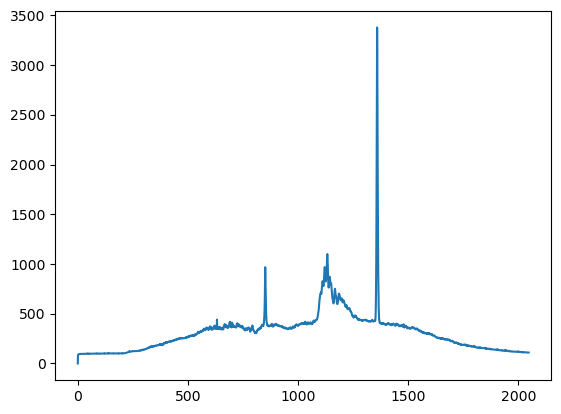

In [197]:
np.median(spectra[0],axis=0)
plt.plot(np.median(spectra[0],axis=0))